In [2]:
# import packages 
import cv2
import numpy as np
import os
import datetime as dt
import time
import pandas as pd

# define your own folder paths and names
project_path = os.getcwd()
pv_data_folder = os.path.join(project_path,'pv_data','pv_output_valid.pkl')

image_folder = os.path.join(project_path,'snapshot_highfreq')
image_name_format = '%Y%m%d%H%M%S'

output_folder =  os.path.join(project_path,'data_expanded')
pred_folder = os.path.join(output_folder,'data_nowcast')

# operating parameter
output_img_shape = [64, 64, 3] # down-size the high-res image to this resolution
start_date = dt.datetime(2017,1,1)
end_date = dt.datetime(2019,12,31)


In [3]:
# Setting up test set
sunny_day = [(2017,9,15),(2017,10,6),(2017,10,22),(2018,2,16),(2018,6,12),(2018,6,23),(2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_day = [(2017,6,24),(2017,9,20),(2017,10,11),(2018,1,25),(2018,3,9),(2018,10,4),(2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]
sunny_datetime = [dt.datetime(day[0],day[1],day[2]) for day in sunny_day]
cloudy_datetime = [dt.datetime(day[0],day[1],day[2]) for day in cloudy_day]
test_dates = sunny_datetime + cloudy_datetime

In [4]:
test_dates

[datetime.datetime(2017, 9, 15, 0, 0),
 datetime.datetime(2017, 10, 6, 0, 0),
 datetime.datetime(2017, 10, 22, 0, 0),
 datetime.datetime(2018, 2, 16, 0, 0),
 datetime.datetime(2018, 6, 12, 0, 0),
 datetime.datetime(2018, 6, 23, 0, 0),
 datetime.datetime(2019, 1, 25, 0, 0),
 datetime.datetime(2019, 6, 23, 0, 0),
 datetime.datetime(2019, 7, 14, 0, 0),
 datetime.datetime(2019, 10, 14, 0, 0),
 datetime.datetime(2017, 6, 24, 0, 0),
 datetime.datetime(2017, 9, 20, 0, 0),
 datetime.datetime(2017, 10, 11, 0, 0),
 datetime.datetime(2018, 1, 25, 0, 0),
 datetime.datetime(2018, 3, 9, 0, 0),
 datetime.datetime(2018, 10, 4, 0, 0),
 datetime.datetime(2019, 5, 27, 0, 0),
 datetime.datetime(2019, 6, 28, 0, 0),
 datetime.datetime(2019, 8, 10, 0, 0),
 datetime.datetime(2019, 10, 19, 0, 0)]

In [5]:
def find_idx_with_dates(all_times,test_dates):
    idx=[]
    for test_day in test_dates:
        test_day_end = test_day + dt.timedelta(days = 1)
        idx+=np.nonzero((all_times>test_day)*(all_times<test_day_end))[0].tolist()
    return idx

# This two function does the same thing. Just that one is for np, the other for pd.
def find_time_within_nparray(time_array,time_point):
    probable_idx = np.searchsorted(time_array,time_point)
    
    # If the time point is after all the time in pv_data
    if probable_idx == len(time_array):
        return None   
    
    # See if the time point is actually a match 
    if time_array[probable_idx]== time_point: 
        return probable_idx
        
    else:
        return None

def find_time_within_pdseries(time_array,time_point):
    probable_idx = np.searchsorted(time_array,time_point)
    
    # If the time point is after all the time in pv_data
    if probable_idx == len(time_array):
        return None   
    
    # See if the time point is actually a match 
    if time_array[probable_idx]== time_point: 
        return probable_idx
        
    else:
        return None

def listdir_noini(path):
    f_list = []
    for f in os.listdir(path):
        _, file_extension = os.path.splitext(f)
        if not file_extension == '.ini':
            f_list.append(f)    
    
    return sorted(f_list)
    
# return a list list all the .jpg files in 
def listdir_jpg(path):
    f_list = []
    for f in os.listdir(path):
        _, file_extension = os.path.splitext(f)
        if file_extension == '.jpg':
            f_list.append(f)
            
    return sorted(f_list)

### Read in PV output 

In [6]:
# Read in the pv output file
pv_output_all = pd.read_pickle(os.path.join(pv_data_folder))

# Obtain relevant data
pv_output_all = pv_output_all.loc[start_date:end_date]

### Read in image paths

In [7]:
# Initialization: find all image file path
image_paths = []
all_times = []

years_list = listdir_noini(os.path.join(image_folder))
for year in years_list: # cycle through the years
    months_list = listdir_noini(os.path.join(image_folder,year))
    for month in months_list: # cycle through the months
        dates_list  = listdir_noini(os.path.join(image_folder,year,month))
        for date in dates_list: # cycle through each day
            image_filenames = listdir_jpg(os.path.join(image_folder,year,month,date))
            for filename in image_filenames:
                image_paths.append(os.path.join(image_folder,year,month,date,filename))
                all_times.append(dt.datetime.strptime(filename,image_name_format+'.jpg'))

# Only keep the one in the given time frame
image_paths = np.array(image_paths)
all_times = np.array(all_times)
print(all_times.shape)
in_range = (all_times>=start_date) & (all_times<end_date)
image_paths = image_paths[in_range]
all_times = all_times[in_range]

(508807,)


### Load in each image, and save ones with valid PV_output

In [8]:
# Save images from snapshot folder to an npy file
# Designed for the high frequency (10s) dataset
number_images = len(image_paths)

all_images = np.ndarray([number_images] + output_img_shape,dtype='uint8')
pv_outputs = np.zeros(number_images)
validity_mask = np.zeros(number_images,dtype = bool)

# time counter
tic = time.process_time()

# Step through every snapshot, find if they have valid corresponding PV data

for i,image_path in enumerate(image_paths): # cycle through each file of the day
    # parse timestamp from image name
    curr_time = all_times[i]
    
    # test if there is corresponding data in PV data
    pv_idx = find_time_within_pdseries(pv_output_all.index,curr_time)
    if pv_idx is None:# if prediction ground truth not found
        print(curr_time,'has no PV record')
    else: 
        validity_mask[i] = 1
        frame = cv2.imread(os.path.join(image_path))
        # resizing the image to output_img_shape
        resizing_ratio = output_img_shape[0] / frame.shape[0]
        all_images[i] = cv2.resize(frame, None, fx=resizing_ratio, fy=resizing_ratio)
        pv_outputs[i] = pv_output_all.iloc[pv_idx]
    
    # prompt progress
    if i%100 == 0:
        print('processed {0} images/{1} images'.format(i,image_paths.size))
        if i%1000 == 0 and i>0:
            print('Expected finishing time:', dt.datetime.now()+
                  dt.timedelta(seconds = (time.process_time() - tic)*(image_paths.size/i-1)))
                                      
        
print('time_elapsed',time.process_time()-tic)

2017-03-09 06:00:00 has no PV record
processed 0 images/507963 images
2017-03-09 06:01:00 has no PV record
2017-03-09 06:02:00 has no PV record
2017-03-09 06:03:00 has no PV record
2017-03-09 06:04:00 has no PV record
2017-03-09 06:05:00 has no PV record
2017-03-09 06:06:00 has no PV record
2017-03-09 06:07:00 has no PV record
2017-03-09 06:08:00 has no PV record
2017-03-09 06:09:00 has no PV record
2017-03-09 06:10:00 has no PV record
2017-03-09 06:11:00 has no PV record
2017-03-09 06:12:00 has no PV record
2017-03-09 06:13:00 has no PV record
2017-03-09 06:14:00 has no PV record
2017-03-09 06:15:00 has no PV record
2017-03-09 06:16:00 has no PV record
2017-03-09 06:17:00 has no PV record
2017-03-09 06:18:00 has no PV record
2017-03-09 06:19:00 has no PV record
2017-03-09 06:20:00 has no PV record
2017-03-09 06:21:00 has no PV record
2017-03-09 06:22:00 has no PV record
2017-03-09 06:23:00 has no PV record
2017-03-09 06:24:00 has no PV record
2017-03-09 06:25:00 has no PV record
2017-

2017-03-11 07:08:00 has no PV record
2017-03-11 07:09:00 has no PV record
2017-03-11 07:10:00 has no PV record
2017-03-11 07:11:00 has no PV record
2017-03-11 07:12:00 has no PV record
2017-03-11 07:13:00 has no PV record
2017-03-11 07:14:00 has no PV record
2017-03-11 07:15:00 has no PV record
2017-03-11 07:16:00 has no PV record
2017-03-11 07:17:00 has no PV record
2017-03-11 07:18:00 has no PV record
2017-03-11 07:19:00 has no PV record
2017-03-11 07:20:00 has no PV record
2017-03-11 07:21:00 has no PV record
2017-03-11 07:22:00 has no PV record
2017-03-11 07:23:00 has no PV record
2017-03-11 07:24:00 has no PV record
2017-03-11 07:25:00 has no PV record
2017-03-11 07:26:00 has no PV record
2017-03-11 07:27:00 has no PV record
2017-03-11 07:28:00 has no PV record
2017-03-11 07:29:00 has no PV record
2017-03-11 07:30:00 has no PV record
2017-03-11 07:31:00 has no PV record
2017-03-11 07:32:00 has no PV record
2017-03-11 07:33:00 has no PV record
2017-03-11 07:34:00 has no PV record
2

2017-03-12 06:31:00 has no PV record
2017-03-12 06:32:00 has no PV record
2017-03-12 06:33:00 has no PV record
2017-03-12 06:34:00 has no PV record
2017-03-12 06:35:00 has no PV record
2017-03-12 06:36:00 has no PV record
2017-03-12 06:37:00 has no PV record
2017-03-12 06:37:20 has no PV record
2017-03-12 06:38:20 has no PV record
2017-03-12 06:39:20 has no PV record
2017-03-12 06:40:20 has no PV record
2017-03-12 06:41:20 has no PV record
2017-03-12 06:42:20 has no PV record
2017-03-12 06:43:20 has no PV record
2017-03-12 06:44:20 has no PV record
2017-03-12 06:45:20 has no PV record
2017-03-12 06:46:20 has no PV record
2017-03-12 06:47:20 has no PV record
processed 2400 images/507963 images
2017-03-12 06:48:20 has no PV record
2017-03-12 06:49:20 has no PV record
2017-03-12 06:50:20 has no PV record
2017-03-12 06:51:20 has no PV record
2017-03-12 06:52:20 has no PV record
2017-03-12 06:53:20 has no PV record
2017-03-12 06:54:20 has no PV record
2017-03-12 06:55:20 has no PV record
20

2017-03-12 18:49:50 has no PV record
2017-03-12 18:50:50 has no PV record
2017-03-12 18:51:50 has no PV record
2017-03-12 18:52:50 has no PV record
2017-03-12 18:53:50 has no PV record
2017-03-12 18:54:50 has no PV record
2017-03-12 18:55:50 has no PV record
2017-03-12 18:56:50 has no PV record
2017-03-12 18:57:50 has no PV record
2017-03-12 18:58:50 has no PV record
2017-03-12 18:59:50 has no PV record
2017-05-12 06:00:00 has no PV record
2017-05-12 06:01:00 has no PV record
2017-05-12 06:02:00 has no PV record
2017-05-12 06:03:00 has no PV record
2017-05-12 06:04:00 has no PV record
2017-05-12 06:05:00 has no PV record
2017-05-12 06:06:00 has no PV record
2017-05-12 06:07:00 has no PV record
2017-05-12 06:08:00 has no PV record
2017-05-12 06:09:00 has no PV record
2017-05-12 06:10:00 has no PV record
2017-05-12 06:11:00 has no PV record
2017-05-12 06:12:00 has no PV record
2017-05-12 06:13:00 has no PV record
2017-05-12 06:14:00 has no PV record
2017-05-12 06:15:00 has no PV record
2

processed 6600 images/507963 images
processed 6700 images/507963 images
processed 6800 images/507963 images
processed 6900 images/507963 images
processed 7000 images/507963 images
Expected finishing time: 2022-06-03 23:03:26.298369
processed 7100 images/507963 images
processed 7200 images/507963 images
processed 7300 images/507963 images
2017-05-16 19:45:10 has no PV record
2017-05-16 19:46:10 has no PV record
2017-05-16 19:47:10 has no PV record
2017-05-16 19:48:10 has no PV record
2017-05-16 19:49:10 has no PV record
2017-05-16 19:50:10 has no PV record
2017-05-16 19:51:10 has no PV record
2017-05-16 19:52:10 has no PV record
2017-05-16 19:53:10 has no PV record
2017-05-16 19:54:10 has no PV record
2017-05-16 19:55:10 has no PV record
2017-05-16 19:55:50 has no PV record
2017-05-16 19:56:50 has no PV record
2017-05-16 19:57:50 has no PV record
2017-05-16 19:58:50 has no PV record
2017-05-16 19:59:50 has no PV record
processed 7400 images/507963 images
processed 7500 images/507963 ima

processed 11900 images/507963 images
processed 12000 images/507963 images
Expected finishing time: 2022-06-03 23:28:58.135755
processed 12100 images/507963 images
processed 12200 images/507963 images
processed 12300 images/507963 images
processed 12400 images/507963 images
processed 12500 images/507963 images
processed 12600 images/507963 images
2017-05-24 19:50:10 has no PV record
2017-05-24 19:51:10 has no PV record
2017-05-24 19:52:10 has no PV record
2017-05-24 19:53:10 has no PV record
2017-05-24 19:54:10 has no PV record
2017-05-24 19:55:10 has no PV record
2017-05-24 19:56:10 has no PV record
2017-05-24 19:57:10 has no PV record
2017-05-24 19:58:10 has no PV record
2017-05-24 19:59:10 has no PV record
2017-05-25 06:00:00 has no PV record
2017-05-25 06:01:00 has no PV record
2017-05-25 06:02:00 has no PV record
2017-05-25 06:03:00 has no PV record
2017-05-25 06:04:00 has no PV record
processed 12700 images/507963 images
2017-05-25 06:05:00 has no PV record
2017-05-25 06:06:00 has

processed 17000 images/507963 images
Expected finishing time: 2022-06-03 23:42:48.737684
processed 17100 images/507963 images
processed 17200 images/507963 images
processed 17300 images/507963 images
processed 17400 images/507963 images
processed 17500 images/507963 images
processed 17600 images/507963 images
processed 17700 images/507963 images
2017-05-30 19:55:10 has no PV record
2017-05-30 19:56:10 has no PV record
2017-05-30 19:57:10 has no PV record
2017-05-30 19:58:10 has no PV record
2017-05-30 19:59:10 has no PV record
2017-05-31 06:00:00 has no PV record
2017-05-31 06:01:00 has no PV record
2017-05-31 06:02:00 has no PV record
2017-05-31 06:03:00 has no PV record
2017-05-31 06:04:00 has no PV record
2017-05-31 06:05:00 has no PV record
2017-05-31 06:06:00 has no PV record
2017-05-31 06:07:00 has no PV record
2017-05-31 06:08:00 has no PV record
2017-05-31 06:09:00 has no PV record
2017-05-31 06:10:00 has no PV record
2017-05-31 06:11:00 has no PV record
2017-05-31 06:12:00 has

processed 24600 images/507963 images
processed 24700 images/507963 images
processed 24800 images/507963 images
processed 24900 images/507963 images
processed 25000 images/507963 images
Expected finishing time: 2022-06-03 23:53:30.038758
processed 25100 images/507963 images
processed 25200 images/507963 images
processed 25300 images/507963 images
2017-06-09 06:00:00 has no PV record
2017-06-09 06:01:00 has no PV record
2017-06-09 06:02:00 has no PV record
2017-06-09 06:03:00 has no PV record
2017-06-09 06:04:00 has no PV record
2017-06-09 06:05:00 has no PV record
2017-06-09 06:06:00 has no PV record
2017-06-09 06:07:00 has no PV record
2017-06-09 06:08:00 has no PV record
2017-06-09 06:09:00 has no PV record
2017-06-09 06:10:00 has no PV record
2017-06-09 06:11:00 has no PV record
2017-06-09 06:12:00 has no PV record
2017-06-09 06:13:00 has no PV record
2017-06-09 06:14:00 has no PV record
2017-06-09 06:15:00 has no PV record
2017-06-09 06:16:00 has no PV record
2017-06-09 06:17:00 has

processed 31700 images/507963 images
processed 31800 images/507963 images
processed 31900 images/507963 images
processed 32000 images/507963 images
Expected finishing time: 2022-06-03 23:59:40.167618
processed 32100 images/507963 images
processed 32200 images/507963 images
processed 32300 images/507963 images
2017-06-21 06:00:00 has no PV record
2017-06-21 06:01:00 has no PV record
2017-06-21 06:02:00 has no PV record
2017-06-21 06:03:00 has no PV record
2017-06-21 06:04:00 has no PV record
2017-06-21 06:05:00 has no PV record
2017-06-21 06:06:00 has no PV record
2017-06-21 06:07:00 has no PV record
2017-06-21 06:08:00 has no PV record
2017-06-21 06:09:00 has no PV record
2017-06-21 06:10:00 has no PV record
2017-06-21 06:11:00 has no PV record
2017-06-21 06:12:00 has no PV record
2017-06-21 06:13:00 has no PV record
2017-06-21 06:14:00 has no PV record
2017-06-21 06:15:00 has no PV record
processed 32400 images/507963 images
processed 32500 images/507963 images
processed 32600 images/

2017-07-02 06:00:00 has no PV record
2017-07-02 06:01:00 has no PV record
2017-07-02 06:02:00 has no PV record
2017-07-02 06:03:00 has no PV record
2017-07-02 06:04:00 has no PV record
2017-07-02 06:05:00 has no PV record
2017-07-02 06:06:00 has no PV record
2017-07-02 06:07:00 has no PV record
2017-07-02 06:08:00 has no PV record
2017-07-02 06:09:00 has no PV record
2017-07-02 06:10:00 has no PV record
2017-07-02 06:11:00 has no PV record
2017-07-02 06:12:00 has no PV record
2017-07-02 06:13:00 has no PV record
2017-07-02 06:14:00 has no PV record
2017-07-02 06:15:00 has no PV record
2017-07-02 06:16:00 has no PV record
2017-07-02 06:17:00 has no PV record
2017-07-02 06:18:00 has no PV record
2017-07-02 06:19:00 has no PV record
2017-07-02 06:20:00 has no PV record
2017-07-02 06:21:00 has no PV record
2017-07-02 06:22:00 has no PV record
processed 38500 images/507963 images
processed 38600 images/507963 images
processed 38700 images/507963 images
processed 38800 images/507963 images
p

processed 43900 images/507963 images
processed 44000 images/507963 images
Expected finishing time: 2022-06-04 00:09:00.972671
processed 44100 images/507963 images
processed 44200 images/507963 images
processed 44300 images/507963 images
2017-07-26 06:00:00 has no PV record
2017-07-26 06:01:00 has no PV record
2017-07-26 06:02:00 has no PV record
2017-07-26 06:03:00 has no PV record
2017-07-26 06:04:00 has no PV record
2017-07-26 06:05:00 has no PV record
2017-07-26 06:06:00 has no PV record
2017-07-26 06:07:00 has no PV record
2017-07-26 06:08:00 has no PV record
2017-07-26 06:09:00 has no PV record
2017-07-26 06:10:00 has no PV record
2017-07-26 06:11:00 has no PV record
2017-07-26 06:12:00 has no PV record
2017-07-26 06:13:00 has no PV record
2017-07-26 06:14:00 has no PV record
2017-07-26 06:15:00 has no PV record
2017-07-26 06:16:00 has no PV record
2017-07-26 06:17:00 has no PV record
2017-07-26 06:18:00 has no PV record
2017-07-26 06:19:00 has no PV record
2017-07-26 06:20:00 has

processed 47400 images/507963 images
processed 47500 images/507963 images
processed 47600 images/507963 images
processed 47700 images/507963 images
2017-07-29 19:54:30 has no PV record
2017-07-29 19:55:30 has no PV record
2017-07-29 19:56:30 has no PV record
2017-07-29 19:57:30 has no PV record
2017-07-29 19:58:30 has no PV record
2017-07-29 19:59:30 has no PV record
2017-07-30 06:00:00 has no PV record
2017-07-30 06:01:00 has no PV record
2017-07-30 06:02:00 has no PV record
2017-07-30 06:03:00 has no PV record
2017-07-30 06:04:00 has no PV record
2017-07-30 06:05:00 has no PV record
2017-07-30 06:06:00 has no PV record
2017-07-30 06:07:00 has no PV record
2017-07-30 06:08:00 has no PV record
2017-07-30 06:09:00 has no PV record
2017-07-30 06:10:00 has no PV record
2017-07-30 06:11:00 has no PV record
2017-07-30 06:12:00 has no PV record
2017-07-30 06:13:00 has no PV record
2017-07-30 06:14:00 has no PV record
2017-07-30 06:15:00 has no PV record
2017-07-30 06:16:00 has no PV record
2

processed 50300 images/507963 images
processed 50400 images/507963 images
processed 50500 images/507963 images
processed 50600 images/507963 images
processed 50700 images/507963 images
processed 50800 images/507963 images
processed 50900 images/507963 images
processed 51000 images/507963 images
Expected finishing time: 2022-06-04 00:08:55.372880
2017-08-03 06:00:00 has no PV record
2017-08-03 06:01:00 has no PV record
2017-08-03 06:02:00 has no PV record
2017-08-03 06:03:00 has no PV record
2017-08-03 06:04:00 has no PV record
2017-08-03 06:05:00 has no PV record
2017-08-03 06:06:00 has no PV record
2017-08-03 06:07:00 has no PV record
2017-08-03 06:08:00 has no PV record
2017-08-03 06:09:00 has no PV record
2017-08-03 06:10:00 has no PV record
2017-08-03 06:11:00 has no PV record
2017-08-03 06:12:00 has no PV record
2017-08-03 06:13:00 has no PV record
2017-08-03 06:14:00 has no PV record
2017-08-03 06:15:00 has no PV record
processed 51100 images/507963 images
2017-08-03 06:16:00 has

processed 52900 images/507963 images
processed 53000 images/507963 images
Expected finishing time: 2022-06-04 00:08:52.233335
processed 53100 images/507963 images
processed 53200 images/507963 images
processed 53300 images/507963 images
processed 53400 images/507963 images
processed 53500 images/507963 images
processed 53600 images/507963 images
2017-08-05 19:49:10 has no PV record
2017-08-05 19:50:10 has no PV record
2017-08-05 19:51:10 has no PV record
2017-08-05 19:52:10 has no PV record
2017-08-05 19:53:10 has no PV record
2017-08-05 19:54:10 has no PV record
2017-08-05 19:55:10 has no PV record
2017-08-05 19:56:10 has no PV record
2017-08-05 19:57:10 has no PV record
2017-08-05 19:58:10 has no PV record
2017-08-05 19:59:10 has no PV record
2017-08-06 06:00:00 has no PV record
2017-08-06 06:01:00 has no PV record
2017-08-06 06:02:00 has no PV record
2017-08-06 06:03:00 has no PV record
2017-08-06 06:04:00 has no PV record
2017-08-06 06:05:00 has no PV record
2017-08-06 06:06:00 has

processed 55600 images/507963 images
processed 55700 images/507963 images
processed 55800 images/507963 images
processed 55900 images/507963 images
processed 56000 images/507963 images
Expected finishing time: 2022-06-04 00:09:39.618951
processed 56100 images/507963 images
2017-08-08 19:47:40 has no PV record
2017-08-08 19:48:40 has no PV record
2017-08-08 19:49:40 has no PV record
2017-08-08 19:50:40 has no PV record
2017-08-08 19:51:30 has no PV record
2017-08-08 19:52:30 has no PV record
2017-08-08 19:53:30 has no PV record
2017-08-08 19:54:30 has no PV record
2017-08-08 19:55:30 has no PV record
2017-08-08 19:56:30 has no PV record
2017-08-08 19:57:30 has no PV record
2017-08-08 19:58:30 has no PV record
2017-08-08 19:59:30 has no PV record
2017-08-09 06:00:00 has no PV record
2017-08-09 06:01:00 has no PV record
2017-08-09 06:02:00 has no PV record
2017-08-09 06:03:00 has no PV record
2017-08-09 06:04:00 has no PV record
2017-08-09 06:05:00 has no PV record
2017-08-09 06:06:00 has

processed 58000 images/507963 images
Expected finishing time: 2022-06-04 00:09:12.456977
processed 58100 images/507963 images
processed 58200 images/507963 images
processed 58300 images/507963 images
processed 58400 images/507963 images
processed 58500 images/507963 images
processed 58600 images/507963 images
2017-08-11 19:43:40 has no PV record
2017-08-11 19:44:40 has no PV record
2017-08-11 19:45:40 has no PV record
2017-08-11 19:46:40 has no PV record
2017-08-11 19:47:40 has no PV record
2017-08-11 19:48:40 has no PV record
2017-08-11 19:49:40 has no PV record
2017-08-11 19:50:40 has no PV record
2017-08-11 19:51:40 has no PV record
2017-08-11 19:52:40 has no PV record
2017-08-11 19:53:40 has no PV record
2017-08-11 19:54:40 has no PV record
2017-08-11 19:55:40 has no PV record
2017-08-11 19:56:40 has no PV record
2017-08-11 19:57:40 has no PV record
2017-08-11 19:58:40 has no PV record
2017-08-11 19:59:40 has no PV record
2017-08-12 06:00:00 has no PV record
2017-08-12 06:01:00 has

processed 60500 images/507963 images
processed 60600 images/507963 images
processed 60700 images/507963 images
processed 60800 images/507963 images
processed 60900 images/507963 images
processed 61000 images/507963 images
Expected finishing time: 2022-06-04 00:08:56.313262
processed 61100 images/507963 images
2017-08-14 19:29:20 has no PV record
2017-08-14 19:30:20 has no PV record
2017-08-14 19:31:20 has no PV record
2017-08-14 19:32:20 has no PV record
2017-08-14 19:33:20 has no PV record
2017-08-14 19:34:20 has no PV record
2017-08-14 19:35:20 has no PV record
2017-08-14 19:36:20 has no PV record
2017-08-14 19:37:20 has no PV record
2017-08-14 19:38:20 has no PV record
2017-08-14 19:39:20 has no PV record
2017-08-14 19:40:20 has no PV record
2017-08-14 19:41:20 has no PV record
2017-08-14 19:42:20 has no PV record
2017-08-14 19:43:20 has no PV record
2017-08-14 19:44:20 has no PV record
2017-08-14 19:45:20 has no PV record
processed 61200 images/507963 images
2017-08-14 19:46:20 has

processed 63000 images/507963 images
Expected finishing time: 2022-06-04 00:08:12.690181
processed 63100 images/507963 images
processed 63200 images/507963 images
processed 63300 images/507963 images
processed 63400 images/507963 images
processed 63500 images/507963 images
processed 63600 images/507963 images
processed 63700 images/507963 images
2017-08-17 19:38:50 has no PV record
2017-08-17 19:39:50 has no PV record
2017-08-17 19:40:50 has no PV record
2017-08-17 19:41:50 has no PV record
2017-08-17 19:42:50 has no PV record
2017-08-17 19:43:50 has no PV record
2017-08-17 19:44:50 has no PV record
2017-08-17 19:45:50 has no PV record
2017-08-17 19:46:50 has no PV record
2017-08-17 19:47:50 has no PV record
2017-08-17 19:48:50 has no PV record
2017-08-17 19:49:50 has no PV record
2017-08-17 19:50:50 has no PV record
2017-08-17 19:51:50 has no PV record
2017-08-17 19:52:50 has no PV record
2017-08-17 19:53:50 has no PV record
2017-08-17 19:54:50 has no PV record
2017-08-17 19:55:50 has

processed 65500 images/507963 images
processed 65600 images/507963 images
processed 65700 images/507963 images
processed 65800 images/507963 images
processed 65900 images/507963 images
processed 66000 images/507963 images
Expected finishing time: 2022-06-04 00:06:33.997760
processed 66100 images/507963 images
processed 66200 images/507963 images
2017-08-20 19:33:00 has no PV record
2017-08-20 19:34:00 has no PV record
2017-08-20 19:35:00 has no PV record
2017-08-20 19:36:00 has no PV record
2017-08-20 19:37:00 has no PV record
2017-08-20 19:38:00 has no PV record
2017-08-20 19:39:00 has no PV record
2017-08-20 19:40:00 has no PV record
2017-08-20 19:41:00 has no PV record
2017-08-20 19:42:00 has no PV record
2017-08-20 19:43:00 has no PV record
2017-08-20 19:44:00 has no PV record
2017-08-20 19:45:00 has no PV record
2017-08-20 19:46:00 has no PV record
2017-08-20 19:47:00 has no PV record
2017-08-20 19:48:00 has no PV record
2017-08-20 19:49:00 has no PV record
2017-08-20 19:50:00 has

processed 68100 images/507963 images
processed 68200 images/507963 images
processed 68300 images/507963 images
processed 68400 images/507963 images
processed 68500 images/507963 images
processed 68600 images/507963 images
processed 68700 images/507963 images
2017-08-23 19:23:00 has no PV record
2017-08-23 19:24:00 has no PV record
2017-08-23 19:25:00 has no PV record
2017-08-23 19:26:00 has no PV record
2017-08-23 19:27:00 has no PV record
2017-08-23 19:28:00 has no PV record
2017-08-23 19:29:00 has no PV record
2017-08-23 19:30:00 has no PV record
2017-08-23 19:31:00 has no PV record
2017-08-23 19:32:00 has no PV record
2017-08-23 19:33:00 has no PV record
2017-08-23 19:34:00 has no PV record
2017-08-23 19:35:00 has no PV record
2017-08-23 19:36:00 has no PV record
2017-08-23 19:37:00 has no PV record
2017-08-23 19:38:00 has no PV record
2017-08-23 19:39:00 has no PV record
2017-08-23 19:40:00 has no PV record
2017-08-23 19:41:00 has no PV record
2017-08-23 19:42:00 has no PV record
2

processed 70600 images/507963 images
processed 70700 images/507963 images
processed 70800 images/507963 images
processed 70900 images/507963 images
processed 71000 images/507963 images
Expected finishing time: 2022-06-04 00:04:19.177191
processed 71100 images/507963 images
processed 71200 images/507963 images
2017-08-26 19:30:00 has no PV record
2017-08-26 19:31:00 has no PV record
2017-08-26 19:32:00 has no PV record
2017-08-26 19:33:00 has no PV record
2017-08-26 19:34:00 has no PV record
2017-08-26 19:35:00 has no PV record
2017-08-26 19:36:00 has no PV record
2017-08-26 19:37:00 has no PV record
2017-08-26 19:38:00 has no PV record
2017-08-26 19:39:00 has no PV record
2017-08-26 19:40:00 has no PV record
2017-08-26 19:41:00 has no PV record
2017-08-26 19:42:00 has no PV record
2017-08-26 19:43:00 has no PV record
2017-08-26 19:44:00 has no PV record
2017-08-26 19:45:00 has no PV record
2017-08-26 19:46:00 has no PV record
2017-08-26 19:47:00 has no PV record
2017-08-26 19:48:00 has

processed 73100 images/507963 images
processed 73200 images/507963 images
processed 73300 images/507963 images
processed 73400 images/507963 images
processed 73500 images/507963 images
processed 73600 images/507963 images
processed 73700 images/507963 images
2017-08-29 19:23:00 has no PV record
2017-08-29 19:24:00 has no PV record
2017-08-29 19:25:00 has no PV record
2017-08-29 19:26:00 has no PV record
2017-08-29 19:27:00 has no PV record
2017-08-29 19:28:00 has no PV record
2017-08-29 19:29:00 has no PV record
2017-08-29 19:30:00 has no PV record
2017-08-29 19:31:00 has no PV record
2017-08-29 19:32:00 has no PV record
2017-08-29 19:33:00 has no PV record
2017-08-29 19:34:00 has no PV record
2017-08-29 19:35:00 has no PV record
2017-08-29 19:36:00 has no PV record
2017-08-29 19:37:00 has no PV record
2017-08-29 19:38:00 has no PV record
2017-08-29 19:39:00 has no PV record
2017-08-29 19:40:00 has no PV record
processed 73800 images/507963 images
2017-08-29 19:41:00 has no PV record
2

2017-08-31 19:21:00 has no PV record
2017-08-31 19:22:00 has no PV record
2017-08-31 19:23:00 has no PV record
2017-08-31 19:24:00 has no PV record
2017-08-31 19:25:00 has no PV record
2017-08-31 19:26:00 has no PV record
2017-08-31 19:27:00 has no PV record
2017-08-31 19:28:00 has no PV record
2017-08-31 19:29:00 has no PV record
2017-08-31 19:30:00 has no PV record
2017-08-31 19:31:00 has no PV record
2017-08-31 19:32:00 has no PV record
2017-08-31 19:33:00 has no PV record
2017-08-31 19:34:00 has no PV record
2017-08-31 19:35:00 has no PV record
2017-08-31 19:36:00 has no PV record
2017-08-31 19:37:00 has no PV record
2017-08-31 19:38:00 has no PV record
2017-08-31 19:39:00 has no PV record
2017-08-31 19:40:00 has no PV record
2017-08-31 19:41:00 has no PV record
2017-08-31 19:42:00 has no PV record
2017-08-31 19:43:00 has no PV record
2017-08-31 19:44:00 has no PV record
2017-08-31 19:45:00 has no PV record
2017-08-31 19:46:00 has no PV record
2017-08-31 19:47:00 has no PV record
2

processed 76800 images/507963 images
processed 76900 images/507963 images
processed 77000 images/507963 images
Expected finishing time: 2022-06-04 00:01:05.114196
processed 77100 images/507963 images
2017-09-02 19:09:00 has no PV record
2017-09-02 19:10:00 has no PV record
2017-09-02 19:11:00 has no PV record
2017-09-02 19:12:00 has no PV record
2017-09-02 19:13:00 has no PV record
2017-09-02 19:14:00 has no PV record
2017-09-02 19:15:00 has no PV record
2017-09-02 19:16:00 has no PV record
2017-09-02 19:17:00 has no PV record
2017-09-02 19:18:00 has no PV record
2017-09-02 19:19:00 has no PV record
2017-09-02 19:20:00 has no PV record
2017-09-02 19:21:00 has no PV record
2017-09-02 19:22:00 has no PV record
2017-09-02 19:23:00 has no PV record
2017-09-02 19:24:00 has no PV record
2017-09-02 19:25:00 has no PV record
2017-09-02 19:26:00 has no PV record
2017-09-02 19:27:00 has no PV record
2017-09-02 19:28:00 has no PV record
2017-09-02 19:29:00 has no PV record
2017-09-02 19:30:00 has

processed 78100 images/507963 images
processed 78200 images/507963 images
processed 78300 images/507963 images
processed 78400 images/507963 images
processed 78500 images/507963 images
processed 78600 images/507963 images
processed 78700 images/507963 images
processed 78800 images/507963 images
2017-09-04 19:11:00 has no PV record
2017-09-04 19:12:00 has no PV record
2017-09-04 19:13:00 has no PV record
2017-09-04 19:14:00 has no PV record
2017-09-04 19:15:00 has no PV record
2017-09-04 19:16:00 has no PV record
2017-09-04 19:17:00 has no PV record
2017-09-04 19:18:00 has no PV record
2017-09-04 19:19:00 has no PV record
2017-09-04 19:20:00 has no PV record
2017-09-04 19:21:00 has no PV record
2017-09-04 19:22:00 has no PV record
2017-09-04 19:23:00 has no PV record
2017-09-04 19:24:00 has no PV record
2017-09-04 19:25:00 has no PV record
2017-09-04 19:26:00 has no PV record
2017-09-04 19:27:00 has no PV record
2017-09-04 19:28:00 has no PV record
2017-09-04 19:29:00 has no PV record
2

processed 79800 images/507963 images
processed 79900 images/507963 images
processed 80000 images/507963 images
Expected finishing time: 2022-06-03 23:59:27.445992
processed 80100 images/507963 images
processed 80200 images/507963 images
processed 80300 images/507963 images
processed 80400 images/507963 images
2017-09-06 19:04:00 has no PV record
2017-09-06 19:05:00 has no PV record
2017-09-06 19:06:00 has no PV record
2017-09-06 19:07:00 has no PV record
2017-09-06 19:08:00 has no PV record
2017-09-06 19:09:00 has no PV record
2017-09-06 19:10:00 has no PV record
2017-09-06 19:11:00 has no PV record
2017-09-06 19:12:00 has no PV record
2017-09-06 19:13:00 has no PV record
2017-09-06 19:14:00 has no PV record
2017-09-06 19:15:00 has no PV record
2017-09-06 19:16:00 has no PV record
2017-09-06 19:17:00 has no PV record
2017-09-06 19:18:00 has no PV record
2017-09-06 19:19:00 has no PV record
2017-09-06 19:20:00 has no PV record
2017-09-06 19:21:00 has no PV record
2017-09-06 19:22:00 has

processed 81500 images/507963 images
2017-09-08 08:59:00 has no PV record
2017-09-08 09:00:00 has no PV record
2017-09-08 09:01:00 has no PV record
2017-09-08 09:02:00 has no PV record
2017-09-08 09:03:00 has no PV record
2017-09-08 09:04:00 has no PV record
2017-09-08 09:05:00 has no PV record
2017-09-08 09:06:00 has no PV record
2017-09-08 09:07:00 has no PV record
2017-09-08 09:08:00 has no PV record
2017-09-08 09:09:00 has no PV record
2017-09-08 09:10:00 has no PV record
2017-09-08 09:11:00 has no PV record
2017-09-08 09:12:00 has no PV record
2017-09-08 09:13:00 has no PV record
2017-09-08 09:14:00 has no PV record
2017-09-08 09:15:00 has no PV record
2017-09-08 09:16:00 has no PV record
2017-09-08 09:17:00 has no PV record
2017-09-08 09:18:00 has no PV record
2017-09-08 09:19:00 has no PV record
2017-09-08 09:20:00 has no PV record
2017-09-08 09:21:00 has no PV record
2017-09-08 09:22:00 has no PV record
2017-09-08 09:23:00 has no PV record
2017-09-08 09:24:00 has no PV record
2

processed 82400 images/507963 images
processed 82500 images/507963 images
processed 82600 images/507963 images
processed 82700 images/507963 images
processed 82800 images/507963 images
processed 82900 images/507963 images
processed 83000 images/507963 images
Expected finishing time: 2022-06-03 23:57:32.597263
2017-09-09 19:08:00 has no PV record
2017-09-09 19:09:00 has no PV record
2017-09-09 19:10:00 has no PV record
2017-09-09 19:11:00 has no PV record
2017-09-09 19:12:00 has no PV record
2017-09-09 19:13:00 has no PV record
2017-09-09 19:14:00 has no PV record
2017-09-09 19:15:00 has no PV record
2017-09-09 19:16:00 has no PV record
2017-09-09 19:17:00 has no PV record
2017-09-09 19:18:00 has no PV record
2017-09-09 19:19:00 has no PV record
2017-09-09 19:20:00 has no PV record
2017-09-09 19:21:00 has no PV record
2017-09-09 19:22:00 has no PV record
2017-09-09 19:23:00 has no PV record
2017-09-09 19:24:00 has no PV record
2017-09-09 19:25:00 has no PV record
2017-09-09 19:26:00 has

processed 84000 images/507963 images
Expected finishing time: 2022-06-03 23:56:50.154185
processed 84100 images/507963 images
processed 84200 images/507963 images
processed 84300 images/507963 images
processed 84400 images/507963 images
processed 84500 images/507963 images
2017-09-11 17:06:00 has no PV record
2017-09-11 17:07:00 has no PV record
2017-09-11 17:08:00 has no PV record
2017-09-11 17:09:00 has no PV record
2017-09-11 17:10:00 has no PV record
2017-09-11 17:11:00 has no PV record
2017-09-11 17:12:00 has no PV record
2017-09-11 17:13:00 has no PV record
2017-09-11 17:14:00 has no PV record
2017-09-11 17:15:00 has no PV record
2017-09-11 17:16:00 has no PV record
2017-09-11 17:17:00 has no PV record
2017-09-11 17:18:00 has no PV record
2017-09-11 17:19:00 has no PV record
2017-09-11 17:20:00 has no PV record
2017-09-11 17:21:00 has no PV record
2017-09-11 17:22:00 has no PV record
2017-09-11 17:23:00 has no PV record
2017-09-11 17:24:00 has no PV record
processed 84600 images/

processed 85700 images/507963 images
processed 85800 images/507963 images
processed 85900 images/507963 images
processed 86000 images/507963 images
Expected finishing time: 2022-06-03 23:56:10.805558
processed 86100 images/507963 images
processed 86200 images/507963 images
processed 86300 images/507963 images
2017-09-13 19:03:00 has no PV record
2017-09-13 19:04:00 has no PV record
2017-09-13 19:05:00 has no PV record
2017-09-13 19:06:00 has no PV record
2017-09-13 19:07:00 has no PV record
2017-09-13 19:08:00 has no PV record
2017-09-13 19:09:00 has no PV record
2017-09-13 19:10:00 has no PV record
2017-09-13 19:11:00 has no PV record
2017-09-13 19:12:00 has no PV record
2017-09-13 19:13:00 has no PV record
2017-09-13 19:14:00 has no PV record
2017-09-13 19:15:00 has no PV record
2017-09-13 19:16:00 has no PV record
2017-09-13 19:17:00 has no PV record
2017-09-13 19:18:00 has no PV record
2017-09-13 19:19:00 has no PV record
2017-09-13 19:20:00 has no PV record
2017-09-13 19:21:00 has

processed 87400 images/507963 images
processed 87500 images/507963 images
processed 87600 images/507963 images
processed 87700 images/507963 images
processed 87800 images/507963 images
processed 87900 images/507963 images
processed 88000 images/507963 images
Expected finishing time: 2022-06-03 23:55:19.685325
2017-09-15 18:59:00 has no PV record
2017-09-15 19:00:00 has no PV record
2017-09-15 19:01:00 has no PV record
2017-09-15 19:02:00 has no PV record
2017-09-15 19:03:00 has no PV record
2017-09-15 19:04:00 has no PV record
2017-09-15 19:05:00 has no PV record
2017-09-15 19:06:00 has no PV record
2017-09-15 19:07:00 has no PV record
2017-09-15 19:08:00 has no PV record
2017-09-15 19:09:00 has no PV record
2017-09-15 19:10:00 has no PV record
2017-09-15 19:11:00 has no PV record
2017-09-15 19:13:00 has no PV record
2017-09-15 19:14:00 has no PV record
2017-09-15 19:15:00 has no PV record
2017-09-15 19:16:00 has no PV record
2017-09-15 19:17:00 has no PV record
2017-09-15 19:18:00 has

processed 89100 images/507963 images
processed 89200 images/507963 images
processed 89300 images/507963 images
processed 89400 images/507963 images
processed 89500 images/507963 images
processed 89600 images/507963 images
2017-09-17 18:52:00 has no PV record
2017-09-17 18:53:00 has no PV record
processed 89700 images/507963 images
2017-09-17 18:54:00 has no PV record
2017-09-17 18:55:00 has no PV record
2017-09-17 18:56:00 has no PV record
2017-09-17 18:57:00 has no PV record
2017-09-17 18:58:00 has no PV record
2017-09-17 18:59:00 has no PV record
2017-09-17 19:00:00 has no PV record
2017-09-17 19:01:00 has no PV record
2017-09-17 19:02:00 has no PV record
2017-09-17 19:03:00 has no PV record
2017-09-17 19:04:00 has no PV record
2017-09-17 19:05:00 has no PV record
2017-09-17 19:06:00 has no PV record
2017-09-17 19:07:00 has no PV record
2017-09-17 19:08:00 has no PV record
2017-09-17 19:09:00 has no PV record
2017-09-17 19:10:00 has no PV record
2017-09-17 19:11:00 has no PV record
2

processed 90700 images/507963 images
processed 90800 images/507963 images
processed 90900 images/507963 images
processed 91000 images/507963 images
Expected finishing time: 2022-06-03 23:53:49.979853
processed 91100 images/507963 images
processed 91200 images/507963 images
processed 91300 images/507963 images
2017-09-19 18:53:00 has no PV record
2017-09-19 18:54:00 has no PV record
2017-09-19 18:55:00 has no PV record
2017-09-19 18:56:00 has no PV record
2017-09-19 18:57:00 has no PV record
2017-09-19 18:58:00 has no PV record
2017-09-19 18:59:00 has no PV record
2017-09-19 19:00:00 has no PV record
2017-09-19 19:01:00 has no PV record
2017-09-19 19:02:00 has no PV record
2017-09-19 19:03:00 has no PV record
2017-09-19 19:04:00 has no PV record
2017-09-19 19:05:00 has no PV record
2017-09-19 19:06:00 has no PV record
2017-09-19 19:07:00 has no PV record
2017-09-19 19:08:00 has no PV record
2017-09-19 19:09:00 has no PV record
2017-09-19 19:10:00 has no PV record
2017-09-19 19:11:00 has

processed 92400 images/507963 images
processed 92500 images/507963 images
processed 92600 images/507963 images
processed 92700 images/507963 images
processed 92800 images/507963 images
processed 92900 images/507963 images
processed 93000 images/507963 images
Expected finishing time: 2022-06-03 23:53:04.752169
2017-09-21 18:44:00 has no PV record
2017-09-21 18:45:00 has no PV record
2017-09-21 18:46:00 has no PV record
2017-09-21 18:47:00 has no PV record
2017-09-21 18:48:00 has no PV record
2017-09-21 18:49:00 has no PV record
2017-09-21 18:50:00 has no PV record
2017-09-21 18:51:00 has no PV record
2017-09-21 18:52:00 has no PV record
2017-09-21 18:53:00 has no PV record
2017-09-21 18:54:00 has no PV record
2017-09-21 18:55:00 has no PV record
2017-09-21 18:56:00 has no PV record
2017-09-21 18:57:00 has no PV record
2017-09-21 18:58:00 has no PV record
2017-09-21 18:59:00 has no PV record
2017-09-21 19:00:00 has no PV record
2017-09-21 19:01:00 has no PV record
2017-09-21 19:02:00 has

processed 94100 images/507963 images
processed 94200 images/507963 images
processed 94300 images/507963 images
processed 94400 images/507963 images
processed 94500 images/507963 images
processed 94600 images/507963 images
processed 94700 images/507963 images
2017-09-23 18:46:00 has no PV record
2017-09-23 18:47:00 has no PV record
2017-09-23 18:48:00 has no PV record
2017-09-23 18:49:00 has no PV record
2017-09-23 18:50:00 has no PV record
2017-09-23 18:51:00 has no PV record
2017-09-23 18:52:00 has no PV record
2017-09-23 18:53:00 has no PV record
2017-09-23 18:54:00 has no PV record
2017-09-23 18:55:00 has no PV record
2017-09-23 18:56:00 has no PV record
2017-09-23 18:57:00 has no PV record
2017-09-23 18:58:00 has no PV record
2017-09-23 18:59:00 has no PV record
2017-09-23 19:00:00 has no PV record
2017-09-23 19:01:00 has no PV record
2017-09-23 19:02:00 has no PV record
2017-09-23 19:03:00 has no PV record
2017-09-23 19:04:00 has no PV record
2017-09-23 19:05:00 has no PV record
2

processed 95800 images/507963 images
processed 95900 images/507963 images
processed 96000 images/507963 images
Expected finishing time: 2022-06-03 23:51:37.108067
processed 96100 images/507963 images
processed 96200 images/507963 images
processed 96300 images/507963 images
2017-09-30 18:35:00 has no PV record
2017-09-30 18:36:00 has no PV record
2017-09-30 18:37:00 has no PV record
2017-09-30 18:38:00 has no PV record
2017-09-30 18:39:00 has no PV record
2017-09-30 18:40:00 has no PV record
2017-09-30 18:41:00 has no PV record
2017-09-30 18:42:00 has no PV record
2017-09-30 18:43:00 has no PV record
2017-09-30 18:44:00 has no PV record
2017-09-30 18:45:00 has no PV record
processed 96400 images/507963 images
2017-09-30 18:46:00 has no PV record
2017-09-30 18:47:00 has no PV record
2017-09-30 18:48:00 has no PV record
2017-09-30 18:49:00 has no PV record
2017-09-30 18:50:00 has no PV record
2017-09-30 18:51:00 has no PV record
2017-09-30 18:52:00 has no PV record
2017-09-30 18:53:00 has

processed 97500 images/507963 images
processed 97600 images/507963 images
processed 97700 images/507963 images
processed 97800 images/507963 images
processed 97900 images/507963 images
processed 98000 images/507963 images
Expected finishing time: 2022-06-03 23:50:45.634673
2017-10-02 18:31:00 has no PV record
2017-10-02 18:32:00 has no PV record
2017-10-02 18:33:00 has no PV record
2017-10-02 18:34:00 has no PV record
2017-10-02 18:35:00 has no PV record
2017-10-02 18:36:00 has no PV record
2017-10-02 18:37:00 has no PV record
2017-10-02 18:38:00 has no PV record
2017-10-02 18:39:00 has no PV record
2017-10-02 18:40:00 has no PV record
2017-10-02 18:41:00 has no PV record
2017-10-02 18:42:00 has no PV record
2017-10-02 18:43:00 has no PV record
2017-10-02 18:44:00 has no PV record
2017-10-02 18:45:00 has no PV record
2017-10-02 18:46:00 has no PV record
2017-10-02 18:47:00 has no PV record
2017-10-02 18:48:00 has no PV record
2017-10-02 18:49:00 has no PV record
2017-10-02 18:50:00 has

processed 99100 images/507963 images
processed 99200 images/507963 images
processed 99300 images/507963 images
processed 99400 images/507963 images
processed 99500 images/507963 images
processed 99600 images/507963 images
processed 99700 images/507963 images
2017-10-04 18:28:00 has no PV record
2017-10-04 18:29:00 has no PV record
2017-10-04 18:30:00 has no PV record
2017-10-04 18:31:00 has no PV record
2017-10-04 18:32:00 has no PV record
2017-10-04 18:33:00 has no PV record
2017-10-04 18:34:00 has no PV record
2017-10-04 18:35:00 has no PV record
2017-10-04 18:36:00 has no PV record
2017-10-04 18:37:00 has no PV record
2017-10-04 18:38:00 has no PV record
2017-10-04 18:39:00 has no PV record
2017-10-04 18:40:00 has no PV record
2017-10-04 18:41:00 has no PV record
2017-10-04 18:42:00 has no PV record
2017-10-04 18:43:00 has no PV record
2017-10-04 18:44:00 has no PV record
2017-10-04 18:45:00 has no PV record
2017-10-04 18:46:00 has no PV record
2017-10-04 18:47:00 has no PV record
2

processed 100800 images/507963 images
processed 100900 images/507963 images
processed 101000 images/507963 images
Expected finishing time: 2022-06-03 23:49:09.260842
processed 101100 images/507963 images
processed 101200 images/507963 images
processed 101300 images/507963 images
processed 101400 images/507963 images
2017-10-06 18:25:00 has no PV record
2017-10-06 18:26:00 has no PV record
2017-10-06 18:27:00 has no PV record
2017-10-06 18:28:00 has no PV record
2017-10-06 18:29:00 has no PV record
2017-10-06 18:30:00 has no PV record
2017-10-06 18:31:00 has no PV record
2017-10-06 18:32:00 has no PV record
2017-10-06 18:33:00 has no PV record
2017-10-06 18:34:00 has no PV record
2017-10-06 18:35:00 has no PV record
2017-10-06 18:36:00 has no PV record
2017-10-06 18:37:00 has no PV record
2017-10-06 18:38:00 has no PV record
2017-10-06 18:39:00 has no PV record
2017-10-06 18:40:00 has no PV record
2017-10-06 18:41:00 has no PV record
2017-10-06 18:42:00 has no PV record
2017-10-06 18:43

processed 102500 images/507963 images
processed 102600 images/507963 images
processed 102700 images/507963 images
processed 102800 images/507963 images
processed 102900 images/507963 images
processed 103000 images/507963 images
Expected finishing time: 2022-06-03 23:48:20.407056
2017-10-08 18:23:00 has no PV record
2017-10-08 18:24:00 has no PV record
2017-10-08 18:25:00 has no PV record
2017-10-08 18:26:00 has no PV record
2017-10-08 18:27:00 has no PV record
2017-10-08 18:28:00 has no PV record
2017-10-08 18:29:00 has no PV record
processed 103100 images/507963 images
2017-10-08 18:30:00 has no PV record
2017-10-08 18:31:00 has no PV record
2017-10-08 18:32:00 has no PV record
2017-10-08 18:33:00 has no PV record
2017-10-08 18:34:00 has no PV record
2017-10-08 18:35:00 has no PV record
2017-10-08 18:36:00 has no PV record
2017-10-08 18:37:00 has no PV record
2017-10-08 18:38:00 has no PV record
2017-10-08 18:39:00 has no PV record
2017-10-08 18:40:00 has no PV record
2017-10-08 18:41

processed 103600 images/507963 images
processed 103700 images/507963 images
processed 103800 images/507963 images
processed 103900 images/507963 images
2017-10-09 18:18:00 has no PV record
2017-10-09 18:19:00 has no PV record
2017-10-09 18:20:00 has no PV record
2017-10-09 18:21:00 has no PV record
2017-10-09 18:22:00 has no PV record
2017-10-09 18:23:00 has no PV record
2017-10-09 18:24:00 has no PV record
2017-10-09 18:25:00 has no PV record
2017-10-09 18:26:00 has no PV record
2017-10-09 18:27:00 has no PV record
2017-10-09 18:28:00 has no PV record
2017-10-09 18:29:00 has no PV record
2017-10-09 18:30:00 has no PV record
2017-10-09 18:31:00 has no PV record
2017-10-09 18:32:00 has no PV record
2017-10-09 18:33:00 has no PV record
2017-10-09 18:34:00 has no PV record
2017-10-09 18:35:00 has no PV record
2017-10-09 18:36:00 has no PV record
2017-10-09 18:37:00 has no PV record
2017-10-09 18:38:00 has no PV record
2017-10-09 18:39:00 has no PV record
2017-10-09 18:40:00 has no PV reco

processed 105000 images/507963 images
Expected finishing time: 2022-06-03 23:46:50.938322
processed 105100 images/507963 images
processed 105200 images/507963 images
processed 105300 images/507963 images
processed 105400 images/507963 images
processed 105500 images/507963 images
processed 105600 images/507963 images
2017-10-11 18:16:00 has no PV record
2017-10-11 18:17:00 has no PV record
2017-10-11 18:18:00 has no PV record
2017-10-11 18:19:00 has no PV record
2017-10-11 18:20:00 has no PV record
2017-10-11 18:21:00 has no PV record
2017-10-11 18:22:00 has no PV record
2017-10-11 18:23:00 has no PV record
2017-10-11 18:24:00 has no PV record
2017-10-11 18:25:00 has no PV record
2017-10-11 18:26:00 has no PV record
2017-10-11 18:27:00 has no PV record
2017-10-11 18:28:00 has no PV record
2017-10-11 18:29:00 has no PV record
2017-10-11 18:30:00 has no PV record
2017-10-11 18:31:00 has no PV record
2017-10-11 18:32:00 has no PV record
2017-10-11 18:33:00 has no PV record
2017-10-11 18:34

processed 106700 images/507963 images
processed 106800 images/507963 images
processed 106900 images/507963 images
processed 107000 images/507963 images
Expected finishing time: 2022-06-03 23:45:57.307120
processed 107100 images/507963 images
processed 107200 images/507963 images
2017-10-13 18:14:00 has no PV record
2017-10-13 18:15:00 has no PV record
2017-10-13 18:16:00 has no PV record
2017-10-13 18:17:00 has no PV record
2017-10-13 18:18:00 has no PV record
2017-10-13 18:19:00 has no PV record
2017-10-13 18:20:00 has no PV record
2017-10-13 18:21:00 has no PV record
2017-10-13 18:22:00 has no PV record
2017-10-13 18:23:00 has no PV record
2017-10-13 18:24:00 has no PV record
2017-10-13 18:25:00 has no PV record
2017-10-13 18:26:00 has no PV record
2017-10-13 18:27:00 has no PV record
2017-10-13 18:28:00 has no PV record
2017-10-13 18:29:00 has no PV record
2017-10-13 18:30:00 has no PV record
2017-10-13 18:31:00 has no PV record
2017-10-13 18:32:00 has no PV record
2017-10-13 18:33:

processed 108400 images/507963 images
processed 108500 images/507963 images
processed 108600 images/507963 images
processed 108700 images/507963 images
processed 108800 images/507963 images
processed 108900 images/507963 images
2017-10-15 18:14:00 has no PV record
2017-10-15 18:15:00 has no PV record
2017-10-15 18:16:00 has no PV record
2017-10-15 18:17:00 has no PV record
2017-10-15 18:18:00 has no PV record
2017-10-15 18:19:00 has no PV record
2017-10-15 18:20:00 has no PV record
2017-10-15 18:21:00 has no PV record
2017-10-15 18:22:00 has no PV record
2017-10-15 18:23:00 has no PV record
2017-10-15 18:24:00 has no PV record
2017-10-15 18:25:00 has no PV record
2017-10-15 18:26:00 has no PV record
2017-10-15 18:27:00 has no PV record
2017-10-15 18:28:00 has no PV record
2017-10-15 18:29:00 has no PV record
2017-10-15 18:30:00 has no PV record
2017-10-15 18:31:00 has no PV record
2017-10-15 18:32:00 has no PV record
2017-10-15 18:33:00 has no PV record
2017-10-15 18:34:00 has no PV re

processed 110100 images/507963 images
processed 110200 images/507963 images
processed 110300 images/507963 images
processed 110400 images/507963 images
processed 110500 images/507963 images
processed 110600 images/507963 images
2017-10-17 18:15:00 has no PV record
2017-10-17 18:16:00 has no PV record
2017-10-17 18:17:00 has no PV record
2017-10-17 18:18:00 has no PV record
2017-10-17 18:19:00 has no PV record
2017-10-17 18:20:00 has no PV record
2017-10-17 18:21:00 has no PV record
2017-10-17 18:22:00 has no PV record
2017-10-17 18:23:00 has no PV record
2017-10-17 18:24:00 has no PV record
2017-10-17 18:25:00 has no PV record
2017-10-17 18:26:00 has no PV record
2017-10-17 18:27:00 has no PV record
2017-10-17 18:28:00 has no PV record
2017-10-17 18:29:00 has no PV record
2017-10-17 18:30:00 has no PV record
2017-10-17 18:31:00 has no PV record
2017-10-17 18:32:00 has no PV record
2017-10-17 18:33:00 has no PV record
2017-10-17 18:34:00 has no PV record
2017-10-17 18:35:00 has no PV re

processed 110900 images/507963 images
processed 111000 images/507963 images
Expected finishing time: 2022-06-03 23:44:04.854071
processed 111100 images/507963 images
processed 111200 images/507963 images
processed 111300 images/507963 images
processed 111400 images/507963 images
2017-10-18 18:08:00 has no PV record
2017-10-18 18:09:00 has no PV record
2017-10-18 18:10:00 has no PV record
2017-10-18 18:11:00 has no PV record
2017-10-18 18:12:00 has no PV record
2017-10-18 18:13:00 has no PV record
2017-10-18 18:14:00 has no PV record
2017-10-18 18:15:00 has no PV record
2017-10-18 18:16:00 has no PV record
2017-10-18 18:17:00 has no PV record
2017-10-18 18:18:00 has no PV record
2017-10-18 18:19:00 has no PV record
2017-10-18 18:20:00 has no PV record
2017-10-18 18:21:00 has no PV record
2017-10-18 18:22:00 has no PV record
2017-10-18 18:23:00 has no PV record
2017-10-18 18:24:00 has no PV record
2017-10-18 18:25:00 has no PV record
2017-10-18 18:26:00 has no PV record
2017-10-18 18:27:

processed 111900 images/507963 images
processed 112000 images/507963 images
Expected finishing time: 2022-06-03 23:43:43.808512
processed 112100 images/507963 images
processed 112200 images/507963 images
processed 112300 images/507963 images
2017-10-19 18:04:00 has no PV record
2017-10-19 18:05:00 has no PV record
2017-10-19 18:06:00 has no PV record
2017-10-19 18:07:00 has no PV record
2017-10-19 18:08:00 has no PV record
2017-10-19 18:09:00 has no PV record
2017-10-19 18:10:00 has no PV record
2017-10-19 18:11:00 has no PV record
2017-10-19 18:12:00 has no PV record
2017-10-19 18:13:00 has no PV record
2017-10-19 18:14:00 has no PV record
2017-10-19 18:15:00 has no PV record
2017-10-19 18:16:00 has no PV record
2017-10-19 18:17:00 has no PV record
2017-10-19 18:18:00 has no PV record
2017-10-19 18:19:00 has no PV record
2017-10-19 18:20:00 has no PV record
2017-10-19 18:21:00 has no PV record
2017-10-19 18:22:00 has no PV record
2017-10-19 18:23:00 has no PV record
2017-10-19 18:24:0

processed 113100 images/507963 images
2017-10-20 18:13:00 has no PV record
2017-10-20 18:14:00 has no PV record
2017-10-20 18:15:00 has no PV record
2017-10-20 18:16:00 has no PV record
2017-10-20 18:17:00 has no PV record
2017-10-20 18:18:00 has no PV record
2017-10-20 18:19:00 has no PV record
2017-10-20 18:20:00 has no PV record
2017-10-20 18:21:00 has no PV record
2017-10-20 18:22:00 has no PV record
2017-10-20 18:23:00 has no PV record
2017-10-20 18:24:00 has no PV record
2017-10-20 18:25:00 has no PV record
2017-10-20 18:26:00 has no PV record
2017-10-20 18:27:00 has no PV record
2017-10-20 18:28:00 has no PV record
2017-10-20 18:29:00 has no PV record
2017-10-20 18:30:00 has no PV record
2017-10-20 18:31:00 has no PV record
2017-10-20 18:32:00 has no PV record
2017-10-20 18:33:00 has no PV record
2017-10-20 18:34:00 has no PV record
2017-10-20 18:35:00 has no PV record
2017-10-20 18:36:00 has no PV record
2017-10-20 18:37:00 has no PV record
2017-10-20 18:38:00 has no PV record


processed 114300 images/507963 images
processed 114400 images/507963 images
processed 114500 images/507963 images
processed 114600 images/507963 images
processed 114700 images/507963 images
processed 114800 images/507963 images
2017-10-22 18:02:00 has no PV record
2017-10-22 18:03:00 has no PV record
2017-10-22 18:04:00 has no PV record
2017-10-22 18:05:00 has no PV record
2017-10-22 18:06:00 has no PV record
2017-10-22 18:07:00 has no PV record
2017-10-22 18:08:00 has no PV record
2017-10-22 18:09:00 has no PV record
2017-10-22 18:10:00 has no PV record
2017-10-22 18:11:00 has no PV record
2017-10-22 18:12:00 has no PV record
2017-10-22 18:13:00 has no PV record
2017-10-22 18:14:00 has no PV record
2017-10-22 18:15:00 has no PV record
2017-10-22 18:16:00 has no PV record
2017-10-22 18:17:00 has no PV record
2017-10-22 18:18:00 has no PV record
2017-10-22 18:19:00 has no PV record
2017-10-22 18:20:00 has no PV record
2017-10-22 18:21:00 has no PV record
2017-10-22 18:22:00 has no PV re

processed 115100 images/507963 images
processed 115200 images/507963 images
processed 115300 images/507963 images
processed 115400 images/507963 images
processed 115500 images/507963 images
processed 115600 images/507963 images
2017-10-23 18:06:00 has no PV record
2017-10-23 18:07:00 has no PV record
2017-10-23 18:08:00 has no PV record
2017-10-23 18:09:00 has no PV record
2017-10-23 18:10:00 has no PV record
2017-10-23 18:11:00 has no PV record
2017-10-23 18:12:00 has no PV record
2017-10-23 18:13:00 has no PV record
2017-10-23 18:14:00 has no PV record
2017-10-23 18:15:00 has no PV record
2017-10-23 18:16:00 has no PV record
2017-10-23 18:17:00 has no PV record
2017-10-23 18:18:00 has no PV record
2017-10-23 18:19:00 has no PV record
2017-10-23 18:20:00 has no PV record
2017-10-23 18:21:00 has no PV record
2017-10-23 18:22:00 has no PV record
2017-10-23 18:23:00 has no PV record
2017-10-23 18:24:00 has no PV record
2017-10-23 18:25:00 has no PV record
2017-10-23 18:26:00 has no PV re

processed 115900 images/507963 images
processed 116000 images/507963 images
Expected finishing time: 2022-06-03 23:41:52.715907
processed 116100 images/507963 images
processed 116200 images/507963 images
processed 116300 images/507963 images
processed 116400 images/507963 images
2017-10-24 17:52:00 has no PV record
2017-10-24 17:53:00 has no PV record
2017-10-24 17:54:00 has no PV record
2017-10-24 17:55:00 has no PV record
2017-10-24 17:56:00 has no PV record
2017-10-24 17:57:00 has no PV record
2017-10-24 17:58:00 has no PV record
2017-10-24 17:59:00 has no PV record
2017-10-24 18:00:00 has no PV record
processed 116500 images/507963 images
2017-10-24 18:01:00 has no PV record
2017-10-24 18:02:00 has no PV record
2017-10-24 18:03:00 has no PV record
2017-10-24 18:04:00 has no PV record
2017-10-24 18:05:00 has no PV record
2017-10-24 18:06:00 has no PV record
2017-10-24 18:07:00 has no PV record
2017-10-24 18:08:00 has no PV record
2017-10-24 18:09:00 has no PV record
2017-10-24 18:10

processed 116800 images/507963 images
processed 116900 images/507963 images
processed 117000 images/507963 images
Expected finishing time: 2022-06-03 23:41:33.611398
processed 117100 images/507963 images
processed 117200 images/507963 images
processed 117300 images/507963 images
2017-10-25 17:57:00 has no PV record
2017-10-25 17:58:00 has no PV record
2017-10-25 17:59:00 has no PV record
2017-10-25 18:00:00 has no PV record
2017-10-25 18:01:00 has no PV record
2017-10-25 18:02:00 has no PV record
2017-10-25 18:03:00 has no PV record
2017-10-25 18:04:00 has no PV record
2017-10-25 18:05:00 has no PV record
2017-10-25 18:06:00 has no PV record
2017-10-25 18:07:00 has no PV record
2017-10-25 18:08:00 has no PV record
2017-10-25 18:09:00 has no PV record
2017-10-25 18:10:00 has no PV record
2017-10-25 18:11:00 has no PV record
2017-10-25 18:12:00 has no PV record
2017-10-25 18:13:00 has no PV record
2017-10-25 18:14:00 has no PV record
2017-10-25 18:15:00 has no PV record
2017-10-25 18:16:

processed 117600 images/507963 images
processed 117700 images/507963 images
processed 117800 images/507963 images
processed 117900 images/507963 images
processed 118000 images/507963 images
Expected finishing time: 2022-06-03 23:41:11.958071
processed 118100 images/507963 images
2017-10-26 17:57:00 has no PV record
2017-10-26 17:58:00 has no PV record
2017-10-26 17:59:00 has no PV record
2017-10-26 18:00:00 has no PV record
2017-10-26 18:01:00 has no PV record
2017-10-26 18:02:00 has no PV record
2017-10-26 18:03:00 has no PV record
2017-10-26 18:04:00 has no PV record
2017-10-26 18:05:00 has no PV record
2017-10-26 18:06:00 has no PV record
2017-10-26 18:07:00 has no PV record
2017-10-26 18:08:00 has no PV record
2017-10-26 18:09:00 has no PV record
2017-10-26 18:10:00 has no PV record
2017-10-26 18:11:00 has no PV record
2017-10-26 18:12:00 has no PV record
2017-10-26 18:13:00 has no PV record
2017-10-26 18:14:00 has no PV record
2017-10-26 18:15:00 has no PV record
2017-10-26 18:16:

processed 118500 images/507963 images
processed 118600 images/507963 images
processed 118700 images/507963 images
processed 118800 images/507963 images
processed 118900 images/507963 images
processed 119000 images/507963 images
Expected finishing time: 2022-06-03 23:40:49.036154
2017-10-27 17:55:00 has no PV record
2017-10-27 17:56:00 has no PV record
2017-10-27 17:57:00 has no PV record
2017-10-27 17:58:00 has no PV record
2017-10-27 17:59:00 has no PV record
2017-10-27 18:00:00 has no PV record
2017-10-27 18:01:00 has no PV record
2017-10-27 18:02:00 has no PV record
2017-10-27 18:03:00 has no PV record
2017-10-27 18:04:00 has no PV record
2017-10-27 18:05:00 has no PV record
2017-10-27 18:06:00 has no PV record
2017-10-27 18:07:00 has no PV record
2017-10-27 18:08:00 has no PV record
2017-10-27 18:09:00 has no PV record
2017-10-27 18:10:00 has no PV record
2017-10-27 18:11:00 has no PV record
2017-10-27 18:12:00 has no PV record
2017-10-27 18:13:00 has no PV record
2017-10-27 18:14:

processed 119300 images/507963 images
processed 119400 images/507963 images
processed 119500 images/507963 images
processed 119600 images/507963 images
processed 119700 images/507963 images
processed 119800 images/507963 images
2017-10-28 17:54:00 has no PV record
2017-10-28 17:55:00 has no PV record
2017-10-28 17:56:00 has no PV record
2017-10-28 17:57:00 has no PV record
2017-10-28 17:58:00 has no PV record
2017-10-28 17:59:00 has no PV record
2017-10-28 18:00:00 has no PV record
2017-10-28 18:01:00 has no PV record
2017-10-28 18:02:00 has no PV record
2017-10-28 18:03:00 has no PV record
2017-10-28 18:04:00 has no PV record
2017-10-28 18:05:00 has no PV record
2017-10-28 18:06:00 has no PV record
2017-10-28 18:07:00 has no PV record
2017-10-28 18:08:00 has no PV record
2017-10-28 18:09:00 has no PV record
2017-10-28 18:10:00 has no PV record
2017-10-28 18:11:00 has no PV record
2017-10-28 18:12:00 has no PV record
2017-10-28 18:13:00 has no PV record
2017-10-28 18:14:00 has no PV re

processed 120200 images/507963 images
processed 120300 images/507963 images
processed 120400 images/507963 images
processed 120500 images/507963 images
processed 120600 images/507963 images
2017-10-29 17:58:00 has no PV record
2017-10-29 17:59:00 has no PV record
2017-10-29 18:00:00 has no PV record
2017-10-29 18:01:00 has no PV record
2017-10-29 18:02:00 has no PV record
2017-10-29 18:03:00 has no PV record
2017-10-29 18:04:00 has no PV record
2017-10-29 18:05:00 has no PV record
2017-10-29 18:06:00 has no PV record
processed 120700 images/507963 images
2017-10-29 18:07:00 has no PV record
2017-10-29 18:08:00 has no PV record
2017-10-29 18:09:00 has no PV record
2017-10-29 18:10:00 has no PV record
2017-10-29 18:11:00 has no PV record
2017-10-29 18:12:00 has no PV record
2017-10-29 18:13:00 has no PV record
2017-10-29 18:14:00 has no PV record
2017-10-29 18:15:00 has no PV record
2017-10-29 18:16:00 has no PV record
2017-10-29 18:17:00 has no PV record
2017-10-29 18:18:00 has no PV re

processed 121000 images/507963 images
Expected finishing time: 2022-06-03 23:39:34.824633
processed 121100 images/507963 images
processed 121200 images/507963 images
processed 121300 images/507963 images
processed 121400 images/507963 images
processed 121500 images/507963 images
2017-10-30 17:36:00 has no PV record
2017-10-30 17:37:00 has no PV record
2017-10-30 17:38:00 has no PV record
2017-10-30 17:39:00 has no PV record
2017-10-30 17:40:00 has no PV record
2017-10-30 17:41:00 has no PV record
2017-10-30 17:42:00 has no PV record
2017-10-30 17:43:00 has no PV record
2017-10-30 17:44:00 has no PV record
2017-10-30 17:45:00 has no PV record
2017-10-30 17:46:00 has no PV record
2017-10-30 17:47:00 has no PV record
2017-10-30 17:48:00 has no PV record
2017-10-30 17:49:00 has no PV record
2017-10-30 17:50:00 has no PV record
2017-10-30 17:51:00 has no PV record
2017-10-30 17:52:00 has no PV record
2017-10-30 17:53:00 has no PV record
2017-10-30 17:54:00 has no PV record
2017-10-30 17:55:

2017-10-31 07:46:00 has no PV record
2017-10-31 07:47:00 has no PV record
2017-10-31 07:48:00 has no PV record
2017-10-31 07:49:00 has no PV record
processed 121800 images/507963 images
processed 121900 images/507963 images
processed 122000 images/507963 images
Expected finishing time: 2022-06-03 23:39:12.761624
processed 122100 images/507963 images
processed 122200 images/507963 images
processed 122300 images/507963 images
2017-10-31 17:56:00 has no PV record
2017-10-31 17:57:00 has no PV record
2017-10-31 17:58:00 has no PV record
2017-10-31 17:59:00 has no PV record
2017-10-31 18:00:00 has no PV record
2017-10-31 18:01:00 has no PV record
2017-10-31 18:02:00 has no PV record
2017-10-31 18:03:00 has no PV record
2017-10-31 18:04:00 has no PV record
2017-10-31 18:05:00 has no PV record
2017-10-31 18:06:00 has no PV record
2017-10-31 18:07:00 has no PV record
2017-10-31 18:08:00 has no PV record
2017-10-31 18:09:00 has no PV record
2017-10-31 18:10:00 has no PV record
2017-10-31 18:11:

processed 122700 images/507963 images
processed 122800 images/507963 images
processed 122900 images/507963 images
processed 123000 images/507963 images
Expected finishing time: 2022-06-03 23:38:48.552697
processed 123100 images/507963 images
processed 123200 images/507963 images
2017-11-01 17:52:00 has no PV record
2017-11-01 17:53:00 has no PV record
2017-11-01 17:54:00 has no PV record
2017-11-01 17:55:00 has no PV record
2017-11-01 17:56:00 has no PV record
2017-11-01 17:57:00 has no PV record
2017-11-01 17:58:00 has no PV record
2017-11-01 17:59:00 has no PV record
2017-11-01 18:00:00 has no PV record
2017-11-01 18:01:00 has no PV record
2017-11-01 18:02:00 has no PV record
2017-11-01 18:03:00 has no PV record
2017-11-01 18:04:00 has no PV record
2017-11-01 18:05:00 has no PV record
2017-11-01 18:06:00 has no PV record
2017-11-01 18:07:00 has no PV record
2017-11-01 18:08:00 has no PV record
2017-11-01 18:09:00 has no PV record
2017-11-01 18:10:00 has no PV record
2017-11-01 18:11:

processed 123500 images/507963 images
processed 123600 images/507963 images
processed 123700 images/507963 images
processed 123800 images/507963 images
processed 123900 images/507963 images
processed 124000 images/507963 images
Expected finishing time: 2022-06-03 23:38:27.253716
2017-11-02 17:49:00 has no PV record
2017-11-02 17:50:00 has no PV record
2017-11-02 17:51:00 has no PV record
2017-11-02 17:52:00 has no PV record
2017-11-02 17:53:00 has no PV record
2017-11-02 17:54:00 has no PV record
2017-11-02 17:55:00 has no PV record
2017-11-02 17:56:00 has no PV record
2017-11-02 17:57:00 has no PV record
2017-11-02 17:58:00 has no PV record
2017-11-02 17:59:00 has no PV record
2017-11-02 18:00:00 has no PV record
2017-11-02 18:01:00 has no PV record
2017-11-02 18:02:00 has no PV record
2017-11-02 18:03:00 has no PV record
2017-11-02 18:04:00 has no PV record
2017-11-02 18:05:00 has no PV record
2017-11-02 18:06:00 has no PV record
2017-11-02 18:07:00 has no PV record
2017-11-02 18:08:

processed 124300 images/507963 images
processed 124400 images/507963 images
processed 124500 images/507963 images
processed 124600 images/507963 images
processed 124700 images/507963 images
processed 124800 images/507963 images
2017-11-03 17:00:00 has no PV record
2017-11-03 17:01:00 has no PV record
2017-11-03 17:02:00 has no PV record
2017-11-03 17:03:00 has no PV record
2017-11-03 17:04:00 has no PV record
2017-11-03 17:05:00 has no PV record
2017-11-03 17:06:00 has no PV record
2017-11-03 17:07:00 has no PV record
2017-11-03 17:08:00 has no PV record
2017-11-03 17:09:00 has no PV record
2017-11-03 17:10:00 has no PV record
2017-11-03 17:11:00 has no PV record
2017-11-03 17:12:00 has no PV record
2017-11-03 17:13:00 has no PV record
2017-11-03 17:14:00 has no PV record
2017-11-03 17:15:00 has no PV record
2017-11-03 17:16:00 has no PV record
2017-11-03 17:17:00 has no PV record
2017-11-03 17:18:00 has no PV record
2017-11-03 17:19:00 has no PV record
2017-11-03 17:20:00 has no PV re

processed 125200 images/507963 images
processed 125300 images/507963 images
processed 125400 images/507963 images
processed 125500 images/507963 images
processed 125600 images/507963 images
processed 125700 images/507963 images
2017-11-04 17:43:00 has no PV record
2017-11-04 17:44:00 has no PV record
2017-11-04 17:45:00 has no PV record
2017-11-04 17:46:00 has no PV record
2017-11-04 17:47:00 has no PV record
2017-11-04 17:48:00 has no PV record
2017-11-04 17:49:00 has no PV record
2017-11-04 17:50:00 has no PV record
2017-11-04 17:51:00 has no PV record
2017-11-04 17:52:00 has no PV record
2017-11-04 17:53:00 has no PV record
2017-11-04 17:54:00 has no PV record
2017-11-04 17:55:00 has no PV record
2017-11-04 17:56:00 has no PV record
2017-11-04 17:57:00 has no PV record
2017-11-04 17:58:00 has no PV record
2017-11-04 17:59:00 has no PV record
2017-11-04 18:00:00 has no PV record
2017-11-04 18:01:00 has no PV record
2017-11-04 18:02:00 has no PV record
2017-11-04 18:03:00 has no PV re

processed 126500 images/507963 images
processed 126600 images/507963 images
processed 126700 images/507963 images
processed 126800 images/507963 images
processed 126900 images/507963 images
2017-12-26 16:44:00 has no PV record
2017-12-26 16:45:00 has no PV record
2017-12-26 16:46:00 has no PV record
2017-12-26 16:47:00 has no PV record
2017-12-26 16:48:00 has no PV record
2017-12-26 16:49:00 has no PV record
2017-12-26 16:50:00 has no PV record
2017-12-26 16:51:00 has no PV record
2017-12-26 16:52:00 has no PV record
processed 127000 images/507963 images
Expected finishing time: 2022-06-03 23:36:56.625514
2017-12-26 16:53:00 has no PV record
2017-12-26 16:54:00 has no PV record
2017-12-26 16:55:00 has no PV record
2017-12-26 16:56:00 has no PV record
2017-12-26 16:57:00 has no PV record
2017-12-26 16:58:00 has no PV record
2017-12-26 16:59:00 has no PV record
2017-12-26 17:00:00 has no PV record
2017-12-26 17:01:00 has no PV record
2017-12-26 17:02:00 has no PV record
2017-12-26 17:03:

processed 127300 images/507963 images
processed 127400 images/507963 images
processed 127500 images/507963 images
processed 127600 images/507963 images
processed 127700 images/507963 images
processed 127800 images/507963 images
2017-12-27 16:44:00 has no PV record
2017-12-27 16:45:00 has no PV record
2017-12-27 16:46:00 has no PV record
2017-12-27 16:47:00 has no PV record
2017-12-27 16:48:00 has no PV record
2017-12-27 16:49:00 has no PV record
2017-12-27 16:50:00 has no PV record
2017-12-27 16:51:00 has no PV record
2017-12-27 16:52:00 has no PV record
2017-12-27 16:53:00 has no PV record
2017-12-27 16:54:00 has no PV record
2017-12-27 16:55:00 has no PV record
2017-12-27 16:56:00 has no PV record
2017-12-27 16:57:00 has no PV record
2017-12-27 16:58:00 has no PV record
2017-12-27 16:59:00 has no PV record
2017-12-27 17:00:00 has no PV record
2017-12-27 17:01:00 has no PV record
2017-12-27 17:02:00 has no PV record
2017-12-27 17:03:00 has no PV record
2017-12-27 17:04:00 has no PV re

processed 128200 images/507963 images
processed 128300 images/507963 images
processed 128400 images/507963 images
processed 128500 images/507963 images
processed 128600 images/507963 images
2017-12-28 16:45:00 has no PV record
2017-12-28 16:46:00 has no PV record
2017-12-28 16:47:00 has no PV record
2017-12-28 16:48:00 has no PV record
2017-12-28 16:49:00 has no PV record
2017-12-28 16:50:00 has no PV record
2017-12-28 16:51:00 has no PV record
2017-12-28 16:52:00 has no PV record
2017-12-28 16:53:00 has no PV record
2017-12-28 16:54:00 has no PV record
2017-12-28 16:55:00 has no PV record
2017-12-28 16:56:00 has no PV record
2017-12-28 16:57:00 has no PV record
2017-12-28 16:58:00 has no PV record
2017-12-28 16:59:00 has no PV record
2017-12-28 17:00:00 has no PV record
2017-12-28 17:01:00 has no PV record
2017-12-28 17:02:00 has no PV record
2017-12-28 17:03:00 has no PV record
2017-12-28 17:04:00 has no PV record
2017-12-28 17:05:00 has no PV record
2017-12-28 17:06:00 has no PV rec

processed 129000 images/507963 images
Expected finishing time: 2022-06-03 23:35:43.126538
processed 129100 images/507963 images
processed 129200 images/507963 images
processed 129300 images/507963 images
processed 129400 images/507963 images
processed 129500 images/507963 images
2017-12-29 16:39:00 has no PV record
2017-12-29 16:40:00 has no PV record
2017-12-29 16:41:00 has no PV record
2017-12-29 16:42:00 has no PV record
2017-12-29 16:43:00 has no PV record
2017-12-29 16:44:00 has no PV record
2017-12-29 16:45:00 has no PV record
2017-12-29 16:46:00 has no PV record
2017-12-29 16:47:00 has no PV record
2017-12-29 16:48:00 has no PV record
2017-12-29 16:49:00 has no PV record
2017-12-29 16:50:00 has no PV record
2017-12-29 16:51:00 has no PV record
2017-12-29 16:52:00 has no PV record
2017-12-29 16:53:00 has no PV record
2017-12-29 16:54:00 has no PV record
2017-12-29 16:55:00 has no PV record
2017-12-29 16:56:00 has no PV record
2017-12-29 16:57:00 has no PV record
2017-12-29 16:58:

2017-12-30 14:13:00 has no PV record
2017-12-30 14:14:00 has no PV record
2017-12-30 14:15:00 has no PV record
2017-12-30 14:16:00 has no PV record
processed 130200 images/507963 images
2017-12-30 14:17:00 has no PV record
2017-12-30 14:18:00 has no PV record
2017-12-30 14:19:00 has no PV record
2017-12-30 14:20:00 has no PV record
2017-12-30 14:21:00 has no PV record
2017-12-30 14:22:00 has no PV record
2017-12-30 14:23:00 has no PV record
2017-12-30 14:24:00 has no PV record
2017-12-30 14:25:00 has no PV record
2017-12-30 14:26:00 has no PV record
2017-12-30 14:27:00 has no PV record
2017-12-30 14:28:00 has no PV record
2017-12-30 14:29:00 has no PV record
2017-12-30 14:30:00 has no PV record
2017-12-30 14:31:00 has no PV record
2017-12-30 14:32:00 has no PV record
2017-12-30 14:33:00 has no PV record
2017-12-30 14:34:00 has no PV record
2017-12-30 14:35:00 has no PV record
2017-12-30 14:36:00 has no PV record
2017-12-30 14:37:00 has no PV record
2017-12-30 14:38:00 has no PV record


2017-12-31 12:39:00 has no PV record
2017-12-31 12:40:00 has no PV record
2017-12-31 12:41:00 has no PV record
2017-12-31 12:42:00 has no PV record
2017-12-31 12:43:00 has no PV record
2017-12-31 12:44:00 has no PV record
2017-12-31 12:45:00 has no PV record
2017-12-31 12:46:00 has no PV record
2017-12-31 12:47:00 has no PV record
2017-12-31 12:48:00 has no PV record
2017-12-31 12:49:00 has no PV record
2017-12-31 12:50:00 has no PV record
2017-12-31 12:51:00 has no PV record
2017-12-31 12:52:00 has no PV record
2017-12-31 12:53:00 has no PV record
2017-12-31 12:54:00 has no PV record
2017-12-31 12:55:00 has no PV record
2017-12-31 12:56:00 has no PV record
2017-12-31 12:57:00 has no PV record
2017-12-31 12:58:00 has no PV record
2017-12-31 12:59:00 has no PV record
2017-12-31 13:00:00 has no PV record
2017-12-31 13:01:00 has no PV record
2017-12-31 13:02:00 has no PV record
2017-12-31 13:03:00 has no PV record
2017-12-31 13:04:00 has no PV record
2017-12-31 13:05:00 has no PV record
2

2018-01-02 10:13:00 has no PV record
2018-01-02 10:14:00 has no PV record
2018-01-02 10:15:00 has no PV record
2018-01-02 10:16:00 has no PV record
2018-01-02 10:17:00 has no PV record
2018-01-02 10:18:00 has no PV record
2018-01-02 10:19:00 has no PV record
2018-01-02 10:20:00 has no PV record
2018-01-02 10:21:00 has no PV record
2018-01-02 10:22:00 has no PV record
2018-01-02 10:23:00 has no PV record
2018-01-02 10:24:00 has no PV record
2018-01-02 10:25:00 has no PV record
processed 131700 images/507963 images
2018-01-02 10:26:00 has no PV record
2018-01-02 10:27:00 has no PV record
2018-01-02 10:28:00 has no PV record
2018-01-02 10:29:00 has no PV record
2018-01-02 10:30:00 has no PV record
2018-01-02 10:31:00 has no PV record
2018-01-02 10:32:00 has no PV record
2018-01-02 10:33:00 has no PV record
2018-01-02 10:34:00 has no PV record
2018-01-02 10:35:00 has no PV record
2018-01-02 10:36:00 has no PV record
2018-01-02 10:37:00 has no PV record
2018-01-02 10:38:00 has no PV record


2018-01-03 08:38:00 has no PV record
2018-01-03 08:39:00 has no PV record
2018-01-03 08:40:00 has no PV record
2018-01-03 08:41:00 has no PV record
2018-01-03 08:42:00 has no PV record
2018-01-03 08:43:00 has no PV record
2018-01-03 08:44:00 has no PV record
2018-01-03 08:45:00 has no PV record
2018-01-03 08:46:00 has no PV record
2018-01-03 08:47:00 has no PV record
2018-01-03 08:48:00 has no PV record
2018-01-03 08:49:00 has no PV record
2018-01-03 08:50:00 has no PV record
2018-01-03 08:51:00 has no PV record
2018-01-03 08:52:00 has no PV record
2018-01-03 08:53:00 has no PV record
2018-01-03 08:54:00 has no PV record
2018-01-03 08:55:00 has no PV record
2018-01-03 08:56:00 has no PV record
2018-01-03 08:57:00 has no PV record
2018-01-03 08:58:00 has no PV record
2018-01-03 08:59:00 has no PV record
2018-01-03 09:00:00 has no PV record
2018-01-03 09:01:00 has no PV record
2018-01-03 09:02:00 has no PV record
2018-01-03 09:03:00 has no PV record
2018-01-03 09:04:00 has no PV record
2

2018-01-04 07:07:00 has no PV record
2018-01-04 07:08:00 has no PV record
2018-01-04 07:09:00 has no PV record
2018-01-04 07:10:00 has no PV record
2018-01-04 07:11:00 has no PV record
2018-01-04 07:12:00 has no PV record
2018-01-04 07:13:00 has no PV record
2018-01-04 07:14:00 has no PV record
2018-01-04 07:15:00 has no PV record
2018-01-04 07:16:00 has no PV record
2018-01-04 07:17:00 has no PV record
2018-01-04 07:18:00 has no PV record
2018-01-04 07:19:00 has no PV record
2018-01-04 07:20:00 has no PV record
2018-01-04 07:21:00 has no PV record
2018-01-04 07:22:00 has no PV record
2018-01-04 07:23:00 has no PV record
2018-01-04 07:24:00 has no PV record
2018-01-04 07:25:00 has no PV record
2018-01-04 07:26:00 has no PV record
2018-01-04 07:27:00 has no PV record
2018-01-04 07:28:00 has no PV record
2018-01-04 07:29:00 has no PV record
processed 133200 images/507963 images
2018-01-04 07:30:00 has no PV record
2018-01-04 07:31:00 has no PV record
2018-01-04 07:32:00 has no PV record


2018-01-04 19:35:00 has no PV record
2018-01-04 19:36:00 has no PV record
2018-01-04 19:37:00 has no PV record
2018-01-04 19:38:00 has no PV record
2018-01-04 19:39:00 has no PV record
2018-01-04 19:40:00 has no PV record
2018-01-04 19:41:00 has no PV record
2018-01-04 19:42:00 has no PV record
2018-01-04 19:43:00 has no PV record
2018-01-04 19:44:00 has no PV record
2018-01-04 19:45:00 has no PV record
2018-01-04 19:46:00 has no PV record
2018-01-04 19:47:00 has no PV record
2018-01-04 19:48:00 has no PV record
2018-01-04 19:49:00 has no PV record
2018-01-04 19:50:00 has no PV record
2018-01-04 19:51:00 has no PV record
2018-01-04 19:52:00 has no PV record
2018-01-04 19:53:00 has no PV record
2018-01-04 19:54:00 has no PV record
2018-01-04 19:55:00 has no PV record
2018-01-04 19:56:00 has no PV record
2018-01-04 19:57:00 has no PV record
2018-01-04 19:58:00 has no PV record
2018-01-04 19:59:00 has no PV record
2018-01-05 06:00:00 has no PV record
2018-01-05 06:01:00 has no PV record
2

processed 134900 images/507963 images
processed 135000 images/507963 images
Expected finishing time: 2022-06-03 23:28:17.728992
processed 135100 images/507963 images
processed 135200 images/507963 images
processed 135300 images/507963 images
processed 135400 images/507963 images
2018-01-06 16:47:00 has no PV record
2018-01-06 16:48:00 has no PV record
2018-01-06 16:49:00 has no PV record
2018-01-06 16:50:00 has no PV record
2018-01-06 16:51:00 has no PV record
2018-01-06 16:52:00 has no PV record
2018-01-06 16:53:00 has no PV record
2018-01-06 16:54:00 has no PV record
2018-01-06 16:55:00 has no PV record
2018-01-06 16:56:00 has no PV record
2018-01-06 16:57:00 has no PV record
2018-01-06 16:58:00 has no PV record
2018-01-06 16:59:00 has no PV record
2018-01-06 17:00:00 has no PV record
2018-01-06 17:01:00 has no PV record
2018-01-06 17:02:00 has no PV record
2018-01-06 17:03:00 has no PV record
2018-01-06 17:04:00 has no PV record
2018-01-06 17:05:00 has no PV record
2018-01-06 17:06:

processed 135800 images/507963 images
processed 135900 images/507963 images
processed 136000 images/507963 images
Expected finishing time: 2022-06-03 23:27:58.588412
processed 136100 images/507963 images
processed 136200 images/507963 images
2018-01-07 16:36:00 has no PV record
2018-01-07 16:37:00 has no PV record
2018-01-07 16:38:00 has no PV record
2018-01-07 16:39:00 has no PV record
2018-01-07 16:40:00 has no PV record
2018-01-07 16:41:00 has no PV record
2018-01-07 16:42:00 has no PV record
2018-01-07 16:43:00 has no PV record
2018-01-07 16:44:00 has no PV record
2018-01-07 16:45:00 has no PV record
2018-01-07 16:46:00 has no PV record
2018-01-07 16:47:00 has no PV record
2018-01-07 16:48:00 has no PV record
2018-01-07 16:49:00 has no PV record
2018-01-07 16:50:00 has no PV record
2018-01-07 16:51:00 has no PV record
2018-01-07 16:52:00 has no PV record
2018-01-07 16:53:00 has no PV record
2018-01-07 16:54:00 has no PV record
2018-01-07 16:55:00 has no PV record
2018-01-07 16:56:0

processed 137300 images/507963 images
processed 137400 images/507963 images
processed 137500 images/507963 images
processed 137600 images/507963 images
processed 137700 images/507963 images
2018-01-16 16:42:00 has no PV record
2018-01-16 16:43:00 has no PV record
2018-01-16 16:44:00 has no PV record
2018-01-16 16:45:00 has no PV record
2018-01-16 16:46:00 has no PV record
2018-01-16 16:47:00 has no PV record
2018-01-16 16:48:00 has no PV record
2018-01-16 16:49:00 has no PV record
2018-01-16 16:50:00 has no PV record
processed 137800 images/507963 images
2018-01-16 16:51:00 has no PV record
2018-01-16 16:52:00 has no PV record
2018-01-16 16:53:00 has no PV record
2018-01-16 16:54:00 has no PV record
2018-01-16 16:55:00 has no PV record
2018-01-16 16:56:00 has no PV record
2018-01-16 16:57:00 has no PV record
2018-01-16 16:58:00 has no PV record
2018-01-16 16:59:00 has no PV record
2018-01-16 17:00:00 has no PV record
2018-01-16 17:01:00 has no PV record
2018-01-16 17:02:00 has no PV re

processed 138200 images/507963 images
processed 138300 images/507963 images
processed 138400 images/507963 images
processed 138500 images/507963 images
processed 138600 images/507963 images
2018-01-17 16:55:00 has no PV record
2018-01-17 16:56:00 has no PV record
2018-01-17 16:57:00 has no PV record
2018-01-17 16:58:00 has no PV record
2018-01-17 16:59:00 has no PV record
2018-01-17 17:00:00 has no PV record
2018-01-17 17:01:00 has no PV record
2018-01-17 17:02:00 has no PV record
2018-01-17 17:03:00 has no PV record
2018-01-17 17:04:00 has no PV record
2018-01-17 17:05:00 has no PV record
2018-01-17 17:06:00 has no PV record
2018-01-17 17:07:00 has no PV record
2018-01-17 17:08:00 has no PV record
2018-01-17 17:09:00 has no PV record
2018-01-17 17:10:00 has no PV record
2018-01-17 17:11:00 has no PV record
2018-01-17 17:12:00 has no PV record
2018-01-17 17:13:00 has no PV record
2018-01-17 17:14:00 has no PV record
2018-01-17 17:15:00 has no PV record
2018-01-17 17:16:00 has no PV rec

processed 139000 images/507963 images
Expected finishing time: 2022-06-03 23:26:38.634718
processed 139100 images/507963 images
processed 139200 images/507963 images
processed 139300 images/507963 images
processed 139400 images/507963 images
2018-01-18 16:16:00 has no PV record
2018-01-18 16:17:00 has no PV record
2018-01-18 16:18:00 has no PV record
2018-01-18 16:52:00 has no PV record
2018-01-18 16:53:00 has no PV record
2018-01-18 16:54:00 has no PV record
2018-01-18 16:55:00 has no PV record
2018-01-18 16:56:00 has no PV record
2018-01-18 16:57:00 has no PV record
2018-01-18 16:58:00 has no PV record
2018-01-18 16:59:00 has no PV record
2018-01-18 17:00:00 has no PV record
2018-01-18 17:01:00 has no PV record
2018-01-18 17:02:00 has no PV record
2018-01-18 17:03:00 has no PV record
2018-01-18 17:04:00 has no PV record
2018-01-18 17:05:00 has no PV record
2018-01-18 17:06:00 has no PV record
2018-01-18 17:07:00 has no PV record
2018-01-18 17:08:00 has no PV record
2018-01-18 17:09:0

processed 139800 images/507963 images
processed 139900 images/507963 images
processed 140000 images/507963 images
Expected finishing time: 2022-06-03 23:26:19.388707
processed 140100 images/507963 images
processed 140200 images/507963 images
processed 140300 images/507963 images
2018-01-19 17:01:00 has no PV record
2018-01-19 17:02:00 has no PV record
2018-01-19 17:03:00 has no PV record
2018-01-19 17:04:00 has no PV record
2018-01-19 17:05:00 has no PV record
2018-01-19 17:06:00 has no PV record
2018-01-19 17:07:00 has no PV record
2018-01-19 17:08:00 has no PV record
2018-01-19 17:09:00 has no PV record
2018-01-19 17:10:00 has no PV record
2018-01-19 17:11:00 has no PV record
2018-01-19 17:12:00 has no PV record
2018-01-19 17:13:00 has no PV record
2018-01-19 17:14:00 has no PV record
2018-01-19 17:15:00 has no PV record
2018-01-19 17:16:00 has no PV record
2018-01-19 17:17:00 has no PV record
2018-01-19 17:18:00 has no PV record
2018-01-19 17:19:00 has no PV record
2018-01-19 17:20:

processed 140700 images/507963 images
processed 140800 images/507963 images
processed 140900 images/507963 images
processed 141000 images/507963 images
Expected finishing time: 2022-06-03 23:26:03.766662
processed 141100 images/507963 images
2018-01-20 17:04:00 has no PV record
2018-01-20 17:05:00 has no PV record
2018-01-20 17:06:00 has no PV record
2018-01-20 17:07:00 has no PV record
2018-01-20 17:08:00 has no PV record
2018-01-20 17:09:00 has no PV record
2018-01-20 17:10:00 has no PV record
2018-01-20 17:11:00 has no PV record
2018-01-20 17:12:00 has no PV record
2018-01-20 17:13:00 has no PV record
2018-01-20 17:14:00 has no PV record
2018-01-20 17:15:00 has no PV record
2018-01-20 17:16:00 has no PV record
2018-01-20 17:17:00 has no PV record
2018-01-20 17:18:00 has no PV record
2018-01-20 17:19:00 has no PV record
2018-01-20 17:20:00 has no PV record
2018-01-20 17:21:00 has no PV record
2018-01-20 17:22:00 has no PV record
2018-01-20 17:23:00 has no PV record
2018-01-20 17:24:0

processed 141500 images/507963 images
processed 141600 images/507963 images
processed 141700 images/507963 images
processed 141800 images/507963 images
processed 141900 images/507963 images
processed 142000 images/507963 images
Expected finishing time: 2022-06-03 23:25:47.518837
2018-01-21 17:04:00 has no PV record
2018-01-21 17:05:00 has no PV record
2018-01-21 17:06:00 has no PV record
2018-01-21 17:07:00 has no PV record
2018-01-21 17:08:00 has no PV record
2018-01-21 17:09:00 has no PV record
2018-01-21 17:10:00 has no PV record
2018-01-21 17:11:00 has no PV record
2018-01-21 17:12:00 has no PV record
2018-01-21 17:13:00 has no PV record
2018-01-21 17:14:00 has no PV record
2018-01-21 17:15:00 has no PV record
2018-01-21 17:16:00 has no PV record
2018-01-21 17:17:00 has no PV record
2018-01-21 17:18:00 has no PV record
2018-01-21 17:19:00 has no PV record
2018-01-21 17:20:00 has no PV record
2018-01-21 17:21:00 has no PV record
2018-01-21 17:22:00 has no PV record
2018-01-21 17:23:

processed 142400 images/507963 images
processed 142500 images/507963 images
processed 142600 images/507963 images
processed 142700 images/507963 images
processed 142800 images/507963 images
2018-01-22 17:10:00 has no PV record
2018-01-22 17:11:00 has no PV record
2018-01-22 17:12:00 has no PV record
2018-01-22 17:13:00 has no PV record
2018-01-22 17:14:00 has no PV record
2018-01-22 17:15:00 has no PV record
2018-01-22 17:16:00 has no PV record
2018-01-22 17:17:00 has no PV record
2018-01-22 17:18:00 has no PV record
2018-01-22 17:19:00 has no PV record
2018-01-22 17:20:00 has no PV record
2018-01-22 17:21:00 has no PV record
2018-01-22 17:22:00 has no PV record
2018-01-22 17:23:00 has no PV record
2018-01-22 17:24:00 has no PV record
2018-01-22 17:25:00 has no PV record
2018-01-22 17:26:00 has no PV record
2018-01-22 17:27:00 has no PV record
2018-01-22 17:28:00 has no PV record
2018-01-22 17:29:00 has no PV record
2018-01-22 17:30:00 has no PV record
2018-01-22 17:31:00 has no PV rec

processed 143200 images/507963 images
processed 143300 images/507963 images
processed 143400 images/507963 images
processed 143500 images/507963 images
processed 143600 images/507963 images
2018-01-23 17:08:00 has no PV record
2018-01-23 17:09:00 has no PV record
2018-01-23 17:10:00 has no PV record
2018-01-23 17:11:00 has no PV record
2018-01-23 17:12:00 has no PV record
2018-01-23 17:13:00 has no PV record
2018-01-23 17:14:00 has no PV record
processed 143700 images/507963 images
2018-01-23 17:15:00 has no PV record
2018-01-23 17:16:00 has no PV record
2018-01-23 17:17:00 has no PV record
2018-01-23 17:18:00 has no PV record
2018-01-23 17:19:00 has no PV record
2018-01-23 17:20:00 has no PV record
2018-01-23 17:21:00 has no PV record
2018-01-23 17:22:00 has no PV record
2018-01-23 17:23:00 has no PV record
2018-01-23 17:24:00 has no PV record
2018-01-23 17:25:00 has no PV record
2018-01-23 17:26:00 has no PV record
2018-01-23 17:27:00 has no PV record
2018-01-23 17:28:00 has no PV re

processed 144000 images/507963 images
Expected finishing time: 2022-06-03 23:24:51.680537
processed 144100 images/507963 images
processed 144200 images/507963 images
processed 144300 images/507963 images
processed 144400 images/507963 images
processed 144500 images/507963 images
2018-01-24 16:45:00 has no PV record
2018-01-24 16:46:00 has no PV record
2018-01-24 16:47:00 has no PV record
2018-01-24 16:48:00 has no PV record
2018-01-24 16:49:00 has no PV record
2018-01-24 16:50:00 has no PV record
2018-01-24 16:51:00 has no PV record
2018-01-24 16:52:00 has no PV record
2018-01-24 16:53:00 has no PV record
2018-01-24 16:54:00 has no PV record
2018-01-24 16:55:00 has no PV record
2018-01-24 16:56:00 has no PV record
2018-01-24 16:57:00 has no PV record
2018-01-24 16:58:00 has no PV record
2018-01-24 16:59:00 has no PV record
2018-01-24 17:00:00 has no PV record
2018-01-24 17:01:00 has no PV record
2018-01-24 17:02:00 has no PV record
2018-01-24 17:03:00 has no PV record
2018-01-24 17:04:

processed 144900 images/507963 images
processed 145000 images/507963 images
Expected finishing time: 2022-06-03 23:24:36.096672
processed 145100 images/507963 images
processed 145200 images/507963 images
processed 145300 images/507963 images
2018-01-25 16:57:00 has no PV record
2018-01-25 16:58:00 has no PV record
2018-01-25 16:59:00 has no PV record
2018-01-25 17:00:00 has no PV record
2018-01-25 17:01:00 has no PV record
2018-01-25 17:02:00 has no PV record
2018-01-25 17:03:00 has no PV record
2018-01-25 17:04:00 has no PV record
2018-01-25 17:05:00 has no PV record
2018-01-25 17:06:00 has no PV record
2018-01-25 17:07:00 has no PV record
2018-01-25 17:08:00 has no PV record
2018-01-25 17:09:00 has no PV record
2018-01-25 17:10:00 has no PV record
2018-01-25 17:11:00 has no PV record
2018-01-25 17:12:00 has no PV record
2018-01-25 17:13:00 has no PV record
2018-01-25 17:14:00 has no PV record
2018-01-25 17:15:00 has no PV record
2018-01-25 17:16:00 has no PV record
2018-01-25 17:17:0

processed 145700 images/507963 images
processed 145800 images/507963 images
processed 145900 images/507963 images
processed 146000 images/507963 images
Expected finishing time: 2022-06-03 23:24:28.713222
processed 146100 images/507963 images
processed 146200 images/507963 images
2018-01-26 17:18:00 has no PV record
2018-01-26 17:19:00 has no PV record
2018-01-26 17:20:00 has no PV record
2018-01-26 17:21:00 has no PV record
2018-01-26 17:22:00 has no PV record
2018-01-26 17:23:00 has no PV record
2018-01-26 17:24:00 has no PV record
2018-01-26 17:25:00 has no PV record
2018-01-26 17:26:00 has no PV record
2018-01-26 17:27:00 has no PV record
2018-01-26 17:28:00 has no PV record
2018-01-26 17:29:00 has no PV record
2018-01-26 17:30:00 has no PV record
2018-01-26 17:31:00 has no PV record
2018-01-26 17:32:00 has no PV record
2018-01-26 17:33:00 has no PV record
2018-01-26 17:34:00 has no PV record
2018-01-26 17:35:00 has no PV record
2018-01-26 17:36:00 has no PV record
2018-01-26 17:37:

processed 146500 images/507963 images
processed 146600 images/507963 images
processed 146700 images/507963 images
processed 146800 images/507963 images
processed 146900 images/507963 images
processed 147000 images/507963 images
Expected finishing time: 2022-06-03 23:24:21.540041
2018-01-27 17:14:00 has no PV record
2018-01-27 17:15:00 has no PV record
2018-01-27 17:16:00 has no PV record
2018-01-27 17:17:00 has no PV record
2018-01-27 17:18:00 has no PV record
2018-01-27 17:19:00 has no PV record
2018-01-27 17:20:00 has no PV record
2018-01-27 17:21:00 has no PV record
2018-01-27 17:22:00 has no PV record
2018-01-27 17:23:00 has no PV record
2018-01-27 17:24:00 has no PV record
2018-01-27 17:25:00 has no PV record
2018-01-27 17:26:00 has no PV record
2018-01-27 17:27:00 has no PV record
2018-01-27 17:28:00 has no PV record
2018-01-27 17:29:00 has no PV record
2018-01-27 17:30:00 has no PV record
2018-01-27 17:31:00 has no PV record
2018-01-27 17:32:00 has no PV record
2018-01-27 17:33:

processed 147400 images/507963 images
processed 147500 images/507963 images
processed 147600 images/507963 images
processed 147700 images/507963 images
processed 147800 images/507963 images
2018-01-28 17:15:00 has no PV record
2018-01-28 17:16:00 has no PV record
2018-01-28 17:17:00 has no PV record
2018-01-28 17:18:00 has no PV record
2018-01-28 17:19:00 has no PV record
2018-01-28 17:20:00 has no PV record
2018-01-28 17:21:00 has no PV record
processed 147900 images/507963 images
2018-01-28 17:22:00 has no PV record
2018-01-28 17:23:00 has no PV record
2018-01-28 17:24:00 has no PV record
2018-01-28 17:25:00 has no PV record
2018-01-28 17:26:00 has no PV record
2018-01-28 17:27:00 has no PV record
2018-01-28 17:28:00 has no PV record
2018-01-28 17:29:00 has no PV record
2018-01-28 17:30:00 has no PV record
2018-01-28 17:31:00 has no PV record
2018-01-28 17:32:00 has no PV record
2018-01-28 17:33:00 has no PV record
2018-01-28 17:34:00 has no PV record
2018-01-28 17:35:00 has no PV re

processed 148200 images/507963 images
processed 148300 images/507963 images
processed 148400 images/507963 images
processed 148500 images/507963 images
processed 148600 images/507963 images
processed 148700 images/507963 images
2018-01-29 17:10:00 has no PV record
2018-01-29 17:11:00 has no PV record
2018-01-29 17:12:00 has no PV record
2018-01-29 17:13:00 has no PV record
2018-01-29 17:14:00 has no PV record
2018-01-29 17:15:00 has no PV record
2018-01-29 17:16:00 has no PV record
2018-01-29 17:17:00 has no PV record
2018-01-29 17:18:00 has no PV record
2018-01-29 17:19:00 has no PV record
2018-01-29 17:20:00 has no PV record
2018-01-29 17:21:00 has no PV record
2018-01-29 17:22:00 has no PV record
2018-01-29 17:23:00 has no PV record
2018-01-29 17:24:00 has no PV record
2018-01-29 17:25:00 has no PV record
2018-01-29 17:26:00 has no PV record
2018-01-29 17:27:00 has no PV record
2018-01-29 17:28:00 has no PV record
2018-01-29 17:29:00 has no PV record
2018-01-29 17:30:00 has no PV re

processed 149000 images/507963 images
Expected finishing time: 2022-06-03 23:23:40.296519
processed 149100 images/507963 images
processed 149200 images/507963 images
processed 149300 images/507963 images
processed 149400 images/507963 images
processed 149500 images/507963 images
2018-01-30 17:18:00 has no PV record
2018-01-30 17:19:00 has no PV record
2018-01-30 17:20:00 has no PV record
2018-01-30 17:21:00 has no PV record
2018-01-30 17:22:00 has no PV record
2018-01-30 17:23:00 has no PV record
2018-01-30 17:24:00 has no PV record
2018-01-30 17:25:00 has no PV record
2018-01-30 17:26:00 has no PV record
2018-01-30 17:27:00 has no PV record
2018-01-30 17:28:00 has no PV record
2018-01-30 17:29:00 has no PV record
2018-01-30 17:30:00 has no PV record
2018-01-30 17:31:00 has no PV record
2018-01-30 17:32:00 has no PV record
2018-01-30 17:33:00 has no PV record
2018-01-30 17:34:00 has no PV record
2018-01-30 17:35:00 has no PV record
2018-01-30 17:36:00 has no PV record
2018-01-30 17:37:

processed 149900 images/507963 images
processed 150000 images/507963 images
Expected finishing time: 2022-06-03 23:23:33.564598
processed 150100 images/507963 images
processed 150200 images/507963 images
processed 150300 images/507963 images
processed 150400 images/507963 images
2018-01-31 17:19:00 has no PV record
2018-01-31 17:20:00 has no PV record
2018-01-31 17:21:00 has no PV record
2018-01-31 17:22:00 has no PV record
2018-01-31 17:23:00 has no PV record
2018-01-31 17:24:00 has no PV record
2018-01-31 17:25:00 has no PV record
2018-01-31 17:26:00 has no PV record
2018-01-31 17:27:00 has no PV record
2018-01-31 17:28:00 has no PV record
2018-01-31 17:29:00 has no PV record
2018-01-31 17:30:00 has no PV record
2018-01-31 17:31:00 has no PV record
2018-01-31 17:32:00 has no PV record
2018-01-31 17:33:00 has no PV record
2018-01-31 17:34:00 has no PV record
2018-01-31 17:35:00 has no PV record
2018-01-31 17:36:00 has no PV record
2018-01-31 17:37:00 has no PV record
2018-01-31 17:38:

processed 150700 images/507963 images
processed 150800 images/507963 images
processed 150900 images/507963 images
processed 151000 images/507963 images
Expected finishing time: 2022-06-03 23:23:28.162053
processed 151100 images/507963 images
processed 151200 images/507963 images
2018-02-01 17:19:00 has no PV record
2018-02-01 17:20:00 has no PV record
2018-02-01 17:21:00 has no PV record
2018-02-01 17:22:00 has no PV record
2018-02-01 17:23:00 has no PV record
2018-02-01 17:24:00 has no PV record
2018-02-01 17:25:00 has no PV record
2018-02-01 17:26:00 has no PV record
2018-02-01 17:27:00 has no PV record
2018-02-01 17:28:00 has no PV record
2018-02-01 17:29:00 has no PV record
2018-02-01 17:30:00 has no PV record
2018-02-01 17:31:00 has no PV record
2018-02-01 17:32:00 has no PV record
2018-02-01 17:33:00 has no PV record
2018-02-01 17:34:00 has no PV record
2018-02-01 17:35:00 has no PV record
2018-02-01 17:36:00 has no PV record
2018-02-01 17:37:00 has no PV record
2018-02-01 17:38:

processed 151500 images/507963 images
processed 151600 images/507963 images
processed 151700 images/507963 images
processed 151800 images/507963 images
processed 151900 images/507963 images
processed 152000 images/507963 images
Expected finishing time: 2022-06-03 23:23:25.624731
2018-02-02 17:14:00 has no PV record
2018-02-02 17:15:00 has no PV record
2018-02-02 17:16:00 has no PV record
2018-02-02 17:17:00 has no PV record
2018-02-02 17:18:00 has no PV record
2018-02-02 17:19:00 has no PV record
2018-02-02 17:20:00 has no PV record
2018-02-02 17:21:00 has no PV record
2018-02-02 17:22:00 has no PV record
2018-02-02 17:23:00 has no PV record
2018-02-02 17:24:00 has no PV record
2018-02-02 17:25:00 has no PV record
2018-02-02 17:26:00 has no PV record
processed 152100 images/507963 images
2018-02-02 17:27:00 has no PV record
2018-02-02 17:28:00 has no PV record
2018-02-02 17:29:00 has no PV record
2018-02-02 17:30:00 has no PV record
2018-02-02 17:31:00 has no PV record
2018-02-02 17:32

processed 152400 images/507963 images
processed 152500 images/507963 images
processed 152600 images/507963 images
processed 152700 images/507963 images
processed 152800 images/507963 images
processed 152900 images/507963 images
2018-02-03 17:23:00 has no PV record
2018-02-03 17:24:00 has no PV record
2018-02-03 17:25:00 has no PV record
2018-02-03 17:26:00 has no PV record
2018-02-03 17:27:00 has no PV record
2018-02-03 17:28:00 has no PV record
2018-02-03 17:29:00 has no PV record
2018-02-03 17:30:00 has no PV record
2018-02-03 17:31:00 has no PV record
2018-02-03 17:32:00 has no PV record
2018-02-03 17:33:00 has no PV record
2018-02-03 17:34:00 has no PV record
2018-02-03 17:35:00 has no PV record
2018-02-03 17:36:00 has no PV record
2018-02-03 17:37:00 has no PV record
2018-02-03 17:38:00 has no PV record
2018-02-03 17:39:00 has no PV record
2018-02-03 17:40:00 has no PV record
2018-02-03 17:41:00 has no PV record
2018-02-03 17:42:00 has no PV record
2018-02-03 17:43:00 has no PV re

processed 153200 images/507963 images
processed 153300 images/507963 images
processed 153400 images/507963 images
processed 153500 images/507963 images
processed 153600 images/507963 images
processed 153700 images/507963 images
2018-02-04 17:18:00 has no PV record
2018-02-04 17:19:00 has no PV record
2018-02-04 17:20:00 has no PV record
2018-02-04 17:21:00 has no PV record
2018-02-04 17:22:00 has no PV record
2018-02-04 17:23:00 has no PV record
2018-02-04 17:24:00 has no PV record
2018-02-04 17:25:00 has no PV record
2018-02-04 17:26:00 has no PV record
2018-02-04 17:27:00 has no PV record
2018-02-04 17:28:00 has no PV record
2018-02-04 17:29:00 has no PV record
2018-02-04 17:30:00 has no PV record
2018-02-04 17:31:00 has no PV record
2018-02-04 17:32:00 has no PV record
2018-02-04 17:33:00 has no PV record
2018-02-04 17:34:00 has no PV record
2018-02-04 17:35:00 has no PV record
2018-02-04 17:36:00 has no PV record
2018-02-04 17:37:00 has no PV record
2018-02-04 17:38:00 has no PV re

processed 154400 images/507963 images
processed 154500 images/507963 images
processed 154600 images/507963 images
processed 154700 images/507963 images
processed 154800 images/507963 images
processed 154900 images/507963 images
2018-02-12 17:25:00 has no PV record
2018-02-12 17:26:00 has no PV record
2018-02-12 17:27:00 has no PV record
2018-02-12 17:28:00 has no PV record
2018-02-12 17:29:00 has no PV record
2018-02-12 17:30:00 has no PV record
2018-02-12 17:31:00 has no PV record
2018-02-12 17:32:00 has no PV record
2018-02-12 17:33:00 has no PV record
2018-02-12 17:34:00 has no PV record
2018-02-12 17:35:00 has no PV record
2018-02-12 17:36:00 has no PV record
2018-02-12 17:37:00 has no PV record
2018-02-12 17:38:00 has no PV record
2018-02-12 17:39:00 has no PV record
2018-02-12 17:40:00 has no PV record
2018-02-12 17:41:00 has no PV record
2018-02-12 17:42:00 has no PV record
processed 155000 images/507963 images
Expected finishing time: 2022-06-03 23:22:52.731613
2018-02-12 17:43

processed 155300 images/507963 images
processed 155400 images/507963 images
processed 155500 images/507963 images
processed 155600 images/507963 images
processed 155700 images/507963 images
processed 155800 images/507963 images
2018-02-13 17:27:00 has no PV record
2018-02-13 17:28:00 has no PV record
2018-02-13 17:29:00 has no PV record
2018-02-13 17:30:00 has no PV record
2018-02-13 17:31:00 has no PV record
2018-02-13 17:32:00 has no PV record
2018-02-13 17:33:00 has no PV record
2018-02-13 17:34:00 has no PV record
2018-02-13 17:35:00 has no PV record
2018-02-13 17:36:00 has no PV record
2018-02-13 17:37:00 has no PV record
2018-02-13 17:38:00 has no PV record
2018-02-13 17:39:00 has no PV record
2018-02-13 17:40:00 has no PV record
2018-02-13 17:41:00 has no PV record
2018-02-13 17:42:00 has no PV record
2018-02-13 17:43:00 has no PV record
2018-02-13 17:44:00 has no PV record
2018-02-13 17:45:00 has no PV record
2018-02-13 17:46:00 has no PV record
2018-02-13 17:47:00 has no PV re

processed 156100 images/507963 images
processed 156200 images/507963 images
processed 156300 images/507963 images
processed 156400 images/507963 images
processed 156500 images/507963 images
processed 156600 images/507963 images
2018-02-14 17:23:00 has no PV record
2018-02-14 17:27:00 has no PV record
2018-02-14 17:28:00 has no PV record
2018-02-14 17:29:00 has no PV record
2018-02-14 17:30:00 has no PV record
2018-02-14 17:31:00 has no PV record
2018-02-14 17:32:00 has no PV record
2018-02-14 17:33:00 has no PV record
2018-02-14 17:34:00 has no PV record
2018-02-14 17:35:00 has no PV record
2018-02-14 17:36:00 has no PV record
2018-02-14 17:37:00 has no PV record
2018-02-14 17:38:00 has no PV record
2018-02-14 17:39:00 has no PV record
2018-02-14 17:40:00 has no PV record
2018-02-14 17:41:00 has no PV record
2018-02-14 17:42:00 has no PV record
2018-02-14 17:43:00 has no PV record
2018-02-14 17:44:00 has no PV record
2018-02-14 17:45:00 has no PV record
2018-02-14 17:46:00 has no PV re

processed 156900 images/507963 images
processed 157000 images/507963 images
Expected finishing time: 2022-06-03 23:22:25.500258
processed 157100 images/507963 images
processed 157200 images/507963 images
processed 157300 images/507963 images
processed 157400 images/507963 images
processed 157500 images/507963 images
2018-02-15 17:28:00 has no PV record
2018-02-15 17:29:00 has no PV record
2018-02-15 17:30:00 has no PV record
2018-02-15 17:31:00 has no PV record
2018-02-15 17:32:00 has no PV record
2018-02-15 17:33:00 has no PV record
2018-02-15 17:34:00 has no PV record
2018-02-15 17:35:00 has no PV record
2018-02-15 17:36:00 has no PV record
2018-02-15 17:37:00 has no PV record
2018-02-15 17:38:00 has no PV record
2018-02-15 17:39:00 has no PV record
2018-02-15 17:40:00 has no PV record
2018-02-15 17:41:00 has no PV record
2018-02-15 17:42:00 has no PV record
2018-02-15 17:43:00 has no PV record
2018-02-15 17:44:00 has no PV record
2018-02-15 17:45:00 has no PV record
2018-02-15 17:46

processed 157800 images/507963 images
processed 157900 images/507963 images
processed 158000 images/507963 images
Expected finishing time: 2022-06-03 23:22:24.776135
processed 158100 images/507963 images
processed 158200 images/507963 images
processed 158300 images/507963 images
2018-02-16 17:28:00 has no PV record
2018-02-16 17:29:00 has no PV record
2018-02-16 17:30:00 has no PV record
2018-02-16 17:31:00 has no PV record
2018-02-16 17:32:00 has no PV record
2018-02-16 17:33:00 has no PV record
2018-02-16 17:34:00 has no PV record
2018-02-16 17:35:00 has no PV record
2018-02-16 17:36:00 has no PV record
2018-02-16 17:37:00 has no PV record
2018-02-16 17:38:00 has no PV record
2018-02-16 17:39:00 has no PV record
2018-02-16 17:40:00 has no PV record
2018-02-16 17:41:00 has no PV record
2018-02-16 17:42:00 has no PV record
2018-02-16 17:43:00 has no PV record
2018-02-16 17:44:00 has no PV record
2018-02-16 17:45:00 has no PV record
2018-02-16 17:46:00 has no PV record
2018-02-16 17:47:

processed 158600 images/507963 images
processed 158700 images/507963 images
processed 158800 images/507963 images
processed 158900 images/507963 images
processed 159000 images/507963 images
Expected finishing time: 2022-06-03 23:22:21.685688
processed 159100 images/507963 images
2018-02-17 17:30:00 has no PV record
2018-02-17 17:31:00 has no PV record
2018-02-17 17:32:00 has no PV record
2018-02-17 17:33:00 has no PV record
2018-02-17 17:34:00 has no PV record
2018-02-17 17:35:00 has no PV record
2018-02-17 17:36:00 has no PV record
2018-02-17 17:37:00 has no PV record
2018-02-17 17:38:00 has no PV record
2018-02-17 17:39:00 has no PV record
2018-02-17 17:40:00 has no PV record
2018-02-17 17:41:00 has no PV record
2018-02-17 17:42:00 has no PV record
2018-02-17 17:43:00 has no PV record
2018-02-17 17:44:00 has no PV record
processed 159200 images/507963 images
2018-02-17 17:45:00 has no PV record
2018-02-17 17:46:00 has no PV record
2018-02-17 17:47:00 has no PV record
2018-02-17 17:48

processed 159500 images/507963 images
processed 159600 images/507963 images
processed 159700 images/507963 images
processed 159800 images/507963 images
processed 159900 images/507963 images
processed 160000 images/507963 images
Expected finishing time: 2022-06-03 23:22:20.601797
2018-02-18 17:29:00 has no PV record
2018-02-18 17:30:00 has no PV record
2018-02-18 17:31:00 has no PV record
2018-02-18 17:32:00 has no PV record
2018-02-18 17:33:00 has no PV record
2018-02-18 17:34:00 has no PV record
2018-02-18 17:35:00 has no PV record
2018-02-18 17:36:00 has no PV record
2018-02-18 17:37:00 has no PV record
2018-02-18 17:38:00 has no PV record
2018-02-18 17:39:00 has no PV record
2018-02-18 17:40:00 has no PV record
2018-02-18 17:41:00 has no PV record
2018-02-18 17:42:00 has no PV record
2018-02-18 17:43:00 has no PV record
2018-02-18 17:44:00 has no PV record
2018-02-18 17:46:00 has no PV record
2018-02-18 17:47:00 has no PV record
2018-02-18 17:48:00 has no PV record
2018-02-18 17:49:

processed 160300 images/507963 images
processed 160400 images/507963 images
processed 160500 images/507963 images
processed 160600 images/507963 images
processed 160700 images/507963 images
processed 160800 images/507963 images
2018-02-19 17:45:00 has no PV record
2018-02-19 17:46:00 has no PV record
2018-02-19 17:47:00 has no PV record
2018-02-19 17:48:00 has no PV record
2018-02-19 17:49:00 has no PV record
2018-02-19 17:50:00 has no PV record
2018-02-19 17:51:00 has no PV record
2018-02-19 17:52:00 has no PV record
2018-02-19 17:53:00 has no PV record
2018-02-19 17:54:00 has no PV record
2018-02-19 17:55:00 has no PV record
2018-02-19 17:56:00 has no PV record
2018-02-19 17:57:00 has no PV record
2018-02-19 17:58:00 has no PV record
2018-02-19 17:59:00 has no PV record
2018-02-19 18:00:00 has no PV record
2018-02-19 18:01:00 has no PV record
2018-02-19 18:02:00 has no PV record
2018-02-19 18:03:00 has no PV record
2018-02-19 18:04:00 has no PV record
2018-02-19 18:05:00 has no PV re

processed 162000 images/507963 images
Expected finishing time: 2022-06-03 23:21:55.360062
processed 162100 images/507963 images
processed 162200 images/507963 images
processed 162300 images/507963 images
processed 162400 images/507963 images
processed 162500 images/507963 images
2018-02-21 17:36:00 has no PV record
2018-02-21 17:37:00 has no PV record
2018-02-21 17:38:00 has no PV record
2018-02-21 17:39:00 has no PV record
2018-02-21 17:40:00 has no PV record
2018-02-21 17:41:00 has no PV record
2018-02-21 17:42:00 has no PV record
2018-02-21 17:43:00 has no PV record
2018-02-21 17:44:00 has no PV record
2018-02-21 17:45:00 has no PV record
2018-02-21 17:46:00 has no PV record
2018-02-21 17:47:00 has no PV record
2018-02-21 17:48:00 has no PV record
2018-02-21 17:49:00 has no PV record
2018-02-21 17:50:00 has no PV record
2018-02-21 17:51:00 has no PV record
2018-02-21 17:52:00 has no PV record
2018-02-21 17:53:00 has no PV record
2018-02-21 17:54:00 has no PV record
2018-02-21 17:55:

processed 162800 images/507963 images
processed 162900 images/507963 images
processed 163000 images/507963 images
Expected finishing time: 2022-06-03 23:21:48.109568
processed 163100 images/507963 images
processed 163200 images/507963 images
processed 163300 images/507963 images
2018-02-22 17:31:00 has no PV record
2018-02-22 17:32:00 has no PV record
2018-02-22 17:33:00 has no PV record
2018-02-22 17:34:00 has no PV record
2018-02-22 17:35:00 has no PV record
2018-02-22 17:36:00 has no PV record
2018-02-22 17:37:00 has no PV record
2018-02-22 17:38:00 has no PV record
2018-02-22 17:39:00 has no PV record
2018-02-22 17:40:00 has no PV record
2018-02-22 17:41:00 has no PV record
2018-02-22 17:42:00 has no PV record
2018-02-22 17:43:00 has no PV record
2018-02-22 17:44:00 has no PV record
2018-02-22 17:45:00 has no PV record
processed 163400 images/507963 images
2018-02-22 17:46:00 has no PV record
2018-02-22 17:47:00 has no PV record
2018-02-22 17:48:00 has no PV record
2018-02-22 17:49

processed 163800 images/507963 images
processed 163900 images/507963 images
processed 164000 images/507963 images
Expected finishing time: 2022-06-03 23:21:34.877379
processed 164100 images/507963 images
processed 164200 images/507963 images
processed 164300 images/507963 images
2018-02-28 17:25:00 has no PV record
2018-02-28 17:26:00 has no PV record
2018-02-28 17:27:00 has no PV record
2018-02-28 17:28:00 has no PV record
2018-02-28 17:29:00 has no PV record
2018-02-28 17:30:00 has no PV record
2018-02-28 17:31:00 has no PV record
2018-02-28 17:32:00 has no PV record
2018-02-28 17:33:00 has no PV record
2018-02-28 17:34:00 has no PV record
2018-02-28 17:35:00 has no PV record
2018-02-28 17:36:00 has no PV record
2018-02-28 17:37:00 has no PV record
2018-02-28 17:38:00 has no PV record
2018-02-28 17:39:00 has no PV record
2018-02-28 17:40:00 has no PV record
2018-02-28 17:41:00 has no PV record
2018-02-28 17:42:00 has no PV record
2018-02-28 17:43:00 has no PV record
2018-02-28 17:44:

processed 164700 images/507963 images
processed 164800 images/507963 images
processed 164900 images/507963 images
processed 165000 images/507963 images
Expected finishing time: 2022-06-03 23:21:27.087471
processed 165100 images/507963 images
2018-03-01 17:37:00 has no PV record
2018-03-01 17:38:00 has no PV record
2018-03-01 17:39:00 has no PV record
2018-03-01 17:40:00 has no PV record
2018-03-01 17:41:00 has no PV record
2018-03-01 17:42:00 has no PV record
2018-03-01 17:43:00 has no PV record
2018-03-01 17:44:00 has no PV record
processed 165200 images/507963 images
2018-03-01 17:45:00 has no PV record
2018-03-01 17:46:00 has no PV record
2018-03-01 17:47:00 has no PV record
2018-03-01 17:48:00 has no PV record
2018-03-01 17:49:00 has no PV record
2018-03-01 17:50:00 has no PV record
2018-03-01 17:51:00 has no PV record
2018-03-01 17:52:00 has no PV record
2018-03-01 17:53:00 has no PV record
2018-03-01 17:54:00 has no PV record
2018-03-01 17:55:00 has no PV record
2018-03-01 17:56:

2018-03-02 17:47:00 has no PV record
2018-03-02 17:48:00 has no PV record
2018-03-02 17:49:00 has no PV record
2018-03-02 17:50:00 has no PV record
2018-03-02 17:51:00 has no PV record
2018-03-02 17:52:00 has no PV record
2018-03-02 17:53:00 has no PV record
2018-03-02 17:54:00 has no PV record
2018-03-02 17:55:00 has no PV record
2018-03-02 17:56:00 has no PV record
2018-03-02 17:57:00 has no PV record
2018-03-02 17:58:00 has no PV record
2018-03-02 17:59:00 has no PV record
2018-03-02 18:00:00 has no PV record
2018-03-02 18:01:00 has no PV record
2018-03-02 18:02:00 has no PV record
2018-03-02 18:03:00 has no PV record
2018-03-02 18:04:00 has no PV record
2018-03-02 18:05:00 has no PV record
2018-03-02 18:06:00 has no PV record
2018-03-02 18:07:00 has no PV record
2018-03-02 18:08:00 has no PV record
2018-03-02 18:09:00 has no PV record
2018-03-02 18:10:00 has no PV record
2018-03-02 18:11:00 has no PV record
2018-03-02 18:12:00 has no PV record
2018-03-02 18:13:00 has no PV record
2

processed 167100 images/507963 images
processed 167200 images/507963 images
processed 167300 images/507963 images
processed 167400 images/507963 images
processed 167500 images/507963 images
processed 167600 images/507963 images
processed 167700 images/507963 images
2018-03-04 17:47:00 has no PV record
2018-03-04 17:48:00 has no PV record
2018-03-04 17:49:00 has no PV record
2018-03-04 17:50:00 has no PV record
2018-03-04 17:51:00 has no PV record
2018-03-04 17:52:00 has no PV record
2018-03-04 17:53:00 has no PV record
2018-03-04 17:54:00 has no PV record
2018-03-04 17:55:00 has no PV record
2018-03-04 17:56:00 has no PV record
2018-03-04 17:57:00 has no PV record
2018-03-04 17:58:00 has no PV record
2018-03-04 17:59:00 has no PV record
2018-03-04 18:00:00 has no PV record
2018-03-04 18:01:00 has no PV record
2018-03-04 18:02:00 has no PV record
2018-03-04 18:03:00 has no PV record
2018-03-04 18:04:00 has no PV record
2018-03-04 18:05:00 has no PV record
2018-03-04 18:06:00 has no PV r

processed 168800 images/507963 images
processed 168900 images/507963 images
processed 169000 images/507963 images
Expected finishing time: 2022-06-03 23:21:03.504186
processed 169100 images/507963 images
processed 169200 images/507963 images
processed 169300 images/507963 images
2018-03-06 17:51:00 has no PV record
processed 169400 images/507963 images
2018-03-06 17:52:00 has no PV record
2018-03-06 17:53:00 has no PV record
2018-03-06 17:54:00 has no PV record
2018-03-06 17:55:00 has no PV record
2018-03-06 17:56:00 has no PV record
2018-03-06 17:57:00 has no PV record
2018-03-06 17:58:00 has no PV record
2018-03-06 17:59:00 has no PV record
2018-03-06 18:00:00 has no PV record
2018-03-06 18:01:00 has no PV record
2018-03-06 18:02:00 has no PV record
2018-03-06 18:03:00 has no PV record
2018-03-06 18:04:00 has no PV record
2018-03-06 18:05:00 has no PV record
2018-03-06 18:06:00 has no PV record
2018-03-06 18:07:00 has no PV record
2018-03-06 18:08:00 has no PV record
2018-03-06 18:09

processed 170500 images/507963 images
processed 170600 images/507963 images
processed 170700 images/507963 images
processed 170800 images/507963 images
processed 170900 images/507963 images
processed 171000 images/507963 images
Expected finishing time: 2022-06-03 23:21:00.063969
2018-03-08 17:55:00 has no PV record
2018-03-08 17:56:00 has no PV record
2018-03-08 17:57:00 has no PV record
2018-03-08 17:58:00 has no PV record
2018-03-08 17:59:00 has no PV record
2018-03-08 18:00:00 has no PV record
2018-03-08 18:01:00 has no PV record
2018-03-08 18:02:00 has no PV record
2018-03-08 18:03:00 has no PV record
2018-03-08 18:04:00 has no PV record
2018-03-08 18:05:00 has no PV record
2018-03-08 18:06:00 has no PV record
2018-03-08 18:07:00 has no PV record
2018-03-08 18:08:00 has no PV record
2018-03-08 18:09:00 has no PV record
2018-03-08 18:10:00 has no PV record
2018-03-08 18:11:00 has no PV record
processed 171100 images/507963 images
2018-03-08 18:12:00 has no PV record
2018-03-08 18:13

processed 172200 images/507963 images
processed 172300 images/507963 images
processed 172400 images/507963 images
processed 172500 images/507963 images
processed 172600 images/507963 images
processed 172700 images/507963 images
2018-03-10 18:09:00 has no PV record
2018-03-10 18:10:00 has no PV record
2018-03-10 18:11:00 has no PV record
2018-03-10 18:12:00 has no PV record
2018-03-10 18:13:00 has no PV record
2018-03-10 18:14:00 has no PV record
2018-03-10 18:15:00 has no PV record
2018-03-10 18:16:00 has no PV record
2018-03-10 18:17:00 has no PV record
2018-03-10 18:18:00 has no PV record
2018-03-10 18:19:00 has no PV record
2018-03-10 18:20:00 has no PV record
2018-03-10 18:21:00 has no PV record
2018-03-10 18:22:00 has no PV record
2018-03-10 18:23:00 has no PV record
2018-03-10 18:24:00 has no PV record
2018-03-10 18:25:00 has no PV record
2018-03-10 18:26:00 has no PV record
2018-03-10 18:27:00 has no PV record
2018-03-10 18:28:00 has no PV record
2018-03-10 18:29:00 has no PV re

processed 174800 images/507963 images
processed 174900 images/507963 images
processed 175000 images/507963 images
Expected finishing time: 2022-06-03 23:21:32.565465
processed 175100 images/507963 images
processed 175200 images/507963 images
processed 175300 images/507963 images
processed 175400 images/507963 images
2018-05-12 06:00:00 has no PV record
2018-05-12 06:01:00 has no PV record
2018-05-12 06:02:00 has no PV record
2018-05-12 06:03:00 has no PV record
2018-05-12 06:04:00 has no PV record
2018-05-12 06:05:00 has no PV record
2018-05-12 06:06:00 has no PV record
2018-05-12 06:07:00 has no PV record
2018-05-12 06:08:00 has no PV record
2018-05-12 06:09:00 has no PV record
2018-05-12 06:10:00 has no PV record
2018-05-12 06:11:00 has no PV record
2018-05-12 06:12:00 has no PV record
2018-05-12 06:13:00 has no PV record
2018-05-12 06:14:00 has no PV record
2018-05-12 06:15:00 has no PV record
2018-05-12 06:16:00 has no PV record
2018-05-12 06:17:00 has no PV record
2018-05-12 06:18

processed 179400 images/507963 images
processed 179500 images/507963 images
processed 179600 images/507963 images
processed 179700 images/507963 images
processed 179800 images/507963 images
processed 179900 images/507963 images
processed 180000 images/507963 images
Expected finishing time: 2022-06-03 23:23:30.084350
processed 180100 images/507963 images
2018-05-18 06:00:00 has no PV record
2018-05-18 06:01:00 has no PV record
2018-05-18 06:02:00 has no PV record
2018-05-18 06:03:00 has no PV record
2018-05-18 06:04:00 has no PV record
2018-05-18 06:05:00 has no PV record
2018-05-18 06:06:00 has no PV record
2018-05-18 06:07:00 has no PV record
2018-05-18 06:08:00 has no PV record
2018-05-18 06:09:00 has no PV record
2018-05-18 06:10:00 has no PV record
2018-05-18 06:11:00 has no PV record
2018-05-18 06:12:00 has no PV record
2018-05-18 06:13:00 has no PV record
2018-05-18 06:14:00 has no PV record
2018-05-18 06:15:00 has no PV record
2018-05-18 06:16:00 has no PV record
2018-05-18 06:1

processed 184100 images/507963 images
processed 184200 images/507963 images
processed 184300 images/507963 images
processed 184400 images/507963 images
processed 184500 images/507963 images
processed 184600 images/507963 images
processed 184700 images/507963 images
processed 184800 images/507963 images
2018-05-24 06:00:00 has no PV record
2018-05-24 06:01:00 has no PV record
2018-05-24 06:02:00 has no PV record
2018-05-24 06:03:00 has no PV record
2018-05-24 06:04:00 has no PV record
2018-05-24 06:05:00 has no PV record
2018-05-24 06:06:00 has no PV record
2018-05-24 06:07:00 has no PV record
2018-05-24 06:08:00 has no PV record
2018-05-24 06:09:00 has no PV record
2018-05-24 06:10:00 has no PV record
2018-05-24 06:11:00 has no PV record
2018-05-24 06:12:00 has no PV record
2018-05-24 06:13:00 has no PV record
2018-05-24 06:14:00 has no PV record
2018-05-24 06:15:00 has no PV record
2018-05-24 06:16:00 has no PV record
2018-05-24 06:17:00 has no PV record
2018-05-24 06:18:00 has no PV 

processed 189600 images/507963 images
processed 189700 images/507963 images
processed 189800 images/507963 images
processed 189900 images/507963 images
processed 190000 images/507963 images
Expected finishing time: 2022-06-03 23:27:06.623523
processed 190100 images/507963 images
processed 190200 images/507963 images
processed 190300 images/507963 images
2018-05-31 06:00:00 has no PV record
2018-05-31 06:01:00 has no PV record
2018-05-31 06:02:00 has no PV record
2018-05-31 06:03:00 has no PV record
2018-05-31 06:04:00 has no PV record
2018-05-31 06:05:00 has no PV record
2018-05-31 06:06:00 has no PV record
2018-05-31 06:07:00 has no PV record
2018-05-31 06:08:00 has no PV record
2018-05-31 06:09:00 has no PV record
2018-05-31 06:10:00 has no PV record
2018-05-31 06:11:00 has no PV record
2018-05-31 06:12:00 has no PV record
2018-05-31 06:13:00 has no PV record
2018-05-31 06:14:00 has no PV record
2018-05-31 06:15:00 has no PV record
2018-05-31 06:16:00 has no PV record
2018-05-31 06:1

processed 196100 images/507963 images
processed 196200 images/507963 images
processed 196300 images/507963 images
processed 196400 images/507963 images
processed 196500 images/507963 images
processed 196600 images/507963 images
2018-06-08 06:00:00 has no PV record
2018-06-08 06:01:00 has no PV record
2018-06-08 06:02:00 has no PV record
2018-06-08 06:03:00 has no PV record
2018-06-08 06:04:00 has no PV record
2018-06-08 06:05:00 has no PV record
2018-06-08 06:06:00 has no PV record
2018-06-08 06:07:00 has no PV record
2018-06-08 06:08:00 has no PV record
2018-06-08 06:09:00 has no PV record
processed 196700 images/507963 images
processed 196800 images/507963 images
processed 196900 images/507963 images
processed 197000 images/507963 images
Expected finishing time: 2022-06-03 23:29:38.244431
processed 197100 images/507963 images
processed 197200 images/507963 images
processed 197300 images/507963 images
processed 197400 images/507963 images
2018-06-09 06:00:00 has no PV record
2018-06-0

processed 201400 images/507963 images
processed 201500 images/507963 images
processed 201600 images/507963 images
processed 201700 images/507963 images
processed 201800 images/507963 images
processed 201900 images/507963 images
processed 202000 images/507963 images
Expected finishing time: 2022-06-03 23:30:09.740674
processed 202100 images/507963 images
2018-06-15 06:00:00 has no PV record
2018-06-15 06:01:00 has no PV record
2018-06-15 06:02:00 has no PV record
2018-06-15 06:03:00 has no PV record
2018-06-15 06:04:00 has no PV record
2018-06-15 06:05:00 has no PV record
2018-06-15 06:06:00 has no PV record
2018-06-15 06:07:00 has no PV record
2018-06-15 06:08:00 has no PV record
2018-06-15 06:09:00 has no PV record
2018-06-15 06:10:00 has no PV record
2018-06-15 06:11:00 has no PV record
processed 202200 images/507963 images
processed 202300 images/507963 images
processed 202400 images/507963 images
processed 202500 images/507963 images
processed 202600 images/507963 images
processed 

processed 206900 images/507963 images
processed 207000 images/507963 images
Expected finishing time: 2022-06-03 23:31:37.356253
processed 207100 images/507963 images
processed 207200 images/507963 images
processed 207300 images/507963 images
processed 207400 images/507963 images
processed 207500 images/507963 images
processed 207600 images/507963 images
2018-06-22 06:00:00 has no PV record
2018-06-22 06:01:00 has no PV record
2018-06-22 06:02:00 has no PV record
2018-06-22 06:03:00 has no PV record
2018-06-22 06:04:00 has no PV record
2018-06-22 06:05:00 has no PV record
2018-06-22 06:06:00 has no PV record
2018-06-22 06:07:00 has no PV record
2018-06-22 06:08:00 has no PV record
2018-06-22 06:09:00 has no PV record
2018-06-22 06:10:00 has no PV record
2018-06-22 06:11:00 has no PV record
2018-06-22 06:12:00 has no PV record
2018-06-22 06:13:00 has no PV record
processed 207700 images/507963 images
processed 207800 images/507963 images
processed 207900 images/507963 images
processed 20

processed 213400 images/507963 images
processed 213500 images/507963 images
processed 213600 images/507963 images
processed 213700 images/507963 images
processed 213800 images/507963 images
2018-06-30 06:00:00 has no PV record
2018-06-30 06:01:00 has no PV record
2018-06-30 06:02:00 has no PV record
2018-06-30 06:03:00 has no PV record
2018-06-30 06:04:00 has no PV record
2018-06-30 06:05:00 has no PV record
2018-06-30 06:06:00 has no PV record
2018-06-30 06:07:00 has no PV record
2018-06-30 06:08:00 has no PV record
2018-06-30 06:09:00 has no PV record
2018-06-30 06:10:00 has no PV record
2018-06-30 06:11:00 has no PV record
2018-06-30 06:12:00 has no PV record
2018-06-30 06:13:00 has no PV record
processed 213900 images/507963 images
2018-06-30 06:14:00 has no PV record
2018-06-30 06:15:00 has no PV record
2018-06-30 06:16:00 has no PV record
2018-06-30 06:18:00 has no PV record
2018-06-30 06:19:00 has no PV record
2018-06-30 06:20:00 has no PV record
2018-06-30 06:21:00 has no PV re

processed 218700 images/507963 images
processed 218800 images/507963 images
processed 218900 images/507963 images
processed 219000 images/507963 images
Expected finishing time: 2022-06-03 23:35:25.010261
processed 219100 images/507963 images
processed 219200 images/507963 images
processed 219300 images/507963 images
2018-07-07 06:00:00 has no PV record
2018-07-07 06:01:00 has no PV record
2018-07-07 06:02:00 has no PV record
2018-07-07 06:03:00 has no PV record
2018-07-07 06:04:00 has no PV record
2018-07-07 06:05:00 has no PV record
2018-07-07 06:06:00 has no PV record
2018-07-07 06:07:00 has no PV record
2018-07-07 06:08:00 has no PV record
2018-07-07 06:09:00 has no PV record
2018-07-07 06:10:00 has no PV record
2018-07-07 06:11:00 has no PV record
2018-07-07 06:12:00 has no PV record
2018-07-07 06:13:00 has no PV record
2018-07-07 06:14:00 has no PV record
2018-07-07 06:15:00 has no PV record
2018-07-07 06:16:00 has no PV record
2018-07-07 06:17:00 has no PV record
2018-07-07 06:18

processed 223500 images/507963 images
processed 223600 images/507963 images
processed 223700 images/507963 images
processed 223800 images/507963 images
processed 223900 images/507963 images
processed 224000 images/507963 images
Expected finishing time: 2022-06-03 23:36:57.761896
2018-07-13 06:00:00 has no PV record
2018-07-13 06:01:00 has no PV record
2018-07-13 06:02:00 has no PV record
2018-07-13 06:03:00 has no PV record
2018-07-13 06:04:00 has no PV record
2018-07-13 06:05:00 has no PV record
2018-07-13 06:06:00 has no PV record
2018-07-13 06:07:00 has no PV record
2018-07-13 06:08:00 has no PV record
2018-07-13 06:09:00 has no PV record
2018-07-13 06:10:00 has no PV record
2018-07-13 06:11:00 has no PV record
2018-07-13 06:12:00 has no PV record
2018-07-13 06:13:00 has no PV record
2018-07-13 06:14:00 has no PV record
2018-07-13 06:15:00 has no PV record
processed 224100 images/507963 images
2018-07-13 06:16:00 has no PV record
2018-07-13 06:17:00 has no PV record
2018-07-13 06:18

processed 227300 images/507963 images
processed 227400 images/507963 images
processed 227500 images/507963 images
processed 227600 images/507963 images
processed 227700 images/507963 images
processed 227800 images/507963 images
processed 227900 images/507963 images
processed 228000 images/507963 images
Expected finishing time: 2022-06-03 23:38:00.958857
2018-07-18 06:00:00 has no PV record
2018-07-18 06:01:00 has no PV record
2018-07-18 06:02:00 has no PV record
2018-07-18 06:03:00 has no PV record
2018-07-18 06:04:00 has no PV record
2018-07-18 06:05:00 has no PV record
2018-07-18 06:06:00 has no PV record
2018-07-18 06:07:00 has no PV record
2018-07-18 06:08:00 has no PV record
2018-07-18 06:09:00 has no PV record
2018-07-18 06:10:00 has no PV record
2018-07-18 06:11:00 has no PV record
2018-07-18 06:12:00 has no PV record
2018-07-18 06:13:00 has no PV record
2018-07-18 06:14:00 has no PV record
2018-07-18 06:15:00 has no PV record
2018-07-18 06:16:00 has no PV record
2018-07-18 06:1

processed 231900 images/507963 images
2018-07-23 06:00:00 has no PV record
2018-07-23 06:01:00 has no PV record
2018-07-23 06:02:00 has no PV record
2018-07-23 06:03:00 has no PV record
2018-07-23 06:04:00 has no PV record
2018-07-23 06:05:00 has no PV record
2018-07-23 06:06:00 has no PV record
2018-07-23 06:07:00 has no PV record
2018-07-23 06:08:00 has no PV record
2018-07-23 06:09:00 has no PV record
2018-07-23 06:10:00 has no PV record
2018-07-23 06:11:00 has no PV record
2018-07-23 06:12:00 has no PV record
2018-07-23 06:13:00 has no PV record
2018-07-23 06:14:00 has no PV record
2018-07-23 06:15:00 has no PV record
2018-07-23 06:16:00 has no PV record
2018-07-23 06:17:00 has no PV record
2018-07-23 06:18:00 has no PV record
2018-07-23 06:19:00 has no PV record
2018-07-23 06:20:00 has no PV record
2018-07-23 06:21:00 has no PV record
2018-07-23 06:22:00 has no PV record
2018-07-23 06:23:00 has no PV record
2018-07-23 06:24:00 has no PV record
2018-07-23 06:25:00 has no PV record


processed 235200 images/507963 images
processed 235300 images/507963 images
processed 235400 images/507963 images
processed 235500 images/507963 images
processed 235600 images/507963 images
processed 235700 images/507963 images
processed 235800 images/507963 images
2018-07-28 06:00:00 has no PV record
2018-07-28 06:01:00 has no PV record
2018-07-28 06:02:00 has no PV record
2018-07-28 06:03:00 has no PV record
2018-07-28 06:04:00 has no PV record
2018-07-28 06:05:00 has no PV record
2018-07-28 06:06:00 has no PV record
2018-07-28 06:07:00 has no PV record
2018-07-28 06:08:00 has no PV record
2018-07-28 06:09:00 has no PV record
2018-07-28 06:10:00 has no PV record
2018-07-28 06:11:00 has no PV record
2018-07-28 06:12:00 has no PV record
2018-07-28 06:13:00 has no PV record
2018-07-28 06:14:00 has no PV record
2018-07-28 06:15:00 has no PV record
2018-07-28 06:16:00 has no PV record
2018-07-28 06:17:00 has no PV record
2018-07-28 06:18:00 has no PV record
2018-07-28 06:19:00 has no PV r

processed 238300 images/507963 images
processed 238400 images/507963 images
processed 238500 images/507963 images
processed 238600 images/507963 images
processed 238700 images/507963 images
processed 238800 images/507963 images
processed 238900 images/507963 images
2018-08-01 06:00:00 has no PV record
2018-08-01 06:01:00 has no PV record
2018-08-01 06:02:00 has no PV record
2018-08-01 06:03:00 has no PV record
2018-08-01 06:04:00 has no PV record
2018-08-01 06:05:00 has no PV record
2018-08-01 06:06:00 has no PV record
2018-08-01 06:07:00 has no PV record
2018-08-01 06:08:00 has no PV record
2018-08-01 06:09:00 has no PV record
2018-08-01 06:10:00 has no PV record
2018-08-01 06:11:00 has no PV record
2018-08-01 06:12:00 has no PV record
processed 239000 images/507963 images
Expected finishing time: 2022-06-03 23:40:30.991092
2018-08-01 06:13:00 has no PV record
2018-08-01 06:14:00 has no PV record
2018-08-01 06:15:00 has no PV record
2018-08-01 06:16:00 has no PV record
2018-08-01 06:1

processed 242200 images/507963 images
processed 242300 images/507963 images
processed 242400 images/507963 images
processed 242500 images/507963 images
processed 242600 images/507963 images
processed 242700 images/507963 images
processed 242800 images/507963 images
processed 242900 images/507963 images
2018-08-06 06:00:00 has no PV record
2018-08-06 06:00:10 has no PV record
2018-08-06 06:01:00 has no PV record
2018-08-06 06:02:00 has no PV record
2018-08-06 06:03:00 has no PV record
2018-08-06 06:04:00 has no PV record
2018-08-06 06:05:00 has no PV record
2018-08-06 06:06:00 has no PV record
2018-08-06 06:07:00 has no PV record
2018-08-06 06:08:00 has no PV record
2018-08-06 06:09:00 has no PV record
2018-08-06 06:10:00 has no PV record
2018-08-06 06:11:00 has no PV record
2018-08-06 06:12:00 has no PV record
2018-08-06 06:13:00 has no PV record
2018-08-06 06:14:00 has no PV record
2018-08-06 06:15:00 has no PV record
2018-08-06 06:16:00 has no PV record
2018-08-06 06:17:00 has no PV 

processed 245400 images/507963 images
processed 245500 images/507963 images
processed 245600 images/507963 images
processed 245700 images/507963 images
processed 245800 images/507963 images
processed 245900 images/507963 images
processed 246000 images/507963 images
Expected finishing time: 2022-06-03 23:41:47.129867
2018-08-10 06:00:00 has no PV record
2018-08-10 06:01:00 has no PV record
2018-08-10 06:02:00 has no PV record
2018-08-10 06:03:00 has no PV record
2018-08-10 06:04:00 has no PV record
2018-08-10 06:05:00 has no PV record
2018-08-10 06:06:00 has no PV record
2018-08-10 06:07:00 has no PV record
2018-08-10 06:08:00 has no PV record
2018-08-10 06:09:00 has no PV record
2018-08-10 06:10:00 has no PV record
2018-08-10 06:11:00 has no PV record
2018-08-10 06:12:00 has no PV record
2018-08-10 06:13:00 has no PV record
2018-08-10 06:14:00 has no PV record
2018-08-10 06:15:00 has no PV record
2018-08-10 06:16:00 has no PV record
2018-08-10 06:17:00 has no PV record
2018-08-10 06:18

processed 248500 images/507963 images
processed 248600 images/507963 images
processed 248700 images/507963 images
processed 248800 images/507963 images
processed 248900 images/507963 images
processed 249000 images/507963 images
Expected finishing time: 2022-06-03 23:42:13.434721
processed 249100 images/507963 images
2018-08-14 06:00:00 has no PV record
2018-08-14 06:01:00 has no PV record
2018-08-14 06:02:00 has no PV record
2018-08-14 06:03:00 has no PV record
2018-08-14 06:04:00 has no PV record
2018-08-14 06:05:00 has no PV record
2018-08-14 06:06:00 has no PV record
2018-08-14 06:07:00 has no PV record
2018-08-14 06:08:00 has no PV record
2018-08-14 06:09:00 has no PV record
2018-08-14 06:10:00 has no PV record
2018-08-14 06:11:00 has no PV record
2018-08-14 06:12:00 has no PV record
2018-08-14 06:13:00 has no PV record
2018-08-14 06:14:00 has no PV record
2018-08-14 06:15:00 has no PV record
2018-08-14 06:16:00 has no PV record
2018-08-14 06:17:00 has no PV record
2018-08-14 06:18

processed 251600 images/507963 images
processed 251700 images/507963 images
processed 251800 images/507963 images
processed 251900 images/507963 images
processed 252000 images/507963 images
Expected finishing time: 2022-06-03 23:42:36.844105
processed 252100 images/507963 images
processed 252200 images/507963 images
processed 252300 images/507963 images
2018-08-18 06:00:00 has no PV record
2018-08-18 06:00:50 has no PV record
2018-08-18 06:01:50 has no PV record
2018-08-18 06:02:50 has no PV record
2018-08-18 06:03:50 has no PV record
2018-08-18 06:04:50 has no PV record
2018-08-18 06:05:50 has no PV record
2018-08-18 06:06:50 has no PV record
2018-08-18 06:07:50 has no PV record
2018-08-18 06:08:50 has no PV record
2018-08-18 06:09:50 has no PV record
2018-08-18 06:10:50 has no PV record
2018-08-18 06:11:50 has no PV record
2018-08-18 06:12:50 has no PV record
2018-08-18 06:13:50 has no PV record
2018-08-18 06:14:50 has no PV record
2018-08-18 06:15:50 has no PV record
2018-08-18 06:1

processed 254800 images/507963 images
processed 254900 images/507963 images
processed 255000 images/507963 images
Expected finishing time: 2022-06-03 23:42:56.958222
processed 255100 images/507963 images
processed 255200 images/507963 images
processed 255300 images/507963 images
processed 255400 images/507963 images
2018-08-22 06:00:00 has no PV record
2018-08-22 06:01:00 has no PV record
2018-08-22 06:02:00 has no PV record
2018-08-22 06:03:00 has no PV record
2018-08-22 06:04:00 has no PV record
2018-08-22 06:05:00 has no PV record
2018-08-22 06:06:00 has no PV record
2018-08-22 06:07:00 has no PV record
2018-08-22 06:08:00 has no PV record
2018-08-22 06:09:00 has no PV record
2018-08-22 06:10:00 has no PV record
2018-08-22 06:11:00 has no PV record
2018-08-22 06:12:00 has no PV record
2018-08-22 06:13:00 has no PV record
2018-08-22 06:14:00 has no PV record
2018-08-22 06:15:00 has no PV record
2018-08-22 06:16:00 has no PV record
2018-08-22 06:17:00 has no PV record
2018-08-22 06:18

2018-08-23 08:15:00 has no PV record
2018-08-23 08:16:00 has no PV record
2018-08-23 08:17:00 has no PV record
2018-08-23 08:18:00 has no PV record
2018-08-23 08:19:00 has no PV record
2018-08-23 08:20:00 has no PV record
2018-08-23 08:21:00 has no PV record
2018-08-23 08:22:00 has no PV record
2018-08-23 08:23:00 has no PV record
2018-08-23 08:24:00 has no PV record
2018-08-23 08:25:00 has no PV record
2018-08-23 08:26:00 has no PV record
2018-08-23 08:27:00 has no PV record
2018-08-23 08:28:00 has no PV record
2018-08-23 08:29:00 has no PV record
2018-08-23 08:30:00 has no PV record
2018-08-23 08:31:00 has no PV record
2018-08-23 08:32:00 has no PV record
2018-08-23 08:33:00 has no PV record
2018-08-23 08:34:00 has no PV record
2018-08-23 08:35:00 has no PV record
2018-08-23 08:36:00 has no PV record
2018-08-23 08:37:00 has no PV record
2018-08-23 08:38:00 has no PV record
2018-08-23 08:39:00 has no PV record
2018-08-23 08:40:00 has no PV record
2018-08-23 08:41:00 has no PV record
2

2018-08-24 07:35:00 has no PV record
2018-08-24 07:36:00 has no PV record
2018-08-24 07:37:00 has no PV record
2018-08-24 07:38:00 has no PV record
2018-08-24 07:39:00 has no PV record
2018-08-24 07:40:00 has no PV record
2018-08-24 07:41:00 has no PV record
2018-08-24 07:42:00 has no PV record
2018-08-24 07:43:00 has no PV record
2018-08-24 07:44:00 has no PV record
2018-08-24 07:45:00 has no PV record
2018-08-24 07:46:00 has no PV record
2018-08-24 07:47:00 has no PV record
2018-08-24 07:48:00 has no PV record
2018-08-24 07:49:00 has no PV record
2018-08-24 07:50:00 has no PV record
2018-08-24 07:51:00 has no PV record
2018-08-24 07:52:00 has no PV record
2018-08-24 07:53:00 has no PV record
2018-08-24 07:54:00 has no PV record
2018-08-24 07:55:00 has no PV record
2018-08-24 07:56:00 has no PV record
2018-08-24 07:57:00 has no PV record
2018-08-24 07:58:00 has no PV record
2018-08-24 07:59:00 has no PV record
2018-08-24 08:00:00 has no PV record
2018-08-24 08:01:00 has no PV record
2

2018-08-25 06:58:30 has no PV record
2018-08-25 06:59:30 has no PV record
2018-08-25 07:00:30 has no PV record
2018-08-25 07:01:30 has no PV record
2018-08-25 07:02:30 has no PV record
2018-08-25 07:03:30 has no PV record
2018-08-25 07:04:30 has no PV record
2018-08-25 07:05:30 has no PV record
2018-08-25 07:06:30 has no PV record
2018-08-25 07:07:30 has no PV record
2018-08-25 07:08:30 has no PV record
2018-08-25 07:09:30 has no PV record
2018-08-25 07:10:30 has no PV record
2018-08-25 07:11:30 has no PV record
2018-08-25 07:12:30 has no PV record
2018-08-25 07:13:30 has no PV record
2018-08-25 07:14:30 has no PV record
2018-08-25 07:15:30 has no PV record
2018-08-25 07:16:30 has no PV record
2018-08-25 07:17:30 has no PV record
2018-08-25 07:18:30 has no PV record
2018-08-25 07:19:30 has no PV record
2018-08-25 07:20:30 has no PV record
2018-08-25 07:21:30 has no PV record
2018-08-25 07:22:30 has no PV record
2018-08-25 07:23:30 has no PV record
2018-08-25 07:24:30 has no PV record
2

2018-08-26 06:21:00 has no PV record
2018-08-26 06:22:00 has no PV record
2018-08-26 06:23:00 has no PV record
2018-08-26 06:24:00 has no PV record
processed 258600 images/507963 images
2018-08-26 06:25:00 has no PV record
2018-08-26 06:26:00 has no PV record
2018-08-26 06:27:00 has no PV record
2018-08-26 06:28:00 has no PV record
2018-08-26 06:29:00 has no PV record
2018-08-26 06:30:00 has no PV record
2018-08-26 06:31:00 has no PV record
2018-08-26 06:32:00 has no PV record
2018-08-26 06:33:00 has no PV record
2018-08-26 06:34:00 has no PV record
2018-08-26 06:35:00 has no PV record
2018-08-26 06:36:00 has no PV record
2018-08-26 06:37:00 has no PV record
2018-08-26 06:38:00 has no PV record
2018-08-26 06:39:00 has no PV record
2018-08-26 06:40:00 has no PV record
2018-08-26 06:41:00 has no PV record
2018-08-26 06:42:00 has no PV record
2018-08-26 06:43:00 has no PV record
2018-08-26 06:44:00 has no PV record
2018-08-26 06:45:00 has no PV record
2018-08-26 06:46:00 has no PV record


2018-08-26 18:43:30 has no PV record
2018-08-26 18:44:30 has no PV record
2018-08-26 18:45:30 has no PV record
2018-08-26 18:46:30 has no PV record
2018-08-26 18:47:30 has no PV record
2018-08-26 18:48:30 has no PV record
2018-08-26 18:49:30 has no PV record
2018-08-26 18:50:30 has no PV record
2018-08-26 18:51:30 has no PV record
2018-08-26 18:52:30 has no PV record
2018-08-26 18:53:30 has no PV record
2018-08-26 18:54:30 has no PV record
2018-08-26 18:55:30 has no PV record
2018-08-26 18:56:30 has no PV record
2018-08-26 18:57:30 has no PV record
2018-08-26 18:58:30 has no PV record
2018-08-26 18:59:30 has no PV record
2018-08-28 14:17:30 has no PV record
2018-08-28 14:18:30 has no PV record
2018-08-28 14:19:30 has no PV record
2018-08-28 14:20:30 has no PV record
2018-08-28 14:21:30 has no PV record
2018-08-28 14:22:30 has no PV record
2018-08-28 14:23:30 has no PV record
2018-08-28 14:24:30 has no PV record
2018-08-28 14:25:30 has no PV record
2018-08-28 14:26:30 has no PV record
2

2018-08-29 13:22:00 has no PV record
2018-08-29 13:23:00 has no PV record
2018-08-29 13:24:00 has no PV record
2018-08-29 13:25:00 has no PV record
2018-08-29 13:26:00 has no PV record
2018-08-29 13:27:00 has no PV record
2018-08-29 13:27:20 has no PV record
2018-08-29 13:28:20 has no PV record
2018-08-29 13:29:20 has no PV record
2018-08-29 13:30:20 has no PV record
2018-08-29 13:31:20 has no PV record
2018-08-29 13:32:20 has no PV record
2018-08-29 13:33:20 has no PV record
2018-08-29 13:34:20 has no PV record
processed 260100 images/507963 images
2018-08-29 13:35:20 has no PV record
2018-08-29 13:36:20 has no PV record
2018-08-29 13:37:20 has no PV record
2018-08-29 13:38:20 has no PV record
2018-08-29 13:39:20 has no PV record
2018-08-29 13:40:20 has no PV record
2018-08-29 13:41:20 has no PV record
2018-08-29 13:42:20 has no PV record
2018-08-29 13:43:20 has no PV record
2018-08-29 13:44:20 has no PV record
2018-08-29 13:45:20 has no PV record
2018-08-29 13:46:20 has no PV record


2018-08-30 12:42:50 has no PV record
2018-08-30 12:43:50 has no PV record
2018-08-30 12:44:50 has no PV record
2018-08-30 12:45:50 has no PV record
2018-08-30 12:46:50 has no PV record
2018-08-30 12:47:50 has no PV record
2018-08-30 12:48:50 has no PV record
2018-08-30 12:49:50 has no PV record
2018-08-30 12:50:50 has no PV record
2018-08-30 12:51:50 has no PV record
2018-08-30 12:52:50 has no PV record
2018-08-30 12:53:50 has no PV record
2018-08-30 12:54:50 has no PV record
2018-08-30 12:55:50 has no PV record
2018-08-30 12:56:50 has no PV record
2018-08-30 12:57:50 has no PV record
2018-08-30 12:58:50 has no PV record
2018-08-30 12:59:50 has no PV record
2018-08-30 13:00:50 has no PV record
2018-08-30 13:01:50 has no PV record
2018-08-30 13:02:50 has no PV record
2018-08-30 13:03:50 has no PV record
2018-08-30 13:04:50 has no PV record
2018-08-30 13:05:50 has no PV record
2018-08-30 13:06:50 has no PV record
2018-08-30 13:07:50 has no PV record
2018-08-30 13:08:10 has no PV record
2

2018-08-31 12:05:40 has no PV record
2018-08-31 12:06:40 has no PV record
2018-08-31 12:07:40 has no PV record
2018-08-31 12:08:40 has no PV record
2018-08-31 12:09:40 has no PV record
2018-08-31 12:10:40 has no PV record
2018-08-31 12:11:40 has no PV record
2018-08-31 12:12:40 has no PV record
2018-08-31 12:13:40 has no PV record
2018-08-31 12:14:40 has no PV record
2018-08-31 12:15:40 has no PV record
2018-08-31 12:16:40 has no PV record
2018-08-31 12:17:40 has no PV record
2018-08-31 12:18:40 has no PV record
2018-08-31 12:19:40 has no PV record
2018-08-31 12:20:40 has no PV record
2018-08-31 12:21:40 has no PV record
2018-08-31 12:22:40 has no PV record
2018-08-31 12:23:40 has no PV record
2018-08-31 12:24:40 has no PV record
2018-08-31 12:25:30 has no PV record
2018-08-31 12:26:30 has no PV record
2018-08-31 12:27:30 has no PV record
processed 261600 images/507963 images
2018-08-31 12:28:30 has no PV record
2018-08-31 12:29:30 has no PV record
2018-08-31 12:30:30 has no PV record


2018-09-01 11:26:40 has no PV record
2018-09-01 11:27:40 has no PV record
2018-09-01 11:28:40 has no PV record
2018-09-01 11:29:40 has no PV record
2018-09-01 11:30:40 has no PV record
2018-09-01 11:31:40 has no PV record
2018-09-01 11:32:40 has no PV record
2018-09-01 11:33:40 has no PV record
2018-09-01 11:34:40 has no PV record
2018-09-01 11:35:40 has no PV record
2018-09-01 11:36:40 has no PV record
2018-09-01 11:37:40 has no PV record
2018-09-01 11:38:40 has no PV record
2018-09-01 11:39:40 has no PV record
2018-09-01 11:40:40 has no PV record
2018-09-01 11:41:40 has no PV record
2018-09-01 11:42:40 has no PV record
2018-09-01 11:43:40 has no PV record
2018-09-01 11:44:40 has no PV record
2018-09-01 11:45:40 has no PV record
2018-09-01 11:46:40 has no PV record
2018-09-01 11:47:40 has no PV record
2018-09-01 11:48:40 has no PV record
2018-09-01 11:49:40 has no PV record
2018-09-01 11:50:40 has no PV record
2018-09-01 11:51:40 has no PV record
2018-09-01 11:52:40 has no PV record
2

2018-09-02 10:48:50 has no PV record
2018-09-02 10:49:50 has no PV record
2018-09-02 10:50:50 has no PV record
2018-09-02 10:51:50 has no PV record
2018-09-02 10:52:50 has no PV record
2018-09-02 10:53:50 has no PV record
2018-09-02 10:54:50 has no PV record
2018-09-02 10:55:50 has no PV record
2018-09-02 10:56:50 has no PV record
2018-09-02 10:57:50 has no PV record
2018-09-02 10:58:50 has no PV record
2018-09-02 10:59:50 has no PV record
2018-09-02 11:00:50 has no PV record
2018-09-02 11:01:50 has no PV record
2018-09-02 11:02:50 has no PV record
2018-09-02 11:03:50 has no PV record
2018-09-02 11:04:50 has no PV record
2018-09-02 11:05:50 has no PV record
2018-09-02 11:06:50 has no PV record
2018-09-02 11:07:50 has no PV record
2018-09-02 11:08:10 has no PV record
2018-09-02 11:09:10 has no PV record
2018-09-02 11:10:10 has no PV record
2018-09-02 11:11:10 has no PV record
2018-09-02 11:12:10 has no PV record
2018-09-02 11:13:10 has no PV record
2018-09-02 11:14:10 has no PV record
2

2018-09-03 10:11:10 has no PV record
2018-09-03 10:12:10 has no PV record
2018-09-03 10:13:10 has no PV record
2018-09-03 10:14:10 has no PV record
2018-09-03 10:15:10 has no PV record
2018-09-03 10:16:10 has no PV record
2018-09-03 10:17:10 has no PV record
2018-09-03 10:18:10 has no PV record
2018-09-03 10:19:10 has no PV record
2018-09-03 10:20:10 has no PV record
2018-09-03 10:21:10 has no PV record
2018-09-03 10:22:10 has no PV record
2018-09-03 10:23:10 has no PV record
2018-09-03 10:24:10 has no PV record
2018-09-03 10:25:10 has no PV record
2018-09-03 10:26:10 has no PV record
2018-09-03 10:27:10 has no PV record
2018-09-03 10:28:10 has no PV record
2018-09-03 10:29:10 has no PV record
2018-09-03 10:30:10 has no PV record
2018-09-03 10:31:10 has no PV record
2018-09-03 10:32:10 has no PV record
2018-09-03 10:33:10 has no PV record
2018-09-03 10:34:10 has no PV record
2018-09-03 10:35:10 has no PV record
2018-09-03 10:36:10 has no PV record
2018-09-03 10:37:10 has no PV record
2

2018-09-04 09:32:00 has no PV record
2018-09-04 09:33:00 has no PV record
2018-09-04 09:34:00 has no PV record
2018-09-04 09:35:00 has no PV record
2018-09-04 09:36:00 has no PV record
2018-09-04 09:37:00 has no PV record
2018-09-04 09:38:00 has no PV record
2018-09-04 09:39:00 has no PV record
2018-09-04 09:40:00 has no PV record
2018-09-04 09:41:00 has no PV record
2018-09-04 09:42:00 has no PV record
2018-09-04 09:43:00 has no PV record
2018-09-04 09:44:00 has no PV record
2018-09-04 09:45:00 has no PV record
2018-09-04 09:46:00 has no PV record
2018-09-04 09:47:00 has no PV record
2018-09-04 09:48:00 has no PV record
2018-09-04 09:49:00 has no PV record
2018-09-04 09:50:00 has no PV record
2018-09-04 09:51:00 has no PV record
2018-09-04 09:52:00 has no PV record
2018-09-04 09:53:00 has no PV record
2018-09-04 09:54:00 has no PV record
2018-09-04 09:55:00 has no PV record
2018-09-04 09:56:00 has no PV record
2018-09-04 09:57:00 has no PV record
2018-09-04 09:58:00 has no PV record
2

2018-09-05 08:56:00 has no PV record
2018-09-05 08:57:00 has no PV record
2018-09-05 08:58:00 has no PV record
2018-09-05 08:59:00 has no PV record
2018-09-05 09:00:00 has no PV record
2018-09-05 09:01:00 has no PV record
2018-09-05 09:02:00 has no PV record
2018-09-05 09:03:00 has no PV record
2018-09-05 09:04:00 has no PV record
2018-09-05 09:05:00 has no PV record
2018-09-05 09:06:00 has no PV record
2018-09-05 09:07:00 has no PV record
2018-09-05 09:08:00 has no PV record
2018-09-05 09:09:00 has no PV record
2018-09-05 09:10:00 has no PV record
2018-09-05 09:11:00 has no PV record
2018-09-05 09:12:00 has no PV record
2018-09-05 09:13:00 has no PV record
2018-09-05 09:14:00 has no PV record
2018-09-05 09:15:00 has no PV record
2018-09-05 09:16:00 has no PV record
2018-09-05 09:17:00 has no PV record
2018-09-05 09:18:00 has no PV record
2018-09-05 09:19:00 has no PV record
2018-09-05 09:20:00 has no PV record
2018-09-05 09:21:00 has no PV record
2018-09-05 09:22:00 has no PV record
2

2018-09-06 08:20:00 has no PV record
2018-09-06 08:21:00 has no PV record
2018-09-06 08:22:00 has no PV record
2018-09-06 08:23:00 has no PV record
2018-09-06 08:24:00 has no PV record
2018-09-06 08:25:00 has no PV record
2018-09-06 08:26:00 has no PV record
2018-09-06 08:27:00 has no PV record
2018-09-06 08:28:00 has no PV record
2018-09-06 08:29:00 has no PV record
2018-09-06 08:30:00 has no PV record
2018-09-06 08:31:00 has no PV record
2018-09-06 08:32:00 has no PV record
2018-09-06 08:32:30 has no PV record
2018-09-06 08:33:30 has no PV record
2018-09-06 08:34:30 has no PV record
2018-09-06 08:35:30 has no PV record
2018-09-06 08:36:30 has no PV record
2018-09-06 08:37:30 has no PV record
2018-09-06 08:38:30 has no PV record
2018-09-06 08:39:30 has no PV record
2018-09-06 08:40:30 has no PV record
2018-09-06 08:41:30 has no PV record
2018-09-06 08:42:30 has no PV record
2018-09-06 08:43:30 has no PV record
2018-09-06 08:44:30 has no PV record
2018-09-06 08:45:30 has no PV record
2

2018-09-07 07:45:50 has no PV record
2018-09-07 07:46:50 has no PV record
2018-09-07 07:47:50 has no PV record
processed 266800 images/507963 images
2018-09-07 07:48:50 has no PV record
2018-09-07 07:49:50 has no PV record
2018-09-07 07:50:50 has no PV record
2018-09-07 07:51:50 has no PV record
2018-09-07 07:52:50 has no PV record
2018-09-07 07:53:50 has no PV record
2018-09-07 07:54:50 has no PV record
2018-09-07 07:55:50 has no PV record
2018-09-07 07:56:50 has no PV record
2018-09-07 07:57:50 has no PV record
2018-09-07 07:58:50 has no PV record
2018-09-07 07:59:50 has no PV record
2018-09-07 08:00:50 has no PV record
2018-09-07 08:01:50 has no PV record
2018-09-07 08:02:50 has no PV record
2018-09-07 08:03:50 has no PV record
2018-09-07 08:04:50 has no PV record
2018-09-07 08:05:50 has no PV record
2018-09-07 08:06:50 has no PV record
2018-09-07 08:07:50 has no PV record
2018-09-07 08:08:50 has no PV record
2018-09-07 08:09:50 has no PV record
2018-09-07 08:10:50 has no PV record


2018-09-08 07:19:10 has no PV record
2018-09-08 07:20:10 has no PV record
2018-09-08 07:21:10 has no PV record
2018-09-08 07:22:10 has no PV record
2018-09-08 07:23:10 has no PV record
2018-09-08 07:24:10 has no PV record
2018-09-08 07:25:10 has no PV record
2018-09-08 07:26:10 has no PV record
2018-09-08 07:27:10 has no PV record
2018-09-08 07:28:10 has no PV record
2018-09-08 07:29:10 has no PV record
2018-09-08 07:30:10 has no PV record
2018-09-08 07:31:10 has no PV record
2018-09-08 07:32:10 has no PV record
2018-09-08 07:33:10 has no PV record
2018-09-08 07:34:10 has no PV record
2018-09-08 07:35:10 has no PV record
2018-09-08 07:36:10 has no PV record
2018-09-08 07:37:10 has no PV record
2018-09-08 07:38:10 has no PV record
2018-09-08 07:39:10 has no PV record
2018-09-08 07:40:10 has no PV record
2018-09-08 07:41:10 has no PV record
2018-09-08 07:42:10 has no PV record
2018-09-08 07:43:10 has no PV record
2018-09-08 07:44:10 has no PV record
2018-09-08 07:45:10 has no PV record
2

2018-09-09 06:45:10 has no PV record
2018-09-09 06:46:10 has no PV record
2018-09-09 06:47:10 has no PV record
2018-09-09 06:48:10 has no PV record
2018-09-09 06:49:10 has no PV record
2018-09-09 06:50:10 has no PV record
2018-09-09 06:51:10 has no PV record
2018-09-09 06:52:10 has no PV record
2018-09-09 06:53:10 has no PV record
2018-09-09 06:54:10 has no PV record
2018-09-09 06:55:10 has no PV record
2018-09-09 06:56:10 has no PV record
2018-09-09 06:57:10 has no PV record
2018-09-09 06:58:10 has no PV record
2018-09-09 06:59:10 has no PV record
2018-09-09 07:00:10 has no PV record
2018-09-09 07:01:10 has no PV record
2018-09-09 07:02:10 has no PV record
2018-09-09 07:03:10 has no PV record
2018-09-09 07:04:10 has no PV record
2018-09-09 07:05:10 has no PV record
2018-09-09 07:06:10 has no PV record
2018-09-09 07:07:10 has no PV record
2018-09-09 07:08:10 has no PV record
2018-09-09 07:09:10 has no PV record
2018-09-09 07:10:10 has no PV record
2018-09-09 07:11:10 has no PV record
2

2018-09-10 06:09:20 has no PV record
2018-09-10 06:10:20 has no PV record
2018-09-10 06:11:20 has no PV record
2018-09-10 06:12:20 has no PV record
2018-09-10 06:13:20 has no PV record
2018-09-10 06:14:20 has no PV record
2018-09-10 06:15:20 has no PV record
2018-09-10 06:16:20 has no PV record
2018-09-10 06:17:20 has no PV record
2018-09-10 06:18:20 has no PV record
2018-09-10 06:19:20 has no PV record
2018-09-10 06:20:20 has no PV record
2018-09-10 06:21:20 has no PV record
2018-09-10 06:22:20 has no PV record
2018-09-10 06:23:20 has no PV record
2018-09-10 06:24:20 has no PV record
2018-09-10 06:25:00 has no PV record
2018-09-10 06:26:00 has no PV record
2018-09-10 06:27:00 has no PV record
2018-09-10 06:28:00 has no PV record
2018-09-10 06:29:00 has no PV record
2018-09-10 06:30:00 has no PV record
2018-09-10 06:31:00 has no PV record
2018-09-10 06:32:00 has no PV record
2018-09-10 06:33:00 has no PV record
2018-09-10 06:34:00 has no PV record
2018-09-10 06:35:00 has no PV record
2

2018-09-10 18:56:10 has no PV record
2018-09-10 18:57:10 has no PV record
2018-09-10 18:58:10 has no PV record
2018-09-10 18:59:10 has no PV record
2018-09-11 06:00:00 has no PV record
2018-09-11 06:01:00 has no PV record
2018-09-11 06:02:00 has no PV record
2018-09-11 06:03:00 has no PV record
2018-09-11 06:03:50 has no PV record
2018-09-11 06:04:50 has no PV record
2018-09-11 06:05:50 has no PV record
2018-09-11 06:06:50 has no PV record
2018-09-11 06:07:50 has no PV record
2018-09-11 06:08:50 has no PV record
2018-09-11 06:09:50 has no PV record
2018-09-11 06:10:50 has no PV record
2018-09-11 06:11:50 has no PV record
2018-09-11 06:12:50 has no PV record
2018-09-11 06:13:50 has no PV record
2018-09-11 06:14:50 has no PV record
2018-09-11 06:15:50 has no PV record
2018-09-11 06:16:50 has no PV record
2018-09-11 06:17:50 has no PV record
2018-09-11 06:18:50 has no PV record
2018-09-11 06:19:50 has no PV record
2018-09-11 06:20:50 has no PV record
2018-09-11 06:21:50 has no PV record
2

2018-09-11 18:27:10 has no PV record
2018-09-11 18:28:10 has no PV record
2018-09-11 18:29:10 has no PV record
2018-09-11 18:30:10 has no PV record
2018-09-11 18:31:10 has no PV record
2018-09-11 18:32:10 has no PV record
2018-09-11 18:33:10 has no PV record
2018-09-11 18:34:10 has no PV record
2018-09-11 18:35:10 has no PV record
2018-09-11 18:36:10 has no PV record
2018-09-11 18:37:10 has no PV record
2018-09-11 18:38:10 has no PV record
2018-09-11 18:39:10 has no PV record
2018-09-11 18:40:10 has no PV record
2018-09-11 18:41:10 has no PV record
2018-09-11 18:42:10 has no PV record
2018-09-11 18:43:10 has no PV record
2018-09-11 18:44:10 has no PV record
2018-09-11 18:45:10 has no PV record
2018-09-11 18:46:10 has no PV record
processed 270600 images/507963 images
2018-09-11 18:47:10 has no PV record
2018-09-11 18:48:10 has no PV record
2018-09-11 18:49:10 has no PV record
2018-09-11 18:50:10 has no PV record
2018-09-11 18:51:10 has no PV record
2018-09-11 18:52:10 has no PV record


2018-09-12 18:03:00 has no PV record
2018-09-12 18:04:00 has no PV record
2018-09-12 18:05:00 has no PV record
2018-09-12 18:06:00 has no PV record
2018-09-12 18:07:00 has no PV record
2018-09-12 18:08:00 has no PV record
2018-09-12 18:09:00 has no PV record
2018-09-12 18:10:00 has no PV record
2018-09-12 18:11:00 has no PV record
2018-09-12 18:12:00 has no PV record
2018-09-12 18:13:00 has no PV record
2018-09-12 18:14:00 has no PV record
2018-09-12 18:15:00 has no PV record
2018-09-12 18:16:00 has no PV record
2018-09-12 18:17:00 has no PV record
2018-09-12 18:18:00 has no PV record
2018-09-12 18:19:00 has no PV record
2018-09-12 18:20:00 has no PV record
2018-09-12 18:21:00 has no PV record
2018-09-12 18:22:00 has no PV record
2018-09-12 18:23:00 has no PV record
2018-09-12 18:24:00 has no PV record
2018-09-12 18:25:00 has no PV record
2018-09-12 18:26:00 has no PV record
2018-09-12 18:27:00 has no PV record
2018-09-12 18:28:00 has no PV record
2018-09-12 18:29:00 has no PV record
2

2018-09-13 17:14:50 has no PV record
2018-09-13 17:15:50 has no PV record
2018-09-13 17:16:50 has no PV record
2018-09-13 17:17:50 has no PV record
2018-09-13 17:18:50 has no PV record
2018-09-13 17:19:50 has no PV record
2018-09-13 17:20:50 has no PV record
2018-09-13 17:21:50 has no PV record
2018-09-13 17:22:50 has no PV record
2018-09-13 17:23:50 has no PV record
2018-09-13 17:24:50 has no PV record
2018-09-13 17:25:50 has no PV record
2018-09-13 17:26:50 has no PV record
2018-09-13 17:27:50 has no PV record
2018-09-13 17:28:50 has no PV record
2018-09-13 17:29:50 has no PV record
2018-09-13 17:30:50 has no PV record
2018-09-13 17:31:50 has no PV record
2018-09-13 17:32:50 has no PV record
2018-09-13 17:33:50 has no PV record
2018-09-13 17:34:40 has no PV record
processed 272100 images/507963 images
2018-09-13 17:35:40 has no PV record
2018-09-13 17:36:40 has no PV record
2018-09-13 17:37:40 has no PV record
2018-09-13 17:38:40 has no PV record
2018-09-13 17:39:40 has no PV record


2018-09-14 16:20:00 has no PV record
2018-09-14 16:21:00 has no PV record
2018-09-14 16:22:00 has no PV record
2018-09-14 16:23:00 has no PV record
2018-09-14 16:24:00 has no PV record
2018-09-14 16:25:00 has no PV record
2018-09-14 16:26:00 has no PV record
2018-09-14 16:27:00 has no PV record
2018-09-14 16:28:00 has no PV record
2018-09-14 16:29:00 has no PV record
2018-09-14 16:30:00 has no PV record
2018-09-14 16:31:00 has no PV record
2018-09-14 16:32:00 has no PV record
2018-09-14 16:33:00 has no PV record
2018-09-14 16:34:00 has no PV record
2018-09-14 16:35:00 has no PV record
2018-09-14 16:36:00 has no PV record
2018-09-14 16:37:00 has no PV record
2018-09-14 16:38:00 has no PV record
2018-09-14 16:39:00 has no PV record
2018-09-14 16:40:00 has no PV record
2018-09-14 16:41:00 has no PV record
2018-09-14 16:42:00 has no PV record
2018-09-14 16:43:00 has no PV record
2018-09-14 16:44:00 has no PV record
2018-09-14 16:45:00 has no PV record
2018-09-14 16:46:00 has no PV record
2

2018-09-15 13:49:20 has no PV record
2018-09-15 13:50:20 has no PV record
2018-09-15 13:51:20 has no PV record
2018-09-15 13:52:20 has no PV record
2018-09-15 13:53:20 has no PV record
2018-09-15 13:54:20 has no PV record
2018-09-15 13:55:20 has no PV record
2018-09-15 13:56:20 has no PV record
2018-09-15 13:57:20 has no PV record
2018-09-15 13:58:20 has no PV record
2018-09-15 13:59:20 has no PV record
2018-09-15 14:00:20 has no PV record
2018-09-15 14:01:20 has no PV record
2018-09-15 14:02:20 has no PV record
2018-09-15 14:03:20 has no PV record
2018-09-15 14:04:20 has no PV record
2018-09-15 14:05:20 has no PV record
2018-09-15 14:06:20 has no PV record
2018-09-15 14:07:20 has no PV record
2018-09-15 14:08:20 has no PV record
2018-09-15 14:09:20 has no PV record
2018-09-15 14:10:20 has no PV record
2018-09-15 14:11:20 has no PV record
2018-09-15 14:12:20 has no PV record
2018-09-15 14:13:20 has no PV record
2018-09-15 14:14:20 has no PV record
2018-09-15 14:15:20 has no PV record
2

2018-09-16 14:07:20 has no PV record
2018-09-16 14:08:20 has no PV record
2018-09-16 14:09:20 has no PV record
2018-09-16 14:10:20 has no PV record
2018-09-16 14:11:20 has no PV record
2018-09-16 14:12:20 has no PV record
2018-09-16 14:13:20 has no PV record
2018-09-16 14:14:20 has no PV record
2018-09-16 14:15:20 has no PV record
2018-09-16 14:16:20 has no PV record
2018-09-16 14:17:20 has no PV record
2018-09-16 14:18:20 has no PV record
2018-09-16 14:19:20 has no PV record
2018-09-16 14:20:20 has no PV record
2018-09-16 14:21:20 has no PV record
2018-09-16 14:22:20 has no PV record
2018-09-16 14:23:20 has no PV record
2018-09-16 14:24:20 has no PV record
2018-09-16 14:25:20 has no PV record
2018-09-16 14:26:20 has no PV record
2018-09-16 14:27:20 has no PV record
2018-09-16 14:28:20 has no PV record
2018-09-16 14:29:20 has no PV record
2018-09-16 14:30:20 has no PV record
2018-09-16 14:31:20 has no PV record
2018-09-16 14:32:20 has no PV record
2018-09-16 14:33:20 has no PV record
2

2018-09-17 13:28:40 has no PV record
2018-09-17 13:29:40 has no PV record
2018-09-17 13:30:40 has no PV record
2018-09-17 13:31:40 has no PV record
2018-09-17 13:32:40 has no PV record
2018-09-17 13:33:40 has no PV record
2018-09-17 13:34:40 has no PV record
2018-09-17 13:35:40 has no PV record
processed 275000 images/507963 images
Expected finishing time: 2022-06-03 23:27:54.883960
2018-09-17 13:36:40 has no PV record
2018-09-17 13:37:40 has no PV record
2018-09-17 13:38:40 has no PV record
2018-09-17 13:39:40 has no PV record
2018-09-17 13:40:40 has no PV record
2018-09-17 13:41:40 has no PV record
2018-09-17 13:42:40 has no PV record
2018-09-17 13:43:40 has no PV record
2018-09-17 13:44:40 has no PV record
2018-09-17 13:45:40 has no PV record
2018-09-17 13:46:40 has no PV record
2018-09-17 13:47:40 has no PV record
2018-09-17 13:48:40 has no PV record
2018-09-17 13:49:40 has no PV record
2018-09-17 13:50:40 has no PV record
2018-09-17 13:51:40 has no PV record
2018-09-17 13:52:40 ha

processed 275500 images/507963 images
processed 275600 images/507963 images
processed 275700 images/507963 images
processed 275800 images/507963 images
processed 275900 images/507963 images
processed 276000 images/507963 images
Expected finishing time: 2022-06-03 23:27:49.057837
processed 276100 images/507963 images
2018-09-18 18:54:40 has no PV record
2018-09-18 18:55:40 has no PV record
2018-09-18 18:56:40 has no PV record
2018-09-18 18:57:40 has no PV record
2018-09-18 18:58:40 has no PV record
2018-09-18 18:59:40 has no PV record
2018-09-19 06:00:00 has no PV record
2018-09-19 06:01:00 has no PV record
2018-09-19 06:02:00 has no PV record
2018-09-19 06:03:00 has no PV record
2018-09-19 06:04:00 has no PV record
2018-09-19 06:05:00 has no PV record
2018-09-19 06:06:00 has no PV record
2018-09-19 06:06:50 has no PV record
2018-09-19 06:07:50 has no PV record
2018-09-19 06:08:50 has no PV record
2018-09-19 06:09:50 has no PV record
2018-09-19 06:10:50 has no PV record
2018-09-19 06:11

processed 277800 images/507963 images
processed 277900 images/507963 images
processed 278000 images/507963 images
Expected finishing time: 2022-06-03 23:28:03.252385
processed 278100 images/507963 images
processed 278200 images/507963 images
processed 278300 images/507963 images
processed 278400 images/507963 images
2018-09-21 18:49:30 has no PV record
2018-09-21 18:50:30 has no PV record
2018-09-21 18:51:30 has no PV record
2018-09-21 18:52:30 has no PV record
2018-09-21 18:53:30 has no PV record
2018-09-21 18:54:30 has no PV record
2018-09-21 18:55:30 has no PV record
2018-09-21 18:56:30 has no PV record
2018-09-21 18:57:30 has no PV record
2018-09-21 18:58:30 has no PV record
2018-09-21 18:59:30 has no PV record
2018-09-22 06:00:00 has no PV record
2018-09-22 06:01:00 has no PV record
2018-09-22 06:02:00 has no PV record
2018-09-22 06:02:50 has no PV record
2018-09-22 06:03:50 has no PV record
2018-09-22 06:04:50 has no PV record
2018-09-22 06:05:50 has no PV record
2018-09-22 06:06

processed 280200 images/507963 images
processed 280300 images/507963 images
processed 280400 images/507963 images
processed 280500 images/507963 images
processed 280600 images/507963 images
processed 280700 images/507963 images
2018-09-24 18:44:00 has no PV record
processed 280800 images/507963 images
2018-09-24 18:45:00 has no PV record
2018-09-24 18:46:00 has no PV record
2018-09-24 18:47:00 has no PV record
2018-09-24 18:48:00 has no PV record
2018-09-24 18:49:00 has no PV record
2018-09-24 18:50:00 has no PV record
2018-09-24 18:51:00 has no PV record
2018-09-24 18:52:00 has no PV record
2018-09-24 18:53:00 has no PV record
2018-09-24 18:54:00 has no PV record
2018-09-24 18:55:00 has no PV record
2018-09-24 18:56:00 has no PV record
2018-09-24 18:57:00 has no PV record
2018-09-24 18:58:00 has no PV record
2018-09-24 18:59:00 has no PV record
2018-09-24 19:00:00 has no PV record
2018-09-25 06:00:00 has no PV record
2018-09-25 06:01:00 has no PV record
2018-09-25 06:02:00 has no PV r

2018-09-25 18:09:10 has no PV record
2018-09-25 18:10:10 has no PV record
2018-09-25 18:11:10 has no PV record
2018-09-25 18:12:10 has no PV record
2018-09-25 18:13:10 has no PV record
2018-09-25 18:14:10 has no PV record
2018-09-25 18:15:10 has no PV record
2018-09-25 18:16:10 has no PV record
2018-09-25 18:17:10 has no PV record
2018-09-25 18:18:10 has no PV record
2018-09-25 18:19:10 has no PV record
2018-09-25 18:20:10 has no PV record
2018-09-25 18:21:10 has no PV record
2018-09-25 18:22:10 has no PV record
2018-09-25 18:23:10 has no PV record
2018-09-25 18:24:10 has no PV record
2018-09-25 18:25:10 has no PV record
2018-09-25 18:26:10 has no PV record
2018-09-25 18:27:10 has no PV record
2018-09-25 18:28:10 has no PV record
2018-09-25 18:29:10 has no PV record
2018-09-25 18:30:10 has no PV record
2018-09-25 18:31:10 has no PV record
2018-09-25 18:32:10 has no PV record
2018-09-25 18:33:10 has no PV record
2018-09-25 18:34:10 has no PV record
2018-09-25 18:35:10 has no PV record
2

2018-09-26 17:32:00 has no PV record
2018-09-26 17:33:00 has no PV record
2018-09-26 17:34:00 has no PV record
2018-09-26 17:35:00 has no PV record
2018-09-26 17:36:00 has no PV record
2018-09-26 17:37:00 has no PV record
2018-09-26 17:38:00 has no PV record
processed 282300 images/507963 images
2018-09-26 17:39:00 has no PV record
2018-09-26 17:40:00 has no PV record
2018-09-26 17:41:00 has no PV record
2018-09-26 17:42:00 has no PV record
2018-09-26 17:43:00 has no PV record
2018-09-26 17:44:00 has no PV record
2018-09-26 17:45:00 has no PV record
2018-09-26 17:46:00 has no PV record
2018-09-26 17:47:00 has no PV record
2018-09-26 17:48:00 has no PV record
2018-09-26 17:49:00 has no PV record
2018-09-26 17:50:00 has no PV record
2018-09-26 17:51:00 has no PV record
2018-09-26 17:52:00 has no PV record
2018-09-26 17:53:00 has no PV record
2018-09-26 17:54:00 has no PV record
2018-09-26 17:55:00 has no PV record
2018-09-26 17:56:00 has no PV record
2018-09-26 17:57:00 has no PV record


2018-09-27 16:53:40 has no PV record
2018-09-27 16:54:40 has no PV record
2018-09-27 16:55:40 has no PV record
2018-09-27 16:56:40 has no PV record
2018-09-27 16:57:40 has no PV record
2018-09-27 16:58:40 has no PV record
2018-09-27 16:59:40 has no PV record
2018-09-27 17:00:40 has no PV record
2018-09-27 17:01:40 has no PV record
2018-09-27 17:02:40 has no PV record
2018-09-27 17:03:40 has no PV record
2018-09-27 17:04:40 has no PV record
2018-09-27 17:05:40 has no PV record
2018-09-27 17:06:40 has no PV record
2018-09-27 17:07:40 has no PV record
2018-09-27 17:08:40 has no PV record
2018-09-27 17:09:40 has no PV record
2018-09-27 17:10:40 has no PV record
2018-09-27 17:11:40 has no PV record
2018-09-27 17:12:40 has no PV record
2018-09-27 17:13:40 has no PV record
2018-09-27 17:14:40 has no PV record
2018-09-27 17:15:40 has no PV record
2018-09-27 17:16:40 has no PV record
2018-09-27 17:17:40 has no PV record
2018-09-27 17:18:40 has no PV record
2018-09-27 17:19:40 has no PV record
2

2018-09-28 16:17:10 has no PV record
2018-09-28 16:18:10 has no PV record
2018-09-28 16:19:10 has no PV record
2018-09-28 16:20:10 has no PV record
2018-09-28 16:21:10 has no PV record
2018-09-28 16:22:10 has no PV record
2018-09-28 16:23:10 has no PV record
2018-09-28 16:24:10 has no PV record
2018-09-28 16:25:10 has no PV record
2018-09-28 16:26:10 has no PV record
2018-09-28 16:27:10 has no PV record
2018-09-28 16:28:10 has no PV record
2018-09-28 16:29:10 has no PV record
2018-09-28 16:30:10 has no PV record
2018-09-28 16:31:10 has no PV record
2018-09-28 16:32:10 has no PV record
processed 283800 images/507963 images
2018-09-28 16:33:10 has no PV record
2018-09-28 16:34:10 has no PV record
2018-09-28 16:35:10 has no PV record
2018-09-28 16:36:10 has no PV record
2018-09-28 16:37:10 has no PV record
2018-09-28 16:38:10 has no PV record
2018-09-28 16:39:10 has no PV record
2018-09-28 16:40:10 has no PV record
2018-09-28 16:41:10 has no PV record
2018-09-28 16:42:10 has no PV record


2018-09-29 15:35:10 has no PV record
2018-09-29 15:36:10 has no PV record
2018-09-29 15:37:10 has no PV record
2018-09-29 15:38:10 has no PV record
2018-09-29 15:39:10 has no PV record
2018-09-29 15:40:10 has no PV record
2018-09-29 15:41:10 has no PV record
2018-09-29 15:42:10 has no PV record
2018-09-29 15:43:10 has no PV record
2018-09-29 15:44:10 has no PV record
2018-09-29 15:45:10 has no PV record
2018-09-29 15:46:10 has no PV record
2018-09-29 15:47:10 has no PV record
2018-09-29 15:48:10 has no PV record
2018-09-29 15:49:10 has no PV record
2018-09-29 15:50:10 has no PV record
2018-09-29 15:51:10 has no PV record
2018-09-29 15:52:10 has no PV record
2018-09-29 15:53:10 has no PV record
2018-09-29 15:54:10 has no PV record
2018-09-29 15:55:10 has no PV record
2018-09-29 15:56:10 has no PV record
2018-09-29 15:57:10 has no PV record
2018-09-29 15:58:10 has no PV record
2018-09-29 15:59:10 has no PV record
2018-09-29 16:00:10 has no PV record
2018-09-29 16:01:10 has no PV record
2

2018-09-30 14:55:10 has no PV record
2018-09-30 14:56:10 has no PV record
2018-09-30 14:57:10 has no PV record
2018-09-30 14:58:10 has no PV record
2018-09-30 14:59:10 has no PV record
2018-09-30 15:00:10 has no PV record
2018-09-30 15:01:10 has no PV record
2018-09-30 15:02:10 has no PV record
2018-09-30 15:03:10 has no PV record
2018-09-30 15:04:10 has no PV record
2018-09-30 15:05:10 has no PV record
2018-09-30 15:06:10 has no PV record
2018-09-30 15:07:10 has no PV record
2018-09-30 15:08:10 has no PV record
2018-09-30 15:09:10 has no PV record
2018-09-30 15:10:10 has no PV record
2018-09-30 15:11:10 has no PV record
2018-09-30 15:12:10 has no PV record
2018-09-30 15:13:10 has no PV record
2018-09-30 15:14:10 has no PV record
2018-09-30 15:15:10 has no PV record
2018-09-30 15:16:10 has no PV record
2018-09-30 15:17:10 has no PV record
2018-09-30 15:18:10 has no PV record
2018-09-30 15:19:10 has no PV record
2018-09-30 15:20:10 has no PV record
processed 285300 images/507963 images


processed 285700 images/507963 images
processed 285800 images/507963 images
processed 285900 images/507963 images
processed 286000 images/507963 images
Expected finishing time: 2022-06-03 23:25:10.748859
processed 286100 images/507963 images
processed 286200 images/507963 images
2018-10-01 18:16:20 has no PV record
2018-10-01 18:17:20 has no PV record
2018-10-01 18:18:20 has no PV record
2018-10-01 18:19:20 has no PV record
2018-10-01 18:20:20 has no PV record
2018-10-01 18:21:20 has no PV record
2018-10-01 18:22:20 has no PV record
2018-10-01 18:23:20 has no PV record
2018-10-01 18:24:20 has no PV record
2018-10-01 18:25:20 has no PV record
2018-10-01 18:26:20 has no PV record
2018-10-01 18:27:20 has no PV record
2018-10-01 18:28:20 has no PV record
2018-10-01 18:29:20 has no PV record
2018-10-01 18:30:20 has no PV record
2018-10-01 18:31:20 has no PV record
2018-10-01 18:32:20 has no PV record
2018-10-01 18:33:20 has no PV record
2018-10-01 18:34:20 has no PV record
2018-10-01 18:35:

processed 287200 images/507963 images
processed 287300 images/507963 images
processed 287400 images/507963 images
processed 287500 images/507963 images
processed 287600 images/507963 images
processed 287700 images/507963 images
processed 287800 images/507963 images
2018-10-03 18:17:20 has no PV record
2018-10-03 18:18:20 has no PV record
2018-10-03 18:19:20 has no PV record
2018-10-03 18:20:20 has no PV record
2018-10-03 18:21:20 has no PV record
2018-10-03 18:22:20 has no PV record
2018-10-03 18:23:20 has no PV record
2018-10-03 18:24:20 has no PV record
2018-10-03 18:25:20 has no PV record
2018-10-03 18:26:20 has no PV record
2018-10-03 18:27:20 has no PV record
2018-10-03 18:28:20 has no PV record
2018-10-03 18:29:20 has no PV record
2018-10-03 18:30:20 has no PV record
2018-10-03 18:31:20 has no PV record
2018-10-03 18:32:20 has no PV record
2018-10-03 18:33:20 has no PV record
2018-10-03 18:34:20 has no PV record
2018-10-03 18:35:20 has no PV record
2018-10-03 18:36:20 has no PV r

processed 288800 images/507963 images
processed 288900 images/507963 images
processed 289000 images/507963 images
Expected finishing time: 2022-06-03 23:25:25.525961
processed 289100 images/507963 images
processed 289200 images/507963 images
processed 289300 images/507963 images
processed 289400 images/507963 images
2018-10-05 18:25:50 has no PV record
2018-10-05 18:26:50 has no PV record
2018-10-05 18:27:50 has no PV record
2018-10-05 18:28:50 has no PV record
2018-10-05 18:29:50 has no PV record
2018-10-05 18:30:50 has no PV record
2018-10-05 18:31:50 has no PV record
2018-10-05 18:32:50 has no PV record
2018-10-05 18:33:50 has no PV record
2018-10-05 18:34:50 has no PV record
2018-10-05 18:35:50 has no PV record
2018-10-05 18:36:50 has no PV record
2018-10-05 18:37:50 has no PV record
2018-10-05 18:38:50 has no PV record
2018-10-05 18:39:50 has no PV record
2018-10-05 18:40:50 has no PV record
2018-10-05 18:41:50 has no PV record
2018-10-05 18:42:50 has no PV record
2018-10-05 18:43

processed 290400 images/507963 images
processed 290500 images/507963 images
processed 290600 images/507963 images
processed 290700 images/507963 images
processed 290800 images/507963 images
processed 290900 images/507963 images
2018-10-07 18:23:30 has no PV record
2018-10-07 18:24:30 has no PV record
2018-10-07 18:25:30 has no PV record
2018-10-07 18:26:30 has no PV record
2018-10-07 18:27:30 has no PV record
2018-10-07 18:28:30 has no PV record
2018-10-07 18:29:30 has no PV record
2018-10-07 18:30:30 has no PV record
2018-10-07 18:31:30 has no PV record
2018-10-07 18:32:30 has no PV record
2018-10-07 18:33:30 has no PV record
2018-10-07 18:34:30 has no PV record
2018-10-07 18:35:30 has no PV record
2018-10-07 18:36:30 has no PV record
2018-10-07 18:37:30 has no PV record
2018-10-07 18:38:30 has no PV record
2018-10-07 18:39:30 has no PV record
2018-10-07 18:40:30 has no PV record
2018-10-07 18:41:30 has no PV record
2018-10-07 18:42:30 has no PV record
2018-10-07 18:43:30 has no PV re

processed 291900 images/507963 images
processed 292000 images/507963 images
Expected finishing time: 2022-06-03 23:25:41.936085
processed 292100 images/507963 images
processed 292200 images/507963 images
processed 292300 images/507963 images
processed 292400 images/507963 images
processed 292500 images/507963 images
2018-10-09 18:22:00 has no PV record
2018-10-09 18:23:00 has no PV record
2018-10-09 18:24:00 has no PV record
2018-10-09 18:25:00 has no PV record
2018-10-09 18:26:00 has no PV record
2018-10-09 18:27:00 has no PV record
2018-10-09 18:28:00 has no PV record
2018-10-09 18:29:00 has no PV record
2018-10-09 18:30:00 has no PV record
2018-10-09 18:31:00 has no PV record
2018-10-09 18:32:00 has no PV record
2018-10-09 18:33:00 has no PV record
2018-10-09 18:34:00 has no PV record
2018-10-09 18:35:00 has no PV record
2018-10-09 18:36:00 has no PV record
2018-10-09 18:37:00 has no PV record
2018-10-09 18:38:00 has no PV record
2018-10-09 18:39:00 has no PV record
2018-10-09 18:40

processed 293500 images/507963 images
processed 293600 images/507963 images
processed 293700 images/507963 images
processed 293800 images/507963 images
processed 293900 images/507963 images
processed 294000 images/507963 images
Expected finishing time: 2022-06-03 23:25:53.580045
processed 294100 images/507963 images
2018-10-11 18:19:40 has no PV record
2018-10-11 18:20:40 has no PV record
2018-10-11 18:21:40 has no PV record
2018-10-11 18:22:40 has no PV record
2018-10-11 18:23:40 has no PV record
2018-10-11 18:24:40 has no PV record
2018-10-11 18:25:40 has no PV record
2018-10-11 18:26:40 has no PV record
2018-10-11 18:27:40 has no PV record
2018-10-11 18:28:40 has no PV record
2018-10-11 18:29:40 has no PV record
2018-10-11 18:30:40 has no PV record
2018-10-11 18:31:40 has no PV record
2018-10-11 18:32:40 has no PV record
2018-10-11 18:33:40 has no PV record
2018-10-11 18:34:40 has no PV record
2018-10-11 18:35:40 has no PV record
2018-10-11 18:36:40 has no PV record
2018-10-11 18:37

processed 295100 images/507963 images
processed 295200 images/507963 images
processed 295300 images/507963 images
processed 295400 images/507963 images
processed 295500 images/507963 images
processed 295600 images/507963 images
2018-10-13 18:15:00 has no PV record
2018-10-13 18:16:00 has no PV record
2018-10-13 18:17:00 has no PV record
2018-10-13 18:18:00 has no PV record
2018-10-13 18:19:00 has no PV record
2018-10-13 18:20:00 has no PV record
2018-10-13 18:21:00 has no PV record
2018-10-13 18:22:00 has no PV record
2018-10-13 18:23:00 has no PV record
2018-10-13 18:24:00 has no PV record
2018-10-13 18:25:00 has no PV record
2018-10-13 18:26:00 has no PV record
2018-10-13 18:27:00 has no PV record
2018-10-13 18:28:00 has no PV record
2018-10-13 18:29:00 has no PV record
2018-10-13 18:30:00 has no PV record
2018-10-13 18:31:00 has no PV record
2018-10-13 18:32:00 has no PV record
2018-10-13 18:33:00 has no PV record
2018-10-13 18:34:00 has no PV record
2018-10-13 18:35:00 has no PV re

processed 296600 images/507963 images
processed 296700 images/507963 images
processed 296800 images/507963 images
processed 296900 images/507963 images
processed 297000 images/507963 images
Expected finishing time: 2022-06-03 23:26:01.923993
processed 297100 images/507963 images
processed 297200 images/507963 images
2018-10-15 18:12:40 has no PV record
2018-10-15 18:13:40 has no PV record
2018-10-15 18:14:40 has no PV record
2018-10-15 18:15:40 has no PV record
2018-10-15 18:16:40 has no PV record
2018-10-15 18:17:40 has no PV record
2018-10-15 18:18:40 has no PV record
2018-10-15 18:19:40 has no PV record
2018-10-15 18:20:40 has no PV record
2018-10-15 18:21:40 has no PV record
2018-10-15 18:22:40 has no PV record
2018-10-15 18:23:40 has no PV record
2018-10-15 18:24:40 has no PV record
2018-10-15 18:25:40 has no PV record
2018-10-15 18:26:40 has no PV record
2018-10-15 18:27:40 has no PV record
2018-10-15 18:28:40 has no PV record
2018-10-15 18:29:40 has no PV record
2018-10-15 18:30

2018-10-17 06:55:50 has no PV record
2018-10-17 06:56:50 has no PV record
2018-10-17 06:57:50 has no PV record
2018-10-17 06:58:50 has no PV record
2018-10-17 06:59:50 has no PV record
2018-10-17 07:00:50 has no PV record
2018-10-17 07:01:50 has no PV record
2018-10-17 07:02:50 has no PV record
2018-10-17 07:03:50 has no PV record
2018-10-17 07:04:50 has no PV record
2018-10-17 07:05:50 has no PV record
2018-10-17 07:06:50 has no PV record
2018-10-17 07:07:50 has no PV record
2018-10-17 07:08:50 has no PV record
2018-10-17 07:09:50 has no PV record
2018-10-17 07:10:50 has no PV record
2018-10-17 07:11:50 has no PV record
2018-10-17 07:12:50 has no PV record
2018-10-17 07:13:50 has no PV record
2018-10-17 07:14:50 has no PV record
2018-10-17 07:15:50 has no PV record
2018-10-17 07:16:50 has no PV record
2018-10-17 07:17:50 has no PV record
2018-10-17 07:18:50 has no PV record
2018-10-17 07:19:50 has no PV record
2018-10-17 07:20:50 has no PV record
2018-10-17 07:21:50 has no PV record
2

processed 299000 images/507963 images
Expected finishing time: 2022-06-03 23:25:28.004792
processed 299100 images/507963 images
processed 299200 images/507963 images
processed 299300 images/507963 images
processed 299400 images/507963 images
processed 299500 images/507963 images
2018-10-18 18:08:20 has no PV record
2018-10-18 18:09:20 has no PV record
2018-10-18 18:10:20 has no PV record
2018-10-18 18:11:20 has no PV record
2018-10-18 18:12:20 has no PV record
2018-10-18 18:13:20 has no PV record
2018-10-18 18:14:20 has no PV record
2018-10-18 18:15:20 has no PV record
2018-10-18 18:16:20 has no PV record
2018-10-18 18:17:20 has no PV record
2018-10-18 18:18:20 has no PV record
2018-10-18 18:19:20 has no PV record
2018-10-18 18:20:20 has no PV record
2018-10-18 18:21:20 has no PV record
2018-10-18 18:22:20 has no PV record
2018-10-18 18:23:20 has no PV record
2018-10-18 18:24:20 has no PV record
2018-10-18 18:25:20 has no PV record
2018-10-18 18:26:20 has no PV record
2018-10-18 18:27:

processed 300600 images/507963 images
processed 300700 images/507963 images
processed 300800 images/507963 images
processed 300900 images/507963 images
processed 301000 images/507963 images
Expected finishing time: 2022-06-03 23:25:39.840113
processed 301100 images/507963 images
2018-10-20 18:05:30 has no PV record
2018-10-20 18:06:30 has no PV record
2018-10-20 18:07:30 has no PV record
2018-10-20 18:08:30 has no PV record
2018-10-20 18:09:30 has no PV record
2018-10-20 18:10:30 has no PV record
2018-10-20 18:11:30 has no PV record
2018-10-20 18:12:30 has no PV record
2018-10-20 18:13:30 has no PV record
2018-10-20 18:14:30 has no PV record
2018-10-20 18:15:30 has no PV record
2018-10-20 18:16:30 has no PV record
2018-10-20 18:17:30 has no PV record
2018-10-20 18:18:30 has no PV record
2018-10-20 18:19:30 has no PV record
2018-10-20 18:20:30 has no PV record
2018-10-20 18:21:30 has no PV record
2018-10-20 18:22:30 has no PV record
2018-10-20 18:23:30 has no PV record
2018-10-20 18:24:

processed 302200 images/507963 images
processed 302300 images/507963 images
processed 302400 images/507963 images
processed 302500 images/507963 images
processed 302600 images/507963 images
processed 302700 images/507963 images
2018-10-22 18:01:50 has no PV record
2018-10-22 18:02:50 has no PV record
2018-10-22 18:03:50 has no PV record
2018-10-22 18:04:50 has no PV record
2018-10-22 18:05:50 has no PV record
2018-10-22 18:06:50 has no PV record
2018-10-22 18:07:50 has no PV record
2018-10-22 18:08:50 has no PV record
2018-10-22 18:09:50 has no PV record
2018-10-22 18:10:50 has no PV record
2018-10-22 18:11:50 has no PV record
2018-10-22 18:12:50 has no PV record
2018-10-22 18:13:50 has no PV record
2018-10-22 18:14:50 has no PV record
2018-10-22 18:15:50 has no PV record
2018-10-22 18:16:50 has no PV record
2018-10-22 18:17:50 has no PV record
2018-10-22 18:18:50 has no PV record
2018-10-22 18:19:50 has no PV record
2018-10-22 18:20:50 has no PV record
2018-10-22 18:21:50 has no PV re

processed 303700 images/507963 images
processed 303800 images/507963 images
processed 303900 images/507963 images
processed 304000 images/507963 images
Expected finishing time: 2022-06-03 23:25:42.987594
processed 304100 images/507963 images
processed 304200 images/507963 images
2018-10-24 17:58:10 has no PV record
2018-10-24 17:59:10 has no PV record
2018-10-24 18:00:10 has no PV record
2018-10-24 18:01:10 has no PV record
2018-10-24 18:02:10 has no PV record
2018-10-24 18:03:10 has no PV record
2018-10-24 18:04:10 has no PV record
2018-10-24 18:05:10 has no PV record
2018-10-24 18:06:10 has no PV record
2018-10-24 18:07:10 has no PV record
2018-10-24 18:08:10 has no PV record
2018-10-24 18:09:10 has no PV record
2018-10-24 18:10:10 has no PV record
2018-10-24 18:11:10 has no PV record
2018-10-24 18:12:10 has no PV record
2018-10-24 18:13:10 has no PV record
2018-10-24 18:14:10 has no PV record
2018-10-24 18:15:10 has no PV record
2018-10-24 18:16:10 has no PV record
2018-10-24 18:16:

processed 305300 images/507963 images
processed 305400 images/507963 images
processed 305500 images/507963 images
processed 305600 images/507963 images
processed 305700 images/507963 images
processed 305800 images/507963 images
2018-10-26 18:04:40 has no PV record
2018-10-26 18:05:40 has no PV record
2018-10-26 18:06:40 has no PV record
2018-10-26 18:07:40 has no PV record
2018-10-26 18:08:40 has no PV record
2018-10-26 18:09:40 has no PV record
2018-10-26 18:10:40 has no PV record
2018-10-26 18:11:40 has no PV record
2018-10-26 18:12:40 has no PV record
2018-10-26 18:13:40 has no PV record
2018-10-26 18:14:40 has no PV record
2018-10-26 18:15:40 has no PV record
2018-10-26 18:16:40 has no PV record
2018-10-26 18:17:40 has no PV record
2018-10-26 18:18:40 has no PV record
2018-10-26 18:19:40 has no PV record
2018-10-26 18:20:40 has no PV record
2018-10-26 18:21:10 has no PV record
2018-10-26 18:22:10 has no PV record
2018-10-26 18:23:10 has no PV record
2018-10-26 18:24:10 has no PV re

processed 306900 images/507963 images
processed 307000 images/507963 images
Expected finishing time: 2022-06-03 23:25:50.828641
processed 307100 images/507963 images
processed 307200 images/507963 images
processed 307300 images/507963 images
processed 307400 images/507963 images
2018-10-28 17:58:20 has no PV record
2018-10-28 17:59:20 has no PV record
2018-10-28 18:00:20 has no PV record
2018-10-28 18:01:20 has no PV record
2018-10-28 18:02:20 has no PV record
2018-10-28 18:03:20 has no PV record
2018-10-28 18:04:20 has no PV record
2018-10-28 18:05:20 has no PV record
2018-10-28 18:06:20 has no PV record
2018-10-28 18:07:20 has no PV record
2018-10-28 18:08:20 has no PV record
2018-10-28 18:09:20 has no PV record
2018-10-28 18:10:20 has no PV record
2018-10-28 18:11:20 has no PV record
2018-10-28 18:12:20 has no PV record
2018-10-28 18:13:20 has no PV record
2018-10-28 18:14:20 has no PV record
2018-10-28 18:15:20 has no PV record
2018-10-28 18:16:20 has no PV record
2018-10-28 18:17:

processed 308400 images/507963 images
processed 308500 images/507963 images
processed 308600 images/507963 images
processed 308700 images/507963 images
processed 308800 images/507963 images
processed 308900 images/507963 images
2018-10-30 17:52:50 has no PV record
2018-10-30 17:53:50 has no PV record
2018-10-30 17:54:50 has no PV record
2018-10-30 17:55:50 has no PV record
2018-10-30 17:56:50 has no PV record
2018-10-30 17:57:50 has no PV record
2018-10-30 17:58:50 has no PV record
2018-10-30 17:59:50 has no PV record
2018-10-30 18:00:50 has no PV record
2018-10-30 18:01:50 has no PV record
2018-10-30 18:02:50 has no PV record
2018-10-30 18:03:50 has no PV record
2018-10-30 18:04:50 has no PV record
2018-10-30 18:05:50 has no PV record
2018-10-30 18:06:50 has no PV record
2018-10-30 18:07:50 has no PV record
2018-10-30 18:08:50 has no PV record
2018-10-30 18:09:50 has no PV record
2018-10-30 18:10:50 has no PV record
2018-10-30 18:11:50 has no PV record
2018-10-30 18:12:50 has no PV re

2018-11-01 08:06:40 has no PV record
2018-11-01 08:07:40 has no PV record
2018-11-01 08:08:40 has no PV record
2018-11-01 08:09:40 has no PV record
processed 310000 images/507963 images
Expected finishing time: 2022-06-03 23:25:56.380345
processed 310100 images/507963 images
processed 310200 images/507963 images
processed 310300 images/507963 images
processed 310400 images/507963 images
processed 310500 images/507963 images
2018-11-01 17:52:20 has no PV record
2018-11-01 17:53:20 has no PV record
2018-11-01 17:54:20 has no PV record
2018-11-01 17:55:20 has no PV record
2018-11-01 17:56:20 has no PV record
2018-11-01 17:57:20 has no PV record
2018-11-01 17:58:20 has no PV record
2018-11-01 17:59:20 has no PV record
2018-11-01 18:00:20 has no PV record
2018-11-01 18:01:20 has no PV record
2018-11-01 18:02:20 has no PV record
2018-11-01 18:03:20 has no PV record
2018-11-01 18:04:20 has no PV record
2018-11-01 18:05:20 has no PV record
2018-11-01 18:06:20 has no PV record
2018-11-01 18:07:

processed 311600 images/507963 images
processed 311700 images/507963 images
processed 311800 images/507963 images
processed 311900 images/507963 images
processed 312000 images/507963 images
Expected finishing time: 2022-06-03 23:26:05.346830
processed 312100 images/507963 images
2018-11-03 17:57:40 has no PV record
2018-11-03 17:58:40 has no PV record
2018-11-03 17:59:40 has no PV record
2018-11-03 18:00:40 has no PV record
2018-11-03 18:01:40 has no PV record
2018-11-03 18:02:40 has no PV record
2018-11-03 18:03:40 has no PV record
2018-11-03 18:04:40 has no PV record
2018-11-03 18:05:40 has no PV record
2018-11-03 18:06:40 has no PV record
2018-11-03 18:07:40 has no PV record
2018-11-03 18:08:40 has no PV record
2018-11-03 18:09:40 has no PV record
2018-11-03 18:10:40 has no PV record
2018-11-03 18:11:40 has no PV record
2018-11-03 18:12:40 has no PV record
2018-11-03 18:13:40 has no PV record
2018-11-03 18:14:40 has no PV record
2018-11-03 18:15:40 has no PV record
2018-11-03 18:16:

processed 313100 images/507963 images
processed 313200 images/507963 images
processed 313300 images/507963 images
processed 313400 images/507963 images
processed 313500 images/507963 images
processed 313600 images/507963 images
2019-01-25 17:04:10 has no PV record
2019-01-25 17:05:10 has no PV record
2019-01-25 17:06:10 has no PV record
2019-01-25 17:07:10 has no PV record
2019-01-25 17:08:10 has no PV record
2019-01-25 17:09:10 has no PV record
2019-01-25 17:10:10 has no PV record
2019-01-25 17:11:10 has no PV record
2019-01-25 17:12:10 has no PV record
2019-01-25 17:13:10 has no PV record
2019-01-25 17:14:10 has no PV record
2019-01-25 17:15:10 has no PV record
2019-01-25 17:16:10 has no PV record
2019-01-25 17:17:10 has no PV record
2019-01-25 17:18:10 has no PV record
2019-01-25 17:19:10 has no PV record
2019-01-25 17:20:10 has no PV record
2019-01-25 17:21:10 has no PV record
2019-01-25 17:22:10 has no PV record
2019-01-25 17:23:10 has no PV record
2019-01-25 17:24:10 has no PV re

processed 314100 images/507963 images
processed 314200 images/507963 images
processed 314300 images/507963 images
processed 314400 images/507963 images
2019-01-26 17:06:30 has no PV record
2019-01-26 17:07:30 has no PV record
2019-01-26 17:08:30 has no PV record
2019-01-26 17:09:30 has no PV record
2019-01-26 17:10:30 has no PV record
2019-01-26 17:11:30 has no PV record
2019-01-26 17:12:30 has no PV record
2019-01-26 17:13:30 has no PV record
2019-01-26 17:14:30 has no PV record
2019-01-26 17:15:30 has no PV record
2019-01-26 17:16:30 has no PV record
2019-01-26 17:17:30 has no PV record
2019-01-26 17:18:30 has no PV record
2019-01-26 17:19:30 has no PV record
2019-01-26 17:20:30 has no PV record
2019-01-26 17:21:30 has no PV record
2019-01-26 17:22:30 has no PV record
2019-01-26 17:23:30 has no PV record
2019-01-26 17:24:30 has no PV record
2019-01-26 17:25:30 has no PV record
2019-01-26 17:26:30 has no PV record
2019-01-26 17:27:30 has no PV record
2019-01-26 17:28:30 has no PV reco

2019-01-31 08:25:30 has no PV record
2019-01-31 08:26:30 has no PV record
2019-01-31 08:27:30 has no PV record
2019-01-31 08:28:30 has no PV record
2019-01-31 08:29:30 has no PV record
2019-01-31 08:30:30 has no PV record
2019-01-31 08:31:30 has no PV record
2019-01-31 08:32:30 has no PV record
2019-01-31 08:33:30 has no PV record
2019-01-31 08:34:30 has no PV record
2019-01-31 08:35:30 has no PV record
2019-01-31 08:36:30 has no PV record
2019-01-31 08:37:30 has no PV record
2019-01-31 08:38:30 has no PV record
2019-01-31 08:39:30 has no PV record
2019-01-31 08:40:30 has no PV record
2019-01-31 08:41:30 has no PV record
2019-01-31 08:42:30 has no PV record
2019-01-31 08:43:30 has no PV record
2019-01-31 08:44:30 has no PV record
processed 315500 images/507963 images
2019-01-31 08:45:30 has no PV record
2019-01-31 08:46:30 has no PV record
2019-01-31 08:47:30 has no PV record
2019-01-31 08:48:30 has no PV record
2019-01-31 08:49:30 has no PV record
2019-01-31 08:50:30 has no PV record


processed 316300 images/507963 images
processed 316400 images/507963 images
processed 316500 images/507963 images
processed 316600 images/507963 images
processed 316700 images/507963 images
2019-02-01 16:17:40 has no PV record
2019-02-01 16:18:40 has no PV record
2019-02-01 16:19:40 has no PV record
2019-02-01 16:20:40 has no PV record
2019-02-01 16:21:40 has no PV record
2019-02-01 16:22:40 has no PV record
2019-02-01 16:26:40 has no PV record
2019-02-01 16:27:40 has no PV record
2019-02-01 16:28:40 has no PV record
2019-02-01 16:29:40 has no PV record
2019-02-01 16:30:40 has no PV record
2019-02-01 16:31:40 has no PV record
2019-02-01 16:32:40 has no PV record
2019-02-01 16:33:40 has no PV record
2019-02-01 16:34:40 has no PV record
2019-02-01 16:35:40 has no PV record
2019-02-01 16:36:40 has no PV record
2019-02-01 16:37:40 has no PV record
2019-02-01 16:38:40 has no PV record
2019-02-01 16:39:40 has no PV record
2019-02-01 16:40:40 has no PV record
2019-02-01 16:41:40 has no PV rec

processed 317100 images/507963 images
processed 317200 images/507963 images
processed 317300 images/507963 images
processed 317400 images/507963 images
processed 317500 images/507963 images
2019-02-02 16:28:20 has no PV record
2019-02-02 16:37:20 has no PV record
2019-02-02 16:38:20 has no PV record
2019-02-02 16:39:20 has no PV record
2019-02-02 16:40:20 has no PV record
2019-02-02 16:59:20 has no PV record
2019-02-02 17:00:20 has no PV record
2019-02-02 17:01:20 has no PV record
2019-02-02 17:02:20 has no PV record
2019-02-02 17:03:20 has no PV record
2019-02-02 17:04:20 has no PV record
2019-02-02 17:05:20 has no PV record
2019-02-02 17:06:20 has no PV record
2019-02-02 17:07:20 has no PV record
2019-02-02 17:08:20 has no PV record
2019-02-02 17:09:20 has no PV record
2019-02-02 17:10:20 has no PV record
2019-02-02 17:11:20 has no PV record
2019-02-02 17:11:40 has no PV record
2019-02-02 17:12:40 has no PV record
2019-02-02 17:13:40 has no PV record
2019-02-02 17:14:40 has no PV rec

processed 317800 images/507963 images
2019-02-03 07:48:30 has no PV record
2019-02-03 07:49:30 has no PV record
2019-02-03 07:50:30 has no PV record
processed 317900 images/507963 images
processed 318000 images/507963 images
Expected finishing time: 2022-06-03 23:26:00.196138
processed 318100 images/507963 images
processed 318200 images/507963 images
processed 318300 images/507963 images
2019-02-03 16:53:00 has no PV record
2019-02-03 16:54:00 has no PV record
2019-02-03 16:55:00 has no PV record
2019-02-03 16:56:00 has no PV record
2019-02-03 16:57:00 has no PV record
2019-02-03 16:58:00 has no PV record
2019-02-03 16:59:00 has no PV record
2019-02-03 17:00:00 has no PV record
2019-02-03 17:01:00 has no PV record
2019-02-03 17:02:00 has no PV record
2019-02-03 17:03:00 has no PV record
2019-02-03 17:04:00 has no PV record
2019-02-03 17:05:00 has no PV record
2019-02-03 17:06:00 has no PV record
2019-02-03 17:21:00 has no PV record
2019-02-03 17:22:00 has no PV record
2019-02-03 17:23:

processed 318600 images/507963 images
2019-02-04 08:50:20 has no PV record
2019-02-04 08:51:20 has no PV record
2019-02-04 08:52:20 has no PV record
2019-02-04 08:53:20 has no PV record
2019-02-04 08:54:20 has no PV record
2019-02-04 08:55:20 has no PV record
2019-02-04 08:56:20 has no PV record
2019-02-04 08:57:20 has no PV record
2019-02-04 08:58:20 has no PV record
2019-02-04 08:59:20 has no PV record
2019-02-04 09:00:20 has no PV record
2019-02-04 09:01:20 has no PV record
processed 318700 images/507963 images
processed 318800 images/507963 images
processed 318900 images/507963 images
processed 319000 images/507963 images
Expected finishing time: 2022-06-03 23:26:04.753954
processed 319100 images/507963 images
2019-02-04 16:48:40 has no PV record
2019-02-04 16:49:40 has no PV record
2019-02-04 16:50:40 has no PV record
2019-02-04 16:51:40 has no PV record
2019-02-04 16:52:40 has no PV record
2019-02-04 16:53:40 has no PV record
2019-02-04 16:54:40 has no PV record
2019-02-04 16:55:

processed 319400 images/507963 images
processed 319500 images/507963 images
processed 319600 images/507963 images
processed 319700 images/507963 images
processed 319800 images/507963 images
processed 319900 images/507963 images
2019-02-05 17:19:10 has no PV record
2019-02-05 17:20:10 has no PV record
2019-02-05 17:21:10 has no PV record
2019-02-05 17:22:10 has no PV record
2019-02-05 17:23:10 has no PV record
2019-02-05 17:24:10 has no PV record
2019-02-05 17:25:10 has no PV record
2019-02-05 17:26:10 has no PV record
2019-02-05 17:27:10 has no PV record
2019-02-05 17:28:10 has no PV record
2019-02-05 17:29:10 has no PV record
2019-02-05 17:30:10 has no PV record
2019-02-05 17:31:10 has no PV record
2019-02-05 17:32:10 has no PV record
2019-02-05 17:33:10 has no PV record
2019-02-05 17:34:10 has no PV record
2019-02-05 17:35:10 has no PV record
2019-02-05 17:36:10 has no PV record
2019-02-05 17:37:10 has no PV record
2019-02-05 17:37:30 has no PV record
2019-02-05 17:38:30 has no PV re

2019-05-17 06:30:00 has no PV record
2019-05-17 06:31:00 has no PV record
2019-05-17 06:32:00 has no PV record
2019-05-17 06:33:00 has no PV record
2019-05-17 06:34:00 has no PV record
2019-05-17 06:35:00 has no PV record
2019-05-17 06:36:00 has no PV record
2019-05-17 06:37:00 has no PV record
2019-05-17 06:38:00 has no PV record
processed 320900 images/507963 images
processed 321000 images/507963 images
Expected finishing time: 2022-06-03 23:26:09.361384
processed 321100 images/507963 images
processed 321200 images/507963 images
processed 321300 images/507963 images
processed 321400 images/507963 images
processed 321500 images/507963 images
processed 321600 images/507963 images
2019-05-17 19:51:20 has no PV record
2019-05-17 19:52:20 has no PV record
2019-05-17 19:53:20 has no PV record
2019-05-17 19:54:20 has no PV record
2019-05-17 19:55:20 has no PV record
2019-05-17 19:56:20 has no PV record
2019-05-17 19:57:20 has no PV record
2019-05-17 19:58:20 has no PV record
2019-05-17 19:5

processed 323500 images/507963 images
processed 323600 images/507963 images
2019-05-23 06:00:00 has no PV record
2019-05-23 06:01:00 has no PV record
2019-05-23 06:02:00 has no PV record
2019-05-23 06:03:00 has no PV record
2019-05-23 06:04:00 has no PV record
2019-05-23 06:05:00 has no PV record
2019-05-23 06:06:00 has no PV record
2019-05-23 06:07:00 has no PV record
2019-05-23 06:08:00 has no PV record
2019-05-23 06:09:00 has no PV record
2019-05-23 06:10:00 has no PV record
2019-05-23 06:11:00 has no PV record
2019-05-23 06:11:40 has no PV record
2019-05-23 06:12:40 has no PV record
2019-05-23 06:13:40 has no PV record
2019-05-23 06:14:40 has no PV record
2019-05-23 06:15:40 has no PV record
2019-05-23 06:16:40 has no PV record
2019-05-23 06:17:40 has no PV record
2019-05-23 06:18:40 has no PV record
2019-05-23 06:19:40 has no PV record
2019-05-23 06:20:40 has no PV record
2019-05-23 06:21:40 has no PV record
2019-05-23 06:22:40 has no PV record
2019-05-23 06:23:40 has no PV record

processed 327900 images/507963 images
processed 328000 images/507963 images
Expected finishing time: 2022-06-03 23:27:23.280155
processed 328100 images/507963 images
processed 328200 images/507963 images
processed 328300 images/507963 images
processed 328400 images/507963 images
processed 328500 images/507963 images
processed 328600 images/507963 images
2019-05-29 06:00:00 has no PV record
2019-05-29 06:01:00 has no PV record
2019-05-29 06:02:00 has no PV record
2019-05-29 06:03:00 has no PV record
2019-05-29 06:04:00 has no PV record
2019-05-29 06:05:00 has no PV record
2019-05-29 06:06:00 has no PV record
2019-05-29 06:07:00 has no PV record
2019-05-29 06:08:00 has no PV record
2019-05-29 06:09:00 has no PV record
2019-05-29 06:10:00 has no PV record
2019-05-29 06:11:00 has no PV record
2019-05-29 06:12:00 has no PV record
2019-05-29 06:13:00 has no PV record
2019-05-29 06:14:00 has no PV record
2019-05-29 06:15:00 has no PV record
2019-05-29 06:16:00 has no PV record
2019-05-29 06:1

processed 333800 images/507963 images
processed 333900 images/507963 images
processed 334000 images/507963 images
Expected finishing time: 2022-06-03 23:28:27.891593
processed 334100 images/507963 images
processed 334200 images/507963 images
processed 334300 images/507963 images
processed 334400 images/507963 images
processed 334500 images/507963 images
2019-06-06 19:55:10 has no PV record
2019-06-06 19:56:10 has no PV record
2019-06-06 19:57:10 has no PV record
2019-06-06 19:58:10 has no PV record
2019-06-06 19:59:10 has no PV record
2019-06-07 06:00:00 has no PV record
2019-06-07 06:01:00 has no PV record
2019-06-07 06:02:00 has no PV record
2019-06-07 06:03:00 has no PV record
2019-06-07 06:04:00 has no PV record
2019-06-07 06:05:00 has no PV record
2019-06-07 06:06:00 has no PV record
2019-06-07 06:07:00 has no PV record
2019-06-07 06:08:00 has no PV record
2019-06-07 06:09:00 has no PV record
processed 334600 images/507963 images
processed 334700 images/507963 images
processed 334

processed 340600 images/507963 images
processed 340700 images/507963 images
processed 340800 images/507963 images
processed 340900 images/507963 images
processed 341000 images/507963 images
Expected finishing time: 2022-06-03 23:29:51.085372
processed 341100 images/507963 images
processed 341200 images/507963 images
2019-06-14 19:59:30 has no PV record
processed 341300 images/507963 images
2019-06-15 06:00:00 has no PV record
2019-06-15 06:01:00 has no PV record
2019-06-15 06:02:00 has no PV record
2019-06-15 06:03:00 has no PV record
2019-06-15 06:04:00 has no PV record
2019-06-15 06:05:00 has no PV record
2019-06-15 06:06:00 has no PV record
2019-06-15 06:07:00 has no PV record
2019-06-15 06:08:00 has no PV record
2019-06-15 06:09:00 has no PV record
2019-06-15 06:10:00 has no PV record
2019-06-15 06:11:00 has no PV record
2019-06-15 06:12:00 has no PV record
2019-06-15 06:13:00 has no PV record
2019-06-15 06:14:00 has no PV record
2019-06-15 06:15:00 has no PV record
2019-06-15 06:1

processed 346100 images/507963 images
processed 346200 images/507963 images
processed 346300 images/507963 images
2019-06-21 06:00:00 has no PV record
2019-06-21 06:01:00 has no PV record
2019-06-21 06:02:00 has no PV record
2019-06-21 06:03:00 has no PV record
2019-06-21 06:04:00 has no PV record
2019-06-21 06:05:00 has no PV record
2019-06-21 06:06:00 has no PV record
2019-06-21 06:07:00 has no PV record
2019-06-21 06:08:00 has no PV record
2019-06-21 06:09:00 has no PV record
processed 346400 images/507963 images
processed 346500 images/507963 images
processed 346600 images/507963 images
processed 346700 images/507963 images
processed 346800 images/507963 images
processed 346900 images/507963 images
processed 347000 images/507963 images
Expected finishing time: 2022-06-03 23:30:54.374314
processed 347100 images/507963 images
processed 347200 images/507963 images
2019-06-22 06:00:00 has no PV record
2019-06-22 06:01:00 has no PV record
2019-06-22 06:02:00 has no PV record
2019-06-22 

2019-06-28 06:38:00 has no PV record
2019-06-28 06:39:00 has no PV record
2019-06-28 06:40:00 has no PV record
2019-06-28 06:41:00 has no PV record
processed 352400 images/507963 images
processed 352500 images/507963 images
processed 352600 images/507963 images
processed 352700 images/507963 images
processed 352800 images/507963 images
processed 352900 images/507963 images
processed 353000 images/507963 images
Expected finishing time: 2022-06-03 23:32:06.570238
processed 353100 images/507963 images
2019-06-28 19:59:50 has no PV record
2019-06-29 06:00:00 has no PV record
2019-06-29 06:01:00 has no PV record
2019-06-29 06:02:00 has no PV record
2019-06-29 06:03:00 has no PV record
2019-06-29 06:04:00 has no PV record
2019-06-29 06:05:00 has no PV record
2019-06-29 06:06:00 has no PV record
2019-06-29 06:07:00 has no PV record
2019-06-29 06:08:00 has no PV record
2019-06-29 06:09:00 has no PV record
2019-06-29 06:10:00 has no PV record
2019-06-29 06:11:00 has no PV record
2019-06-29 06:1

processed 358300 images/507963 images
processed 358400 images/507963 images
processed 358500 images/507963 images
processed 358600 images/507963 images
processed 358700 images/507963 images
processed 358800 images/507963 images
processed 358900 images/507963 images
processed 359000 images/507963 images
Expected finishing time: 2022-06-03 23:33:16.185789
2019-07-06 06:00:00 has no PV record
2019-07-06 06:01:00 has no PV record
2019-07-06 06:02:00 has no PV record
2019-07-06 06:03:00 has no PV record
2019-07-06 06:04:00 has no PV record
2019-07-06 06:05:00 has no PV record
2019-07-06 06:06:00 has no PV record
2019-07-06 06:07:00 has no PV record
2019-07-06 06:08:00 has no PV record
2019-07-06 06:09:00 has no PV record
2019-07-06 06:10:00 has no PV record
2019-07-06 06:11:00 has no PV record
2019-07-06 06:12:00 has no PV record
2019-07-06 06:13:00 has no PV record
2019-07-06 06:14:00 has no PV record
2019-07-06 06:15:00 has no PV record
2019-07-06 06:16:00 has no PV record
processed 35910

processed 363300 images/507963 images
processed 363400 images/507963 images
processed 363500 images/507963 images
processed 363600 images/507963 images
processed 363700 images/507963 images
processed 363800 images/507963 images
processed 363900 images/507963 images
processed 364000 images/507963 images
Expected finishing time: 2022-06-03 23:34:09.168098
2019-07-11 19:57:40 has no PV record
2019-07-11 19:58:40 has no PV record
2019-07-11 19:59:40 has no PV record
2019-07-12 06:00:00 has no PV record
2019-07-12 06:01:00 has no PV record
2019-07-12 06:02:00 has no PV record
2019-07-12 06:03:00 has no PV record
2019-07-12 06:04:00 has no PV record
2019-07-12 06:05:00 has no PV record
2019-07-12 06:06:00 has no PV record
2019-07-12 06:07:00 has no PV record
2019-07-12 06:08:00 has no PV record
2019-07-12 06:09:00 has no PV record
2019-07-12 06:10:00 has no PV record
2019-07-12 06:11:00 has no PV record
2019-07-12 06:12:00 has no PV record
2019-07-12 06:13:00 has no PV record
2019-07-12 06:1

processed 368400 images/507963 images
processed 368500 images/507963 images
processed 368600 images/507963 images
processed 368700 images/507963 images
processed 368800 images/507963 images
processed 368900 images/507963 images
processed 369000 images/507963 images
Expected finishing time: 2022-06-03 23:35:00.831244
processed 369100 images/507963 images
2019-07-18 06:00:00 has no PV record
2019-07-18 06:01:00 has no PV record
2019-07-18 06:02:00 has no PV record
2019-07-18 06:03:00 has no PV record
2019-07-18 06:04:00 has no PV record
2019-07-18 06:05:00 has no PV record
2019-07-18 06:06:00 has no PV record
2019-07-18 06:07:00 has no PV record
2019-07-18 06:08:00 has no PV record
2019-07-18 06:09:00 has no PV record
2019-07-18 06:10:00 has no PV record
2019-07-18 06:11:00 has no PV record
2019-07-18 06:12:00 has no PV record
2019-07-18 06:13:00 has no PV record
2019-07-18 06:14:00 has no PV record
2019-07-18 06:15:00 has no PV record
2019-07-18 06:16:00 has no PV record
2019-07-18 06:1

processed 373400 images/507963 images
processed 373500 images/507963 images
processed 373600 images/507963 images
processed 373700 images/507963 images
processed 373800 images/507963 images
processed 373900 images/507963 images
processed 374000 images/507963 images
Expected finishing time: 2022-06-03 23:35:49.870233
processed 374100 images/507963 images
2019-07-23 19:57:50 has no PV record
2019-07-23 19:58:50 has no PV record
2019-07-23 19:59:50 has no PV record
2019-07-24 06:00:00 has no PV record
processed 374200 images/507963 images
2019-07-24 06:01:00 has no PV record
2019-07-24 06:02:00 has no PV record
2019-07-24 06:03:00 has no PV record
2019-07-24 06:04:00 has no PV record
2019-07-24 06:05:00 has no PV record
2019-07-24 06:06:00 has no PV record
2019-07-24 06:07:00 has no PV record
2019-07-24 06:08:00 has no PV record
2019-07-24 06:09:00 has no PV record
2019-07-24 06:10:00 has no PV record
2019-07-24 06:11:00 has no PV record
2019-07-24 06:12:00 has no PV record
2019-07-24 06:

processed 377700 images/507963 images
processed 377800 images/507963 images
processed 377900 images/507963 images
processed 378000 images/507963 images
Expected finishing time: 2022-06-03 23:36:24.848012
processed 378100 images/507963 images
processed 378200 images/507963 images
processed 378300 images/507963 images
processed 378400 images/507963 images
2019-07-28 19:55:40 has no PV record
2019-07-28 19:56:40 has no PV record
2019-07-28 19:57:40 has no PV record
2019-07-28 19:58:40 has no PV record
2019-07-28 19:59:40 has no PV record
2019-07-29 06:00:00 has no PV record
2019-07-29 06:01:00 has no PV record
2019-07-29 06:02:00 has no PV record
2019-07-29 06:03:00 has no PV record
2019-07-29 06:04:00 has no PV record
2019-07-29 06:05:00 has no PV record
2019-07-29 06:06:00 has no PV record
2019-07-29 06:07:00 has no PV record
2019-07-29 06:08:00 has no PV record
2019-07-29 06:09:00 has no PV record
2019-07-29 06:10:00 has no PV record
2019-07-29 06:11:00 has no PV record
2019-07-29 06:1

2019-08-01 19:50:30 has no PV record
2019-08-01 19:51:30 has no PV record
2019-08-01 19:52:30 has no PV record
2019-08-01 19:53:30 has no PV record
2019-08-01 19:54:30 has no PV record
2019-08-01 19:55:30 has no PV record
2019-08-01 19:56:30 has no PV record
2019-08-01 19:57:30 has no PV record
2019-08-01 19:58:30 has no PV record
2019-08-01 19:59:30 has no PV record
2019-08-02 06:00:00 has no PV record
2019-08-02 06:01:00 has no PV record
2019-08-02 06:02:00 has no PV record
2019-08-02 06:03:00 has no PV record
2019-08-02 06:04:00 has no PV record
2019-08-02 06:05:00 has no PV record
2019-08-02 06:06:00 has no PV record
2019-08-02 06:07:00 has no PV record
2019-08-02 06:08:00 has no PV record
2019-08-02 06:09:00 has no PV record
2019-08-02 06:10:00 has no PV record
2019-08-02 06:11:00 has no PV record
2019-08-02 06:12:00 has no PV record
processed 381800 images/507963 images
2019-08-02 06:13:00 has no PV record
2019-08-02 06:14:00 has no PV record
2019-08-02 06:15:00 has no PV record


processed 384400 images/507963 images
processed 384500 images/507963 images
processed 384600 images/507963 images
processed 384700 images/507963 images
processed 384800 images/507963 images
processed 384900 images/507963 images
processed 385000 images/507963 images
Expected finishing time: 2022-06-03 23:37:25.952600
processed 385100 images/507963 images
2019-08-05 19:55:10 has no PV record
2019-08-05 19:56:10 has no PV record
2019-08-05 19:57:10 has no PV record
2019-08-05 19:58:10 has no PV record
2019-08-05 19:59:10 has no PV record
2019-08-06 06:00:00 has no PV record
2019-08-06 06:01:00 has no PV record
2019-08-06 06:02:00 has no PV record
2019-08-06 06:03:00 has no PV record
2019-08-06 06:04:00 has no PV record
2019-08-06 06:05:00 has no PV record
2019-08-06 06:06:00 has no PV record
2019-08-06 06:07:00 has no PV record
2019-08-06 06:08:00 has no PV record
2019-08-06 06:09:00 has no PV record
2019-08-06 06:10:00 has no PV record
2019-08-06 06:11:00 has no PV record
2019-08-06 06:1

processed 387200 images/507963 images
processed 387300 images/507963 images
processed 387400 images/507963 images
processed 387500 images/507963 images
processed 387600 images/507963 images
2019-08-08 19:43:40 has no PV record
2019-08-08 19:44:40 has no PV record
2019-08-08 19:45:40 has no PV record
2019-08-08 19:46:40 has no PV record
2019-08-08 19:47:40 has no PV record
2019-08-08 19:48:40 has no PV record
2019-08-08 19:49:40 has no PV record
2019-08-08 19:50:40 has no PV record
2019-08-08 19:51:40 has no PV record
2019-08-08 19:52:40 has no PV record
2019-08-08 19:53:40 has no PV record
2019-08-08 19:54:40 has no PV record
2019-08-08 19:55:40 has no PV record
2019-08-08 19:56:40 has no PV record
2019-08-08 19:57:40 has no PV record
2019-08-08 19:58:40 has no PV record
2019-08-08 19:59:40 has no PV record
2019-08-09 06:00:00 has no PV record
2019-08-09 06:01:00 has no PV record
2019-08-09 06:02:00 has no PV record
2019-08-09 06:03:00 has no PV record
processed 387700 images/507963 im

processed 389500 images/507963 images
processed 389600 images/507963 images
processed 389700 images/507963 images
processed 389800 images/507963 images
processed 389900 images/507963 images
processed 390000 images/507963 images
Expected finishing time: 2022-06-03 23:37:53.535977
processed 390100 images/507963 images
processed 390200 images/507963 images
2019-08-11 19:43:20 has no PV record
2019-08-11 19:44:20 has no PV record
2019-08-11 19:45:20 has no PV record
2019-08-11 19:46:20 has no PV record
2019-08-11 19:47:20 has no PV record
2019-08-11 19:48:20 has no PV record
2019-08-11 19:49:20 has no PV record
2019-08-11 19:50:20 has no PV record
2019-08-11 19:51:20 has no PV record
2019-08-11 19:52:20 has no PV record
2019-08-11 19:53:20 has no PV record
2019-08-11 19:54:20 has no PV record
2019-08-11 19:55:20 has no PV record
2019-08-11 19:56:20 has no PV record
2019-08-11 19:57:20 has no PV record
2019-08-11 19:58:20 has no PV record
2019-08-11 19:59:20 has no PV record
2019-08-12 06:0

processed 392100 images/507963 images
processed 392200 images/507963 images
processed 392300 images/507963 images
processed 392400 images/507963 images
processed 392500 images/507963 images
processed 392600 images/507963 images
processed 392700 images/507963 images
2019-08-14 19:41:50 has no PV record
2019-08-14 19:42:50 has no PV record
2019-08-14 19:43:50 has no PV record
2019-08-14 19:44:50 has no PV record
2019-08-14 19:45:50 has no PV record
2019-08-14 19:46:50 has no PV record
2019-08-14 19:47:50 has no PV record
2019-08-14 19:48:50 has no PV record
2019-08-14 19:49:50 has no PV record
2019-08-14 19:50:50 has no PV record
2019-08-14 19:51:50 has no PV record
2019-08-14 19:52:50 has no PV record
2019-08-14 19:53:50 has no PV record
2019-08-14 19:54:50 has no PV record
2019-08-14 19:55:50 has no PV record
2019-08-14 19:56:50 has no PV record
2019-08-14 19:57:50 has no PV record
2019-08-14 19:58:50 has no PV record
2019-08-14 19:59:50 has no PV record
2019-08-15 06:00:00 has no PV r

processed 394600 images/507963 images
processed 394700 images/507963 images
processed 394800 images/507963 images
processed 394900 images/507963 images
processed 395000 images/507963 images
Expected finishing time: 2022-06-03 23:38:22.780960
processed 395100 images/507963 images
processed 395200 images/507963 images
2019-08-17 19:35:30 has no PV record
2019-08-17 19:36:30 has no PV record
2019-08-17 19:37:30 has no PV record
2019-08-17 19:38:30 has no PV record
2019-08-17 19:39:30 has no PV record
2019-08-17 19:40:30 has no PV record
2019-08-17 19:41:30 has no PV record
2019-08-17 19:42:30 has no PV record
2019-08-17 19:43:30 has no PV record
2019-08-17 19:44:30 has no PV record
2019-08-17 19:45:30 has no PV record
2019-08-17 19:46:30 has no PV record
2019-08-17 19:47:30 has no PV record
2019-08-17 19:48:30 has no PV record
2019-08-17 19:49:30 has no PV record
2019-08-17 19:50:30 has no PV record
2019-08-17 19:51:30 has no PV record
2019-08-17 19:52:30 has no PV record
2019-08-17 19:53

processed 397100 images/507963 images
processed 397200 images/507963 images
processed 397300 images/507963 images
processed 397400 images/507963 images
processed 397500 images/507963 images
processed 397600 images/507963 images
processed 397700 images/507963 images
2019-08-20 19:38:50 has no PV record
2019-08-20 19:39:50 has no PV record
2019-08-20 19:40:50 has no PV record
2019-08-20 19:41:50 has no PV record
2019-08-20 19:42:50 has no PV record
processed 397800 images/507963 images
2019-08-20 19:43:50 has no PV record
2019-08-20 19:44:50 has no PV record
2019-08-20 19:45:50 has no PV record
2019-08-20 19:46:50 has no PV record
2019-08-20 19:47:50 has no PV record
2019-08-20 19:48:50 has no PV record
2019-08-20 19:49:50 has no PV record
2019-08-20 19:50:50 has no PV record
2019-08-20 19:51:50 has no PV record
2019-08-20 19:52:50 has no PV record
2019-08-20 19:53:50 has no PV record
2019-08-20 19:54:50 has no PV record
2019-08-20 19:55:50 has no PV record
2019-08-20 19:56:50 has no PV 

processed 399600 images/507963 images
processed 399700 images/507963 images
processed 399800 images/507963 images
processed 399900 images/507963 images
processed 400000 images/507963 images
Expected finishing time: 2022-06-03 23:38:47.727101
processed 400100 images/507963 images
processed 400200 images/507963 images
processed 400300 images/507963 images
2019-08-23 19:33:00 has no PV record
2019-08-23 19:34:00 has no PV record
2019-08-23 19:35:00 has no PV record
2019-08-23 19:36:00 has no PV record
2019-08-23 19:37:00 has no PV record
2019-08-23 19:38:00 has no PV record
2019-08-23 19:39:00 has no PV record
2019-08-23 19:40:00 has no PV record
2019-08-23 19:41:00 has no PV record
2019-08-23 19:42:00 has no PV record
2019-08-23 19:43:00 has no PV record
2019-08-23 19:44:00 has no PV record
2019-08-23 19:45:00 has no PV record
2019-08-23 19:46:00 has no PV record
2019-08-23 19:47:00 has no PV record
2019-08-23 19:48:00 has no PV record
2019-08-23 19:49:00 has no PV record
2019-08-23 19:5

processed 402100 images/507963 images
processed 402200 images/507963 images
processed 402300 images/507963 images
processed 402400 images/507963 images
processed 402500 images/507963 images
processed 402600 images/507963 images
processed 402700 images/507963 images
processed 402800 images/507963 images
2019-08-26 19:32:40 has no PV record
2019-08-26 19:33:40 has no PV record
2019-08-26 19:34:40 has no PV record
2019-08-26 19:35:40 has no PV record
2019-08-26 19:36:40 has no PV record
2019-08-26 19:37:40 has no PV record
2019-08-26 19:38:40 has no PV record
2019-08-26 19:39:40 has no PV record
2019-08-26 19:40:40 has no PV record
2019-08-26 19:41:40 has no PV record
2019-08-26 19:42:40 has no PV record
2019-08-26 19:43:40 has no PV record
2019-08-26 19:44:40 has no PV record
2019-08-26 19:45:40 has no PV record
2019-08-26 19:46:40 has no PV record
2019-08-26 19:47:40 has no PV record
2019-08-26 19:48:40 has no PV record
2019-08-26 19:49:40 has no PV record
2019-08-26 19:50:40 has no PV 

processed 404700 images/507963 images
processed 404800 images/507963 images
processed 404900 images/507963 images
processed 405000 images/507963 images
Expected finishing time: 2022-06-03 23:39:15.535086
processed 405100 images/507963 images
processed 405200 images/507963 images
processed 405300 images/507963 images
2019-08-29 19:24:10 has no PV record
2019-08-29 19:25:10 has no PV record
2019-08-29 19:26:10 has no PV record
2019-08-29 19:27:10 has no PV record
2019-08-29 19:28:10 has no PV record
2019-08-29 19:29:10 has no PV record
2019-08-29 19:30:10 has no PV record
2019-08-29 19:31:10 has no PV record
2019-08-29 19:32:10 has no PV record
2019-08-29 19:33:10 has no PV record
2019-08-29 19:34:10 has no PV record
2019-08-29 19:35:10 has no PV record
2019-08-29 19:36:10 has no PV record
2019-08-29 19:37:10 has no PV record
2019-08-29 19:38:10 has no PV record
2019-08-29 19:39:10 has no PV record
2019-08-29 19:40:10 has no PV record
2019-08-29 19:41:10 has no PV record
2019-08-29 19:42

2019-08-31 19:22:40 has no PV record
2019-08-31 19:23:40 has no PV record
2019-08-31 19:24:40 has no PV record
2019-08-31 19:25:40 has no PV record
2019-08-31 19:26:40 has no PV record
2019-08-31 19:27:40 has no PV record
2019-08-31 19:28:40 has no PV record
2019-08-31 19:29:40 has no PV record
2019-08-31 19:30:40 has no PV record
2019-08-31 19:31:40 has no PV record
2019-08-31 19:32:40 has no PV record
2019-08-31 19:33:40 has no PV record
2019-08-31 19:34:40 has no PV record
2019-08-31 19:35:40 has no PV record
2019-08-31 19:36:40 has no PV record
2019-08-31 19:37:40 has no PV record
2019-08-31 19:38:40 has no PV record
2019-08-31 19:39:40 has no PV record
2019-08-31 19:40:40 has no PV record
2019-08-31 19:41:40 has no PV record
2019-08-31 19:42:40 has no PV record
2019-08-31 19:43:40 has no PV record
2019-08-31 19:44:40 has no PV record
2019-08-31 19:45:40 has no PV record
2019-08-31 19:46:40 has no PV record
2019-08-31 19:47:40 has no PV record
2019-08-31 19:48:40 has no PV record
2

processed 408500 images/507963 images
processed 408600 images/507963 images
processed 408700 images/507963 images
2019-09-02 19:20:10 has no PV record
2019-09-02 19:21:10 has no PV record
2019-09-02 19:22:10 has no PV record
2019-09-02 19:23:10 has no PV record
2019-09-02 19:24:10 has no PV record
2019-09-02 19:25:10 has no PV record
2019-09-02 19:26:10 has no PV record
2019-09-02 19:27:10 has no PV record
2019-09-02 19:28:10 has no PV record
2019-09-02 19:29:10 has no PV record
2019-09-02 19:30:10 has no PV record
2019-09-02 19:31:10 has no PV record
2019-09-02 19:32:10 has no PV record
2019-09-02 19:33:10 has no PV record
2019-09-02 19:34:10 has no PV record
2019-09-02 19:35:10 has no PV record
2019-09-02 19:36:10 has no PV record
2019-09-02 19:37:10 has no PV record
2019-09-02 19:38:10 has no PV record
2019-09-02 19:39:10 has no PV record
2019-09-02 19:40:10 has no PV record
2019-09-02 19:41:10 has no PV record
2019-09-02 19:42:10 has no PV record
2019-09-02 19:43:10 has no PV recor

processed 409700 images/507963 images
processed 409800 images/507963 images
processed 409900 images/507963 images
processed 410000 images/507963 images
Expected finishing time: 2022-06-03 23:39:36.856375
processed 410100 images/507963 images
processed 410200 images/507963 images
processed 410300 images/507963 images
processed 410400 images/507963 images
2019-09-04 19:15:50 has no PV record
2019-09-04 19:16:50 has no PV record
2019-09-04 19:17:50 has no PV record
2019-09-04 19:18:50 has no PV record
2019-09-04 19:19:50 has no PV record
2019-09-04 19:20:50 has no PV record
2019-09-04 19:21:50 has no PV record
2019-09-04 19:22:50 has no PV record
2019-09-04 19:23:50 has no PV record
2019-09-04 19:24:50 has no PV record
2019-09-04 19:25:50 has no PV record
2019-09-04 19:26:50 has no PV record
2019-09-04 19:27:50 has no PV record
2019-09-04 19:28:50 has no PV record
2019-09-04 19:29:50 has no PV record
2019-09-04 19:30:50 has no PV record
2019-09-04 19:31:50 has no PV record
2019-09-04 19:3

processed 411400 images/507963 images
processed 411500 images/507963 images
processed 411600 images/507963 images
processed 411700 images/507963 images
processed 411800 images/507963 images
processed 411900 images/507963 images
processed 412000 images/507963 images
Expected finishing time: 2022-06-03 23:39:45.180351
processed 412100 images/507963 images
2019-09-06 19:10:40 has no PV record
2019-09-06 19:11:40 has no PV record
2019-09-06 19:12:40 has no PV record
2019-09-06 19:13:40 has no PV record
2019-09-06 19:14:40 has no PV record
2019-09-06 19:15:40 has no PV record
2019-09-06 19:16:40 has no PV record
2019-09-06 19:17:40 has no PV record
2019-09-06 19:18:40 has no PV record
2019-09-06 19:19:40 has no PV record
2019-09-06 19:20:40 has no PV record
2019-09-06 19:21:40 has no PV record
2019-09-06 19:22:40 has no PV record
2019-09-06 19:23:40 has no PV record
2019-09-06 19:24:40 has no PV record
2019-09-06 19:25:40 has no PV record
2019-09-06 19:26:40 has no PV record
2019-09-06 19:2

processed 413100 images/507963 images
processed 413200 images/507963 images
processed 413300 images/507963 images
processed 413400 images/507963 images
processed 413500 images/507963 images
processed 413600 images/507963 images
processed 413700 images/507963 images
2019-09-08 19:06:10 has no PV record
2019-09-08 19:07:10 has no PV record
2019-09-08 19:08:10 has no PV record
2019-09-08 19:09:10 has no PV record
2019-09-08 19:10:10 has no PV record
2019-09-08 19:11:10 has no PV record
2019-09-08 19:12:10 has no PV record
2019-09-08 19:13:10 has no PV record
2019-09-08 19:14:10 has no PV record
2019-09-08 19:15:10 has no PV record
2019-09-08 19:16:10 has no PV record
2019-09-08 19:17:10 has no PV record
2019-09-08 19:18:10 has no PV record
processed 413800 images/507963 images
2019-09-08 19:19:10 has no PV record
2019-09-08 19:20:10 has no PV record
2019-09-08 19:21:10 has no PV record
2019-09-08 19:22:10 has no PV record
2019-09-08 19:23:10 has no PV record
2019-09-08 19:24:10 has no PV 

processed 414800 images/507963 images
processed 414900 images/507963 images
processed 415000 images/507963 images
Expected finishing time: 2022-06-03 23:39:53.620084
processed 415100 images/507963 images
processed 415200 images/507963 images
processed 415300 images/507963 images
processed 415400 images/507963 images
2019-09-10 19:03:20 has no PV record
2019-09-10 19:04:20 has no PV record
2019-09-10 19:05:20 has no PV record
2019-09-10 19:06:20 has no PV record
2019-09-10 19:07:20 has no PV record
2019-09-10 19:08:20 has no PV record
2019-09-10 19:09:20 has no PV record
2019-09-10 19:10:20 has no PV record
2019-09-10 19:11:20 has no PV record
2019-09-10 19:12:20 has no PV record
2019-09-10 19:13:20 has no PV record
2019-09-10 19:14:20 has no PV record
2019-09-10 19:15:20 has no PV record
2019-09-10 19:16:20 has no PV record
2019-09-10 19:17:20 has no PV record
2019-09-10 19:18:20 has no PV record
2019-09-10 19:19:20 has no PV record
2019-09-10 19:20:20 has no PV record
2019-09-10 19:21

processed 416500 images/507963 images
processed 416600 images/507963 images
processed 416700 images/507963 images
processed 416800 images/507963 images
processed 416900 images/507963 images
processed 417000 images/507963 images
Expected finishing time: 2022-06-03 23:40:01.194353
processed 417100 images/507963 images
2019-09-12 19:04:00 has no PV record
2019-09-12 19:05:00 has no PV record
2019-09-12 19:06:00 has no PV record
2019-09-12 19:07:00 has no PV record
2019-09-12 19:08:00 has no PV record
2019-09-12 19:09:00 has no PV record
2019-09-12 19:10:00 has no PV record
2019-09-12 19:11:00 has no PV record
2019-09-12 19:12:00 has no PV record
2019-09-12 19:13:00 has no PV record
2019-09-12 19:14:00 has no PV record
2019-09-12 19:15:00 has no PV record
2019-09-12 19:16:00 has no PV record
2019-09-12 19:17:00 has no PV record
2019-09-12 19:18:00 has no PV record
2019-09-12 19:19:00 has no PV record
2019-09-12 19:20:00 has no PV record
2019-09-12 19:21:00 has no PV record
2019-09-12 19:22

processed 418200 images/507963 images
processed 418300 images/507963 images
processed 418400 images/507963 images
processed 418500 images/507963 images
processed 418600 images/507963 images
processed 418700 images/507963 images
processed 418800 images/507963 images
2019-09-14 19:01:00 has no PV record
2019-09-14 19:02:00 has no PV record
2019-09-14 19:03:00 has no PV record
2019-09-14 19:04:00 has no PV record
2019-09-14 19:05:00 has no PV record
2019-09-14 19:06:00 has no PV record
2019-09-14 19:07:00 has no PV record
2019-09-14 19:08:00 has no PV record
2019-09-14 19:09:00 has no PV record
2019-09-14 19:10:00 has no PV record
2019-09-14 19:11:00 has no PV record
2019-09-14 19:12:00 has no PV record
2019-09-14 19:13:00 has no PV record
2019-09-14 19:13:50 has no PV record
2019-09-14 19:14:50 has no PV record
2019-09-14 19:15:50 has no PV record
2019-09-14 19:16:50 has no PV record
2019-09-14 19:17:50 has no PV record
2019-09-14 19:18:50 has no PV record
2019-09-14 19:19:50 has no PV r

processed 419900 images/507963 images
processed 420000 images/507963 images
Expected finishing time: 2022-06-03 23:40:06.436990
processed 420100 images/507963 images
processed 420200 images/507963 images
processed 420300 images/507963 images
processed 420400 images/507963 images
processed 420500 images/507963 images
2019-09-16 18:59:40 has no PV record
2019-09-16 19:00:40 has no PV record
2019-09-16 19:01:40 has no PV record
2019-09-16 19:02:40 has no PV record
2019-09-16 19:03:40 has no PV record
2019-09-16 19:04:40 has no PV record
2019-09-16 19:05:40 has no PV record
2019-09-16 19:06:40 has no PV record
2019-09-16 19:07:40 has no PV record
2019-09-16 19:08:40 has no PV record
2019-09-16 19:09:40 has no PV record
2019-09-16 19:10:40 has no PV record
2019-09-16 19:11:40 has no PV record
2019-09-16 19:12:40 has no PV record
2019-09-16 19:13:40 has no PV record
2019-09-16 19:14:40 has no PV record
2019-09-16 19:15:40 has no PV record
2019-09-16 19:16:40 has no PV record
2019-09-16 19:17

processed 421600 images/507963 images
processed 421700 images/507963 images
processed 421800 images/507963 images
processed 421900 images/507963 images
processed 422000 images/507963 images
Expected finishing time: 2022-06-03 23:40:13.469859
processed 422100 images/507963 images
processed 422200 images/507963 images
2019-09-18 18:53:30 has no PV record
2019-09-18 18:54:30 has no PV record
2019-09-18 18:55:30 has no PV record
2019-09-18 18:56:30 has no PV record
2019-09-18 18:57:30 has no PV record
2019-09-18 18:58:30 has no PV record
2019-09-18 18:59:30 has no PV record
2019-09-18 19:00:30 has no PV record
2019-09-18 19:01:30 has no PV record
2019-09-18 19:02:30 has no PV record
2019-09-18 19:03:30 has no PV record
2019-09-18 19:04:30 has no PV record
2019-09-18 19:05:30 has no PV record
2019-09-18 19:06:30 has no PV record
2019-09-18 19:07:30 has no PV record
2019-09-18 19:08:30 has no PV record
2019-09-18 19:09:30 has no PV record
2019-09-18 19:10:30 has no PV record
2019-09-18 19:11

processed 423300 images/507963 images
processed 423400 images/507963 images
processed 423500 images/507963 images
processed 423600 images/507963 images
processed 423700 images/507963 images
processed 423800 images/507963 images
2019-09-20 18:51:20 has no PV record
2019-09-20 18:52:20 has no PV record
2019-09-20 18:52:30 has no PV record
2019-09-20 18:53:30 has no PV record
2019-09-20 18:54:30 has no PV record
2019-09-20 18:55:30 has no PV record
2019-09-20 18:56:30 has no PV record
2019-09-20 18:57:30 has no PV record
processed 423900 images/507963 images
2019-09-20 18:58:30 has no PV record
2019-09-20 18:59:30 has no PV record
2019-09-20 19:00:30 has no PV record
2019-09-20 19:01:30 has no PV record
2019-09-20 19:02:30 has no PV record
2019-09-20 19:03:30 has no PV record
2019-09-20 19:04:30 has no PV record
2019-09-20 19:05:30 has no PV record
2019-09-20 19:06:30 has no PV record
2019-09-20 19:07:30 has no PV record
2019-09-20 19:08:30 has no PV record
2019-09-20 19:09:30 has no PV r

processed 424900 images/507963 images
processed 425000 images/507963 images
Expected finishing time: 2022-06-03 23:40:16.150293
processed 425100 images/507963 images
processed 425200 images/507963 images
processed 425300 images/507963 images
processed 425400 images/507963 images
processed 425500 images/507963 images
2019-09-22 18:48:50 has no PV record
2019-09-22 18:49:50 has no PV record
2019-09-22 18:50:50 has no PV record
2019-09-22 18:51:50 has no PV record
2019-09-22 18:52:50 has no PV record
2019-09-22 18:53:50 has no PV record
2019-09-22 18:54:50 has no PV record
2019-09-22 18:55:50 has no PV record
2019-09-22 18:56:10 has no PV record
2019-09-22 18:57:10 has no PV record
2019-09-22 18:58:10 has no PV record
2019-09-22 18:59:10 has no PV record
2019-09-22 19:00:10 has no PV record
2019-09-22 19:01:10 has no PV record
2019-09-22 19:02:10 has no PV record
2019-09-22 19:03:10 has no PV record
2019-09-22 19:04:10 has no PV record
2019-09-22 19:05:10 has no PV record
2019-09-22 19:06

processed 426600 images/507963 images
processed 426700 images/507963 images
processed 426800 images/507963 images
processed 426900 images/507963 images
processed 427000 images/507963 images
Expected finishing time: 2022-06-03 23:40:21.292533
processed 427100 images/507963 images
processed 427200 images/507963 images
2019-09-24 18:44:50 has no PV record
2019-09-24 18:45:50 has no PV record
2019-09-24 18:46:50 has no PV record
2019-09-24 18:47:50 has no PV record
2019-09-24 18:48:50 has no PV record
2019-09-24 18:49:50 has no PV record
2019-09-24 18:50:50 has no PV record
2019-09-24 18:51:50 has no PV record
2019-09-24 18:52:50 has no PV record
2019-09-24 18:53:50 has no PV record
2019-09-24 18:54:50 has no PV record
2019-09-24 18:55:50 has no PV record
2019-09-24 18:56:50 has no PV record
2019-09-24 18:57:50 has no PV record
2019-09-24 18:58:50 has no PV record
2019-09-24 18:59:50 has no PV record
2019-09-24 19:00:50 has no PV record
2019-09-24 19:01:50 has no PV record
2019-09-24 19:02

processed 428300 images/507963 images
processed 428400 images/507963 images
processed 428500 images/507963 images
processed 428600 images/507963 images
processed 428700 images/507963 images
processed 428800 images/507963 images
processed 428900 images/507963 images
2019-09-26 18:39:40 has no PV record
2019-09-26 18:40:40 has no PV record
2019-09-26 18:41:40 has no PV record
2019-09-26 18:42:30 has no PV record
2019-09-26 18:43:30 has no PV record
2019-09-26 18:44:30 has no PV record
2019-09-26 18:45:30 has no PV record
2019-09-26 18:46:30 has no PV record
2019-09-26 18:47:30 has no PV record
2019-09-26 18:48:30 has no PV record
2019-09-26 18:49:30 has no PV record
2019-09-26 18:50:30 has no PV record
2019-09-26 18:51:30 has no PV record
2019-09-26 18:52:30 has no PV record
2019-09-26 18:53:30 has no PV record
2019-09-26 18:54:30 has no PV record
2019-09-26 18:55:30 has no PV record
2019-09-26 18:56:30 has no PV record
2019-09-26 18:57:30 has no PV record
2019-09-26 18:58:30 has no PV r

processed 430000 images/507963 images
Expected finishing time: 2022-06-03 23:40:21.421597
processed 430100 images/507963 images
processed 430200 images/507963 images
processed 430300 images/507963 images
processed 430400 images/507963 images
processed 430500 images/507963 images
processed 430600 images/507963 images
2019-09-28 18:38:20 has no PV record
2019-09-28 18:39:20 has no PV record
2019-09-28 18:40:20 has no PV record
2019-09-28 18:41:20 has no PV record
2019-09-28 18:42:20 has no PV record
2019-09-28 18:43:20 has no PV record
2019-09-28 18:44:20 has no PV record
2019-09-28 18:45:20 has no PV record
2019-09-28 18:46:20 has no PV record
2019-09-28 18:47:20 has no PV record
2019-09-28 18:48:20 has no PV record
2019-09-28 18:49:20 has no PV record
2019-09-28 18:50:20 has no PV record
2019-09-28 18:51:20 has no PV record
2019-09-28 18:52:20 has no PV record
2019-09-28 18:53:20 has no PV record
2019-09-28 18:54:20 has no PV record
2019-09-28 18:55:20 has no PV record
2019-09-28 18:56

processed 431700 images/507963 images
processed 431800 images/507963 images
processed 431900 images/507963 images
processed 432000 images/507963 images
Expected finishing time: 2022-06-03 23:40:25.412664
processed 432100 images/507963 images
processed 432200 images/507963 images
processed 432300 images/507963 images
2019-09-30 18:38:00 has no PV record
2019-09-30 18:39:00 has no PV record
2019-09-30 18:40:00 has no PV record
2019-09-30 18:41:00 has no PV record
2019-09-30 18:42:00 has no PV record
2019-09-30 18:43:00 has no PV record
2019-09-30 18:44:00 has no PV record
2019-09-30 18:45:00 has no PV record
2019-09-30 18:46:00 has no PV record
2019-09-30 18:47:00 has no PV record
2019-09-30 18:48:00 has no PV record
2019-09-30 18:49:00 has no PV record
2019-09-30 18:50:00 has no PV record
2019-09-30 18:51:00 has no PV record
2019-09-30 18:52:00 has no PV record
2019-09-30 18:53:00 has no PV record
2019-09-30 18:54:00 has no PV record
2019-09-30 18:55:00 has no PV record
2019-09-30 18:56

processed 433400 images/507963 images
processed 433500 images/507963 images
processed 433600 images/507963 images
processed 433700 images/507963 images
processed 433800 images/507963 images
processed 433900 images/507963 images
2019-10-02 18:31:50 has no PV record
2019-10-02 18:32:50 has no PV record
2019-10-02 18:33:50 has no PV record
2019-10-02 18:34:30 has no PV record
2019-10-02 18:35:30 has no PV record
2019-10-02 18:36:30 has no PV record
2019-10-02 18:37:30 has no PV record
2019-10-02 18:38:30 has no PV record
processed 434000 images/507963 images
Expected finishing time: 2022-06-03 23:40:27.347198
2019-10-02 18:39:30 has no PV record
2019-10-02 18:40:30 has no PV record
2019-10-02 18:41:30 has no PV record
2019-10-02 18:42:30 has no PV record
2019-10-02 18:43:30 has no PV record
2019-10-02 18:44:30 has no PV record
2019-10-02 18:45:30 has no PV record
2019-10-02 18:46:30 has no PV record
2019-10-02 18:47:30 has no PV record
2019-10-02 18:48:30 has no PV record
2019-10-02 18:49

processed 435100 images/507963 images
processed 435200 images/507963 images
processed 435300 images/507963 images
processed 435400 images/507963 images
processed 435500 images/507963 images
processed 435600 images/507963 images
2019-10-04 18:29:20 has no PV record
2019-10-04 18:30:20 has no PV record
2019-10-04 18:31:20 has no PV record
2019-10-04 18:32:20 has no PV record
2019-10-04 18:33:20 has no PV record
2019-10-04 18:34:20 has no PV record
2019-10-04 18:35:20 has no PV record
2019-10-04 18:36:20 has no PV record
2019-10-04 18:37:20 has no PV record
2019-10-04 18:38:20 has no PV record
2019-10-04 18:39:20 has no PV record
2019-10-04 18:40:20 has no PV record
2019-10-04 18:41:20 has no PV record
2019-10-04 18:42:20 has no PV record
2019-10-04 18:43:20 has no PV record
2019-10-04 18:44:20 has no PV record
2019-10-04 18:45:20 has no PV record
2019-10-04 18:46:20 has no PV record
2019-10-04 18:47:20 has no PV record
2019-10-04 18:48:20 has no PV record
2019-10-04 18:49:20 has no PV re

processed 436800 images/507963 images
processed 436900 images/507963 images
processed 437000 images/507963 images
Expected finishing time: 2022-06-03 23:40:24.575677
processed 437100 images/507963 images
processed 437200 images/507963 images
processed 437300 images/507963 images
2019-10-06 18:22:30 has no PV record
2019-10-06 18:23:30 has no PV record
2019-10-06 18:24:30 has no PV record
2019-10-06 18:25:30 has no PV record
2019-10-06 18:26:30 has no PV record
2019-10-06 18:27:30 has no PV record
2019-10-06 18:28:30 has no PV record
2019-10-06 18:29:30 has no PV record
2019-10-06 18:30:10 has no PV record
2019-10-06 18:31:10 has no PV record
2019-10-06 18:32:10 has no PV record
2019-10-06 18:33:10 has no PV record
2019-10-06 18:34:10 has no PV record
2019-10-06 18:35:10 has no PV record
2019-10-06 18:36:10 has no PV record
2019-10-06 18:37:10 has no PV record
2019-10-06 18:38:10 has no PV record
2019-10-06 18:39:10 has no PV record
2019-10-06 18:40:10 has no PV record
2019-10-06 18:41:

processed 438400 images/507963 images
processed 438500 images/507963 images
processed 438600 images/507963 images
processed 438700 images/507963 images
processed 438800 images/507963 images
processed 438900 images/507963 images
processed 439000 images/507963 images
Expected finishing time: 2022-06-03 23:40:29.139324
2019-10-08 18:23:40 has no PV record
2019-10-08 18:24:40 has no PV record
2019-10-08 18:25:40 has no PV record
2019-10-08 18:26:40 has no PV record
2019-10-08 18:27:40 has no PV record
2019-10-08 18:28:40 has no PV record
2019-10-08 18:29:40 has no PV record
2019-10-08 18:30:40 has no PV record
2019-10-08 18:31:40 has no PV record
2019-10-08 18:32:40 has no PV record
2019-10-08 18:33:40 has no PV record
2019-10-08 18:34:40 has no PV record
2019-10-08 18:35:40 has no PV record
2019-10-08 18:36:40 has no PV record
2019-10-08 18:37:40 has no PV record
2019-10-08 18:38:40 has no PV record
2019-10-08 18:39:40 has no PV record
2019-10-08 18:40:40 has no PV record
2019-10-08 18:41

processed 440100 images/507963 images
processed 440200 images/507963 images
processed 440300 images/507963 images
processed 440400 images/507963 images
processed 440500 images/507963 images
processed 440600 images/507963 images
processed 440700 images/507963 images
2019-10-10 18:23:30 has no PV record
2019-10-10 18:24:30 has no PV record
2019-10-10 18:25:30 has no PV record
2019-10-10 18:26:30 has no PV record
2019-10-10 18:27:30 has no PV record
2019-10-10 18:28:30 has no PV record
2019-10-10 18:29:30 has no PV record
2019-10-10 18:30:30 has no PV record
2019-10-10 18:31:30 has no PV record
2019-10-10 18:32:30 has no PV record
2019-10-10 18:33:30 has no PV record
2019-10-10 18:34:30 has no PV record
2019-10-10 18:35:30 has no PV record
2019-10-10 18:36:30 has no PV record
2019-10-10 18:37:30 has no PV record
2019-10-10 18:38:30 has no PV record
2019-10-10 18:39:30 has no PV record
2019-10-10 18:40:30 has no PV record
2019-10-10 18:41:30 has no PV record
2019-10-10 18:42:30 has no PV r

processed 441800 images/507963 images
processed 441900 images/507963 images
processed 442000 images/507963 images
Expected finishing time: 2022-06-03 23:40:24.739100
processed 442100 images/507963 images
processed 442200 images/507963 images
processed 442300 images/507963 images
processed 442400 images/507963 images
2019-10-12 18:16:30 has no PV record
2019-10-12 18:17:30 has no PV record
2019-10-12 18:18:30 has no PV record
2019-10-12 18:19:30 has no PV record
2019-10-12 18:20:30 has no PV record
2019-10-12 18:21:30 has no PV record
2019-10-12 18:22:30 has no PV record
2019-10-12 18:23:30 has no PV record
2019-10-12 18:24:30 has no PV record
2019-10-12 18:25:30 has no PV record
2019-10-12 18:26:30 has no PV record
2019-10-12 18:27:30 has no PV record
2019-10-12 18:28:30 has no PV record
2019-10-12 18:29:30 has no PV record
2019-10-12 18:30:30 has no PV record
2019-10-12 18:31:30 has no PV record
2019-10-12 18:32:30 has no PV record
2019-10-12 18:33:30 has no PV record
2019-10-12 18:34

processed 443500 images/507963 images
processed 443600 images/507963 images
processed 443700 images/507963 images
processed 443800 images/507963 images
processed 443900 images/507963 images
processed 444000 images/507963 images
Expected finishing time: 2022-06-03 23:40:25.783676
2019-10-14 18:14:40 has no PV record
2019-10-14 18:15:40 has no PV record
2019-10-14 18:16:40 has no PV record
2019-10-14 18:17:40 has no PV record
2019-10-14 18:18:40 has no PV record
2019-10-14 18:19:40 has no PV record
2019-10-14 18:20:40 has no PV record
processed 444100 images/507963 images
2019-10-14 18:21:40 has no PV record
2019-10-14 18:22:40 has no PV record
2019-10-14 18:23:40 has no PV record
2019-10-14 18:24:40 has no PV record
2019-10-14 18:25:40 has no PV record
2019-10-14 18:26:40 has no PV record
2019-10-14 18:27:40 has no PV record
2019-10-14 18:28:40 has no PV record
2019-10-14 18:29:40 has no PV record
2019-10-14 18:30:40 has no PV record
2019-10-14 18:31:40 has no PV record
2019-10-14 18:32

processed 444400 images/507963 images
processed 444500 images/507963 images
processed 444600 images/507963 images
processed 444700 images/507963 images
processed 444800 images/507963 images
processed 444900 images/507963 images
2019-10-15 18:14:50 has no PV record
2019-10-15 18:15:50 has no PV record
2019-10-15 18:16:50 has no PV record
2019-10-15 18:17:50 has no PV record
2019-10-15 18:18:50 has no PV record
2019-10-15 18:19:50 has no PV record
2019-10-15 18:20:50 has no PV record
2019-10-15 18:21:50 has no PV record
2019-10-15 18:22:50 has no PV record
2019-10-15 18:23:50 has no PV record
2019-10-15 18:24:50 has no PV record
2019-10-15 18:25:50 has no PV record
2019-10-15 18:26:50 has no PV record
2019-10-15 18:27:50 has no PV record
2019-10-15 18:28:50 has no PV record
2019-10-15 18:29:50 has no PV record
2019-10-15 18:30:50 has no PV record
2019-10-15 18:31:50 has no PV record
2019-10-15 18:32:50 has no PV record
2019-10-15 18:33:50 has no PV record
2019-10-15 18:34:50 has no PV re

processed 445500 images/507963 images
processed 445600 images/507963 images
processed 445700 images/507963 images
2019-10-16 17:48:00 has no PV record
2019-10-16 17:49:00 has no PV record
2019-10-16 17:50:00 has no PV record
2019-10-16 17:51:00 has no PV record
2019-10-16 17:52:00 has no PV record
2019-10-16 17:53:00 has no PV record
2019-10-16 17:54:00 has no PV record
2019-10-16 17:55:00 has no PV record
2019-10-16 17:56:00 has no PV record
2019-10-16 17:57:00 has no PV record
2019-10-16 17:58:00 has no PV record
2019-10-16 17:59:00 has no PV record
2019-10-16 18:00:00 has no PV record
2019-10-16 18:01:00 has no PV record
2019-10-16 18:02:00 has no PV record
2019-10-16 18:03:00 has no PV record
2019-10-16 18:04:00 has no PV record
2019-10-16 18:05:00 has no PV record
2019-10-16 18:06:00 has no PV record
2019-10-16 18:07:00 has no PV record
2019-10-16 18:08:00 has no PV record
2019-10-16 18:09:00 has no PV record
2019-10-16 18:10:00 has no PV record
2019-10-16 18:11:00 has no PV recor

processed 446000 images/507963 images
Expected finishing time: 2022-06-03 23:40:17.579128
processed 446100 images/507963 images
processed 446200 images/507963 images
processed 446300 images/507963 images
processed 446400 images/507963 images
processed 446500 images/507963 images
2019-10-17 18:11:10 has no PV record
2019-10-17 18:12:10 has no PV record
2019-10-17 18:13:10 has no PV record
2019-10-17 18:14:10 has no PV record
2019-10-17 18:15:10 has no PV record
2019-10-17 18:16:10 has no PV record
2019-10-17 18:17:10 has no PV record
2019-10-17 18:18:10 has no PV record
2019-10-17 18:19:00 has no PV record
2019-10-17 18:20:00 has no PV record
2019-10-17 18:21:00 has no PV record
2019-10-17 18:22:00 has no PV record
2019-10-17 18:23:00 has no PV record
2019-10-17 18:24:00 has no PV record
2019-10-17 18:25:00 has no PV record
2019-10-17 18:26:00 has no PV record
2019-10-17 18:27:00 has no PV record
2019-10-17 18:28:00 has no PV record
2019-10-17 18:29:00 has no PV record
2019-10-17 18:30:

processed 447400 images/507963 images
2019-10-18 18:08:30 has no PV record
2019-10-18 18:09:30 has no PV record
2019-10-18 18:10:30 has no PV record
2019-10-18 18:11:30 has no PV record
2019-10-18 18:12:30 has no PV record
2019-10-18 18:13:30 has no PV record
2019-10-18 18:14:30 has no PV record
2019-10-18 18:15:30 has no PV record
2019-10-18 18:16:30 has no PV record
2019-10-18 18:17:30 has no PV record
2019-10-18 18:18:30 has no PV record
2019-10-18 18:19:30 has no PV record
2019-10-18 18:20:30 has no PV record
2019-10-18 18:21:30 has no PV record
2019-10-18 18:22:30 has no PV record
2019-10-18 18:23:30 has no PV record
2019-10-18 18:24:30 has no PV record
2019-10-18 18:25:30 has no PV record
2019-10-18 18:26:30 has no PV record
2019-10-18 18:27:30 has no PV record
2019-10-18 18:28:30 has no PV record
2019-10-18 18:29:30 has no PV record
2019-10-18 18:30:30 has no PV record
2019-10-18 18:31:30 has no PV record
2019-10-18 18:32:30 has no PV record
2019-10-18 18:33:30 has no PV record


processed 448100 images/507963 images
processed 448200 images/507963 images
2019-10-19 18:06:30 has no PV record
2019-10-19 18:07:30 has no PV record
2019-10-19 18:08:30 has no PV record
2019-10-19 18:09:30 has no PV record
2019-10-19 18:10:30 has no PV record
2019-10-19 18:11:30 has no PV record
2019-10-19 18:16:30 has no PV record
2019-10-19 18:17:30 has no PV record
2019-10-19 18:18:30 has no PV record
2019-10-19 18:19:30 has no PV record
2019-10-19 18:20:30 has no PV record
2019-10-19 18:21:30 has no PV record
2019-10-19 18:22:30 has no PV record
2019-10-19 18:23:30 has no PV record
2019-10-19 18:24:30 has no PV record
2019-10-19 18:25:30 has no PV record
2019-10-19 18:26:30 has no PV record
2019-10-19 18:27:30 has no PV record
2019-10-19 18:28:30 has no PV record
2019-10-19 18:29:30 has no PV record
2019-10-19 18:30:30 has no PV record
2019-10-19 18:31:30 has no PV record
2019-10-19 18:32:30 has no PV record
2019-10-19 18:33:30 has no PV record
2019-10-19 18:34:30 has no PV record

processed 449400 images/507963 images
processed 449500 images/507963 images
processed 449600 images/507963 images
processed 449700 images/507963 images
processed 449800 images/507963 images
processed 449900 images/507963 images
2019-10-21 18:04:30 has no PV record
2019-10-21 18:05:30 has no PV record
2019-10-21 18:06:30 has no PV record
2019-10-21 18:07:30 has no PV record
2019-10-21 18:08:30 has no PV record
2019-10-21 18:09:30 has no PV record
2019-10-21 18:10:30 has no PV record
2019-10-21 18:11:30 has no PV record
2019-10-21 18:12:30 has no PV record
2019-10-21 18:13:30 has no PV record
2019-10-21 18:14:30 has no PV record
2019-10-21 18:15:30 has no PV record
2019-10-21 18:16:30 has no PV record
2019-10-21 18:17:30 has no PV record
2019-10-21 18:18:30 has no PV record
2019-10-21 18:19:30 has no PV record
2019-10-21 18:20:30 has no PV record
2019-10-21 18:21:30 has no PV record
2019-10-21 18:22:30 has no PV record
2019-10-21 18:23:30 has no PV record
2019-10-21 18:24:30 has no PV re

processed 450200 images/507963 images
processed 450300 images/507963 images
processed 450400 images/507963 images
processed 450500 images/507963 images
processed 450600 images/507963 images
processed 450700 images/507963 images
2019-10-22 18:02:40 has no PV record
2019-10-22 18:03:40 has no PV record
2019-10-22 18:04:40 has no PV record
2019-10-22 18:05:40 has no PV record
2019-10-22 18:06:40 has no PV record
2019-10-22 18:07:40 has no PV record
2019-10-22 18:08:40 has no PV record
2019-10-22 18:09:40 has no PV record
2019-10-22 18:10:40 has no PV record
2019-10-22 18:11:40 has no PV record
2019-10-22 18:12:40 has no PV record
2019-10-22 18:13:40 has no PV record
2019-10-22 18:14:40 has no PV record
2019-10-22 18:15:40 has no PV record
2019-10-22 18:16:40 has no PV record
2019-10-22 18:17:40 has no PV record
2019-10-22 18:18:40 has no PV record
2019-10-22 18:19:40 has no PV record
2019-10-22 18:20:40 has no PV record
2019-10-22 18:21:40 has no PV record
2019-10-22 18:22:40 has no PV re

processed 451100 images/507963 images
processed 451200 images/507963 images
processed 451300 images/507963 images
processed 451400 images/507963 images
processed 451500 images/507963 images
processed 451600 images/507963 images
2019-10-23 18:03:30 has no PV record
2019-10-23 18:04:30 has no PV record
2019-10-23 18:05:30 has no PV record
2019-10-23 18:06:30 has no PV record
2019-10-23 18:07:30 has no PV record
2019-10-23 18:08:30 has no PV record
2019-10-23 18:09:30 has no PV record
2019-10-23 18:10:30 has no PV record
2019-10-23 18:11:30 has no PV record
2019-10-23 18:12:30 has no PV record
2019-10-23 18:13:30 has no PV record
2019-10-23 18:14:30 has no PV record
2019-10-23 18:15:30 has no PV record
2019-10-23 18:16:30 has no PV record
2019-10-23 18:17:30 has no PV record
2019-10-23 18:18:30 has no PV record
2019-10-23 18:19:30 has no PV record
2019-10-23 18:20:30 has no PV record
2019-10-23 18:21:30 has no PV record
2019-10-23 18:22:30 has no PV record
2019-10-23 18:23:30 has no PV re

processed 451900 images/507963 images
processed 452000 images/507963 images
Expected finishing time: 2022-06-03 23:40:12.049816
processed 452100 images/507963 images
processed 452200 images/507963 images
processed 452300 images/507963 images
processed 452400 images/507963 images
2019-10-24 18:02:40 has no PV record
2019-10-24 18:03:40 has no PV record
2019-10-24 18:04:40 has no PV record
2019-10-24 18:05:40 has no PV record
2019-10-24 18:06:40 has no PV record
2019-10-24 18:07:40 has no PV record
2019-10-24 18:08:40 has no PV record
2019-10-24 18:09:40 has no PV record
2019-10-24 18:10:40 has no PV record
2019-10-24 18:11:40 has no PV record
2019-10-24 18:12:40 has no PV record
2019-10-24 18:13:40 has no PV record
2019-10-24 18:14:40 has no PV record
2019-10-24 18:15:40 has no PV record
2019-10-24 18:16:40 has no PV record
2019-10-24 18:17:40 has no PV record
2019-10-24 18:18:40 has no PV record
2019-10-24 18:19:40 has no PV record
2019-10-24 18:20:40 has no PV record
2019-10-24 18:21:

processed 452700 images/507963 images
processed 452800 images/507963 images
processed 452900 images/507963 images
processed 453000 images/507963 images
Expected finishing time: 2022-06-03 23:40:11.925660
processed 453100 images/507963 images
processed 453200 images/507963 images
processed 453300 images/507963 images
2019-10-25 17:57:30 has no PV record
2019-10-25 17:58:30 has no PV record
2019-10-25 17:59:30 has no PV record
2019-10-25 18:00:30 has no PV record
2019-10-25 18:01:30 has no PV record
2019-10-25 18:02:30 has no PV record
2019-10-25 18:03:30 has no PV record
2019-10-25 18:04:30 has no PV record
2019-10-25 18:05:30 has no PV record
2019-10-25 18:06:30 has no PV record
2019-10-25 18:07:30 has no PV record
2019-10-25 18:08:30 has no PV record
2019-10-25 18:09:30 has no PV record
2019-10-25 18:10:30 has no PV record
2019-10-25 18:11:30 has no PV record
2019-10-25 18:12:30 has no PV record
2019-10-25 18:13:30 has no PV record
2019-10-25 18:14:30 has no PV record
2019-10-25 18:15

processed 453600 images/507963 images
processed 453700 images/507963 images
processed 453800 images/507963 images
processed 453900 images/507963 images
processed 454000 images/507963 images
Expected finishing time: 2022-06-03 23:40:11.253497
processed 454100 images/507963 images
2019-10-26 18:00:20 has no PV record
2019-10-26 18:01:20 has no PV record
2019-10-26 18:02:20 has no PV record
2019-10-26 18:03:20 has no PV record
2019-10-26 18:04:20 has no PV record
2019-10-26 18:05:20 has no PV record
2019-10-26 18:06:20 has no PV record
2019-10-26 18:07:20 has no PV record
2019-10-26 18:08:20 has no PV record
2019-10-26 18:09:20 has no PV record
2019-10-26 18:10:20 has no PV record
2019-10-26 18:11:20 has no PV record
2019-10-26 18:12:20 has no PV record
2019-10-26 18:13:20 has no PV record
2019-10-26 18:14:20 has no PV record
2019-10-26 18:15:20 has no PV record
2019-10-26 18:16:20 has no PV record
2019-10-26 18:17:20 has no PV record
2019-10-26 18:18:20 has no PV record
2019-10-26 18:19:

2019-10-27 17:21:00 has no PV record
2019-10-27 17:22:00 has no PV record
2019-10-27 17:23:00 has no PV record
2019-10-27 17:24:00 has no PV record
2019-10-27 17:25:00 has no PV record
2019-10-27 17:26:00 has no PV record
2019-10-27 17:27:00 has no PV record
2019-10-27 17:28:00 has no PV record
2019-10-27 17:29:00 has no PV record
2019-10-27 17:30:00 has no PV record
2019-10-27 17:31:00 has no PV record
2019-10-27 17:32:00 has no PV record
2019-10-27 17:33:00 has no PV record
2019-10-27 17:34:00 has no PV record
2019-10-27 17:35:00 has no PV record
2019-10-27 17:36:00 has no PV record
2019-10-27 17:37:00 has no PV record
2019-10-27 17:38:00 has no PV record
2019-10-27 17:39:00 has no PV record
2019-10-27 17:40:00 has no PV record
2019-10-27 17:41:00 has no PV record
2019-10-27 17:42:00 has no PV record
2019-10-27 17:43:00 has no PV record
2019-10-27 17:44:00 has no PV record
2019-10-27 17:45:00 has no PV record
2019-10-27 17:46:00 has no PV record
2019-10-27 17:47:00 has no PV record
2

2019-10-28 14:07:00 has no PV record
processed 455600 images/507963 images
2019-10-28 14:08:00 has no PV record
2019-10-28 14:09:00 has no PV record
2019-10-28 14:10:00 has no PV record
2019-10-28 14:11:00 has no PV record
2019-10-28 14:11:30 has no PV record
2019-10-28 14:12:30 has no PV record
2019-10-28 14:13:30 has no PV record
2019-10-28 14:14:30 has no PV record
2019-10-28 14:15:30 has no PV record
2019-10-28 14:16:30 has no PV record
2019-10-28 14:17:30 has no PV record
2019-10-28 14:18:30 has no PV record
2019-10-28 14:19:30 has no PV record
2019-10-28 14:20:30 has no PV record
2019-10-28 14:21:30 has no PV record
2019-10-28 14:22:30 has no PV record
2019-10-28 14:23:30 has no PV record
2019-10-28 14:24:30 has no PV record
2019-10-28 14:25:30 has no PV record
2019-10-28 14:26:30 has no PV record
2019-10-28 14:27:30 has no PV record
2019-10-28 14:28:30 has no PV record
2019-10-28 14:29:30 has no PV record
2019-10-28 14:30:30 has no PV record
2019-10-28 14:31:30 has no PV record


2019-10-29 12:29:30 has no PV record
2019-10-29 12:30:30 has no PV record
2019-10-29 12:31:30 has no PV record
2019-10-29 12:32:30 has no PV record
2019-10-29 12:33:30 has no PV record
2019-10-29 12:34:30 has no PV record
2019-10-29 12:35:30 has no PV record
2019-10-29 12:36:30 has no PV record
2019-10-29 12:37:30 has no PV record
2019-10-29 12:38:30 has no PV record
2019-10-29 12:39:30 has no PV record
2019-10-29 12:40:30 has no PV record
2019-10-29 12:41:30 has no PV record
2019-10-29 12:42:30 has no PV record
2019-10-29 12:43:30 has no PV record
2019-10-29 12:44:30 has no PV record
2019-10-29 12:45:30 has no PV record
2019-10-29 12:46:30 has no PV record
2019-10-29 12:47:30 has no PV record
2019-10-29 12:48:30 has no PV record
2019-10-29 12:49:30 has no PV record
2019-10-29 12:50:30 has no PV record
2019-10-29 12:51:30 has no PV record
2019-10-29 12:52:30 has no PV record
2019-10-29 12:53:30 has no PV record
2019-10-29 12:54:30 has no PV record
2019-10-29 12:55:30 has no PV record
2

2019-10-30 10:53:10 has no PV record
2019-10-30 10:54:10 has no PV record
2019-10-30 10:55:10 has no PV record
2019-10-30 10:56:10 has no PV record
2019-10-30 10:57:10 has no PV record
2019-10-30 10:58:10 has no PV record
2019-10-30 10:59:10 has no PV record
2019-10-30 11:00:10 has no PV record
2019-10-30 11:01:10 has no PV record
2019-10-30 11:02:10 has no PV record
2019-10-30 11:03:10 has no PV record
processed 457100 images/507963 images
2019-10-30 11:04:10 has no PV record
2019-10-30 11:05:10 has no PV record
2019-10-30 11:06:10 has no PV record
2019-10-30 11:07:10 has no PV record
2019-10-30 11:08:10 has no PV record
2019-10-30 11:09:10 has no PV record
2019-10-30 11:10:10 has no PV record
2019-10-30 11:11:10 has no PV record
2019-10-30 11:12:10 has no PV record
2019-10-30 11:13:10 has no PV record
2019-10-30 11:14:10 has no PV record
2019-10-30 11:15:10 has no PV record
2019-10-30 11:16:10 has no PV record
2019-10-30 11:17:10 has no PV record
2019-10-30 11:18:10 has no PV record


2019-10-31 09:16:00 has no PV record
2019-10-31 09:17:00 has no PV record
2019-10-31 09:18:00 has no PV record
2019-10-31 09:19:00 has no PV record
2019-10-31 09:20:00 has no PV record
2019-10-31 09:21:00 has no PV record
2019-10-31 09:22:00 has no PV record
2019-10-31 09:23:00 has no PV record
2019-10-31 09:24:00 has no PV record
2019-10-31 09:25:00 has no PV record
2019-10-31 09:26:00 has no PV record
2019-10-31 09:27:00 has no PV record
2019-10-31 09:28:00 has no PV record
2019-10-31 09:29:00 has no PV record
2019-10-31 09:30:00 has no PV record
2019-10-31 09:31:00 has no PV record
2019-10-31 09:32:00 has no PV record
2019-10-31 09:33:00 has no PV record
2019-10-31 09:33:50 has no PV record
2019-10-31 09:34:50 has no PV record
2019-10-31 09:35:50 has no PV record
2019-10-31 09:36:50 has no PV record
2019-10-31 09:37:50 has no PV record
2019-10-31 09:38:50 has no PV record
2019-10-31 09:39:50 has no PV record
2019-10-31 09:40:50 has no PV record
2019-10-31 09:41:50 has no PV record
2

2019-11-01 07:40:40 has no PV record
2019-11-01 07:41:40 has no PV record
2019-11-01 07:42:40 has no PV record
2019-11-01 07:43:40 has no PV record
2019-11-01 07:44:40 has no PV record
2019-11-01 07:45:40 has no PV record
2019-11-01 07:46:40 has no PV record
2019-11-01 07:47:40 has no PV record
2019-11-01 07:48:40 has no PV record
2019-11-01 07:49:40 has no PV record
2019-11-01 07:50:40 has no PV record
2019-11-01 07:51:40 has no PV record
2019-11-01 07:52:40 has no PV record
2019-11-01 07:53:40 has no PV record
2019-11-01 07:54:40 has no PV record
2019-11-01 07:55:40 has no PV record
2019-11-01 07:56:40 has no PV record
2019-11-01 07:57:40 has no PV record
2019-11-01 07:58:40 has no PV record
2019-11-01 07:59:40 has no PV record
processed 458600 images/507963 images
2019-11-01 08:00:40 has no PV record
2019-11-01 08:01:40 has no PV record
2019-11-01 08:02:40 has no PV record
2019-11-01 08:03:40 has no PV record
2019-11-01 08:04:40 has no PV record
2019-11-01 08:05:40 has no PV record


2019-11-02 06:02:00 has no PV record
2019-11-02 06:03:00 has no PV record
2019-11-02 06:04:00 has no PV record
2019-11-02 06:05:00 has no PV record
2019-11-02 06:06:00 has no PV record
2019-11-02 06:07:00 has no PV record
2019-11-02 06:08:00 has no PV record
2019-11-02 06:09:00 has no PV record
2019-11-02 06:10:00 has no PV record
2019-11-02 06:11:00 has no PV record
2019-11-02 06:12:00 has no PV record
2019-11-02 06:13:00 has no PV record
2019-11-02 06:14:00 has no PV record
2019-11-02 06:15:00 has no PV record
2019-11-02 06:16:00 has no PV record
2019-11-02 06:17:00 has no PV record
2019-11-02 06:18:00 has no PV record
2019-11-02 06:19:00 has no PV record
2019-11-02 06:20:00 has no PV record
2019-11-02 06:21:00 has no PV record
2019-11-02 06:22:00 has no PV record
2019-11-02 06:23:00 has no PV record
2019-11-02 06:24:00 has no PV record
2019-11-02 06:25:00 has no PV record
2019-11-02 06:26:00 has no PV record
2019-11-02 06:27:00 has no PV record
2019-11-02 06:28:00 has no PV record
2

2019-11-02 18:26:00 has no PV record
2019-11-02 18:27:00 has no PV record
2019-11-02 18:28:00 has no PV record
2019-11-02 18:29:00 has no PV record
2019-11-02 18:30:00 has no PV record
2019-11-02 18:31:00 has no PV record
2019-11-02 18:32:00 has no PV record
2019-11-02 18:33:00 has no PV record
2019-11-02 18:34:00 has no PV record
2019-11-02 18:35:00 has no PV record
2019-11-02 18:36:00 has no PV record
2019-11-02 18:37:00 has no PV record
2019-11-02 18:38:00 has no PV record
2019-11-02 18:39:00 has no PV record
2019-11-02 18:40:00 has no PV record
2019-11-02 18:41:00 has no PV record
2019-11-02 18:42:00 has no PV record
2019-11-02 18:43:00 has no PV record
2019-11-02 18:44:00 has no PV record
2019-11-02 18:45:00 has no PV record
2019-11-02 18:46:00 has no PV record
2019-11-02 18:47:00 has no PV record
2019-11-02 18:48:00 has no PV record
2019-11-02 18:49:00 has no PV record
2019-11-02 18:50:00 has no PV record
2019-11-02 18:51:00 has no PV record
2019-11-02 18:52:00 has no PV record
2

2019-11-03 16:48:20 has no PV record
2019-11-03 16:49:20 has no PV record
2019-11-03 16:50:20 has no PV record
2019-11-03 16:51:20 has no PV record
2019-11-03 16:52:20 has no PV record
2019-11-03 16:53:20 has no PV record
2019-11-03 16:54:20 has no PV record
2019-11-03 16:55:20 has no PV record
2019-11-03 16:56:20 has no PV record
2019-11-03 16:57:20 has no PV record
2019-11-03 16:58:20 has no PV record
2019-11-03 16:59:20 has no PV record
2019-11-03 17:00:20 has no PV record
2019-11-03 17:01:20 has no PV record
2019-11-03 17:02:20 has no PV record
2019-11-03 17:03:20 has no PV record
2019-11-03 17:04:20 has no PV record
2019-11-03 17:05:20 has no PV record
2019-11-03 17:06:20 has no PV record
2019-11-03 17:07:20 has no PV record
2019-11-03 17:08:20 has no PV record
2019-11-03 17:09:20 has no PV record
2019-11-03 17:10:20 has no PV record
2019-11-03 17:11:20 has no PV record
2019-11-03 17:12:20 has no PV record
2019-11-03 17:13:20 has no PV record
2019-11-03 17:14:20 has no PV record
2

2019-11-04 16:08:20 has no PV record
2019-11-04 16:09:20 has no PV record
2019-11-04 16:10:20 has no PV record
2019-11-04 16:11:20 has no PV record
2019-11-04 16:12:20 has no PV record
2019-11-04 16:13:20 has no PV record
2019-11-04 16:14:20 has no PV record
2019-11-04 16:15:20 has no PV record
2019-11-04 16:16:20 has no PV record
2019-11-04 16:17:20 has no PV record
2019-11-04 16:18:20 has no PV record
2019-11-04 16:19:20 has no PV record
2019-11-04 16:20:20 has no PV record
2019-11-04 16:21:20 has no PV record
2019-11-04 16:22:20 has no PV record
2019-11-04 16:23:20 has no PV record
2019-11-04 16:24:20 has no PV record
2019-11-04 16:25:20 has no PV record
2019-11-04 16:26:20 has no PV record
2019-11-04 16:27:20 has no PV record
2019-11-04 16:28:20 has no PV record
2019-11-04 16:29:20 has no PV record
2019-11-04 16:30:20 has no PV record
2019-11-04 16:31:20 has no PV record
2019-11-04 16:32:20 has no PV record
2019-11-04 16:33:20 has no PV record
2019-11-04 16:34:20 has no PV record
2

2019-11-05 16:27:10 has no PV record
2019-11-05 16:28:10 has no PV record
2019-11-05 16:29:10 has no PV record
2019-11-05 16:30:10 has no PV record
2019-11-05 16:31:10 has no PV record
2019-11-05 16:32:10 has no PV record
2019-11-05 16:33:10 has no PV record
2019-11-05 16:34:10 has no PV record
2019-11-05 16:35:10 has no PV record
2019-11-05 16:36:10 has no PV record
2019-11-05 16:37:10 has no PV record
2019-11-05 16:38:10 has no PV record
2019-11-05 16:39:10 has no PV record
2019-11-05 16:40:10 has no PV record
2019-11-05 16:41:10 has no PV record
2019-11-05 16:42:10 has no PV record
2019-11-05 16:43:10 has no PV record
2019-11-05 16:43:20 has no PV record
2019-11-05 16:44:20 has no PV record
2019-11-05 16:45:20 has no PV record
2019-11-05 16:46:20 has no PV record
2019-11-05 16:47:20 has no PV record
2019-11-05 16:48:20 has no PV record
2019-11-05 16:49:20 has no PV record
processed 462500 images/507963 images
2019-11-05 16:50:20 has no PV record
2019-11-05 16:51:20 has no PV record


processed 463300 images/507963 images
2019-11-06 16:07:50 has no PV record
2019-11-06 16:08:50 has no PV record
2019-11-06 16:09:50 has no PV record
2019-11-06 16:10:50 has no PV record
2019-11-06 16:11:50 has no PV record
2019-11-06 16:12:50 has no PV record
2019-11-06 16:13:50 has no PV record
2019-11-06 16:14:50 has no PV record
2019-11-06 16:15:50 has no PV record
2019-11-06 16:16:50 has no PV record
2019-11-06 16:17:50 has no PV record
2019-11-06 16:18:50 has no PV record
2019-11-06 16:19:50 has no PV record
2019-11-06 16:20:50 has no PV record
2019-11-06 16:21:50 has no PV record
2019-11-06 16:22:50 has no PV record
2019-11-06 16:23:50 has no PV record
2019-11-06 16:24:50 has no PV record
2019-11-06 16:25:50 has no PV record
2019-11-06 16:26:50 has no PV record
2019-11-06 16:27:50 has no PV record
2019-11-06 16:28:50 has no PV record
2019-11-06 16:29:30 has no PV record
2019-11-06 16:30:30 has no PV record
2019-11-06 16:31:30 has no PV record
2019-11-06 16:32:30 has no PV record


2019-11-07 14:30:20 has no PV record
2019-11-07 14:31:20 has no PV record
2019-11-07 14:32:20 has no PV record
2019-11-07 14:33:20 has no PV record
2019-11-07 14:34:20 has no PV record
2019-11-07 14:35:20 has no PV record
2019-11-07 14:36:20 has no PV record
2019-11-07 14:37:20 has no PV record
2019-11-07 14:38:20 has no PV record
2019-11-07 14:39:20 has no PV record
2019-11-07 14:40:20 has no PV record
2019-11-07 14:41:20 has no PV record
2019-11-07 14:42:20 has no PV record
2019-11-07 14:43:20 has no PV record
2019-11-07 14:44:20 has no PV record
2019-11-07 14:45:20 has no PV record
2019-11-07 14:46:20 has no PV record
2019-11-07 14:47:20 has no PV record
2019-11-07 14:48:20 has no PV record
2019-11-07 14:49:20 has no PV record
2019-11-07 14:50:20 has no PV record
2019-11-07 14:51:20 has no PV record
2019-11-07 14:52:20 has no PV record
2019-11-07 14:53:20 has no PV record
2019-11-07 14:54:20 has no PV record
2019-11-07 14:55:20 has no PV record
2019-11-07 14:56:20 has no PV record
2

2019-11-08 12:55:20 has no PV record
2019-11-08 12:56:20 has no PV record
2019-11-08 12:57:20 has no PV record
2019-11-08 12:58:20 has no PV record
2019-11-08 12:59:20 has no PV record
2019-11-08 13:00:20 has no PV record
2019-11-08 13:01:20 has no PV record
2019-11-08 13:02:20 has no PV record
2019-11-08 13:03:20 has no PV record
processed 464800 images/507963 images
2019-11-08 13:04:20 has no PV record
2019-11-08 13:05:20 has no PV record
2019-11-08 13:06:20 has no PV record
2019-11-08 13:07:20 has no PV record
2019-11-08 13:08:20 has no PV record
2019-11-08 13:09:20 has no PV record
2019-11-08 13:10:20 has no PV record
2019-11-08 13:11:20 has no PV record
2019-11-08 13:12:20 has no PV record
2019-11-08 13:13:20 has no PV record
2019-11-08 13:14:20 has no PV record
2019-11-08 13:15:20 has no PV record
2019-11-08 13:16:20 has no PV record
2019-11-08 13:17:20 has no PV record
2019-11-08 13:18:20 has no PV record
2019-11-08 13:19:20 has no PV record
2019-11-08 13:20:20 has no PV record


2019-11-09 11:24:40 has no PV record
2019-11-09 11:25:40 has no PV record
2019-11-09 11:26:40 has no PV record
2019-11-09 11:27:40 has no PV record
2019-11-09 11:28:40 has no PV record
2019-11-09 11:29:40 has no PV record
2019-11-09 11:30:40 has no PV record
2019-11-09 11:31:40 has no PV record
2019-11-09 11:32:40 has no PV record
2019-11-09 11:33:40 has no PV record
2019-11-09 11:34:40 has no PV record
2019-11-09 11:35:40 has no PV record
2019-11-09 11:36:40 has no PV record
2019-11-09 11:37:40 has no PV record
2019-11-09 11:38:40 has no PV record
2019-11-09 11:39:40 has no PV record
2019-11-09 11:40:40 has no PV record
2019-11-09 11:41:40 has no PV record
2019-11-09 11:42:40 has no PV record
2019-11-09 11:43:40 has no PV record
2019-11-09 11:44:40 has no PV record
2019-11-09 11:45:40 has no PV record
2019-11-09 11:46:40 has no PV record
2019-11-09 11:47:40 has no PV record
2019-11-09 11:48:40 has no PV record
2019-11-09 11:49:40 has no PV record
2019-11-09 11:50:40 has no PV record
2

2019-11-10 09:43:30 has no PV record
2019-11-10 09:44:30 has no PV record
2019-11-10 09:45:30 has no PV record
2019-11-10 09:46:30 has no PV record
2019-11-10 09:47:30 has no PV record
2019-11-10 09:48:30 has no PV record
2019-11-10 09:49:30 has no PV record
2019-11-10 09:50:30 has no PV record
2019-11-10 09:51:30 has no PV record
2019-11-10 09:52:30 has no PV record
2019-11-10 09:53:30 has no PV record
2019-11-10 09:54:30 has no PV record
2019-11-10 09:55:30 has no PV record
2019-11-10 09:56:30 has no PV record
2019-11-10 09:57:30 has no PV record
2019-11-10 09:58:30 has no PV record
2019-11-10 09:59:30 has no PV record
2019-11-10 10:00:30 has no PV record
processed 466300 images/507963 images
2019-11-10 10:01:30 has no PV record
2019-11-10 10:02:30 has no PV record
2019-11-10 10:03:30 has no PV record
2019-11-10 10:04:30 has no PV record
2019-11-10 10:05:30 has no PV record
2019-11-10 10:06:30 has no PV record
2019-11-10 10:07:30 has no PV record
2019-11-10 10:08:30 has no PV record


2019-11-11 09:53:40 has no PV record
2019-11-11 09:54:40 has no PV record
2019-11-11 09:55:40 has no PV record
2019-11-11 09:56:40 has no PV record
2019-11-11 09:57:40 has no PV record
2019-11-11 09:58:40 has no PV record
2019-11-11 09:59:40 has no PV record
2019-11-11 10:00:40 has no PV record
2019-11-11 10:01:40 has no PV record
2019-11-11 10:02:40 has no PV record
2019-11-11 10:03:40 has no PV record
2019-11-11 10:04:40 has no PV record
2019-11-11 10:05:40 has no PV record
2019-11-11 10:06:40 has no PV record
2019-11-11 10:07:40 has no PV record
2019-11-11 10:08:40 has no PV record
2019-11-11 10:09:40 has no PV record
2019-11-11 10:10:40 has no PV record
2019-11-11 10:11:40 has no PV record
2019-11-11 10:12:40 has no PV record
2019-11-11 10:13:40 has no PV record
2019-11-11 10:14:40 has no PV record
2019-11-11 10:15:40 has no PV record
2019-11-11 10:16:20 has no PV record
2019-11-11 10:17:20 has no PV record
2019-11-11 10:18:20 has no PV record
2019-11-11 10:19:20 has no PV record
2

2019-11-12 09:37:40 has no PV record
2019-11-12 09:38:40 has no PV record
2019-11-12 09:39:40 has no PV record
2019-11-12 09:40:40 has no PV record
2019-11-12 09:41:40 has no PV record
2019-11-12 09:42:40 has no PV record
2019-11-12 09:43:40 has no PV record
2019-11-12 09:44:40 has no PV record
2019-11-12 09:45:40 has no PV record
2019-11-12 09:46:40 has no PV record
2019-11-12 09:47:40 has no PV record
2019-11-12 09:48:40 has no PV record
2019-11-12 09:49:40 has no PV record
2019-11-12 09:50:40 has no PV record
2019-11-12 09:51:40 has no PV record
2019-11-12 09:52:40 has no PV record
2019-11-12 09:53:40 has no PV record
2019-11-12 09:54:40 has no PV record
2019-11-12 09:55:40 has no PV record
2019-11-12 09:56:40 has no PV record
2019-11-12 09:57:40 has no PV record
2019-11-12 09:58:40 has no PV record
2019-11-12 09:59:40 has no PV record
2019-11-12 10:00:40 has no PV record
2019-11-12 10:01:40 has no PV record
2019-11-12 10:02:40 has no PV record
2019-11-12 10:03:40 has no PV record
2

2019-11-13 08:10:00 has no PV record
2019-11-13 08:11:00 has no PV record
2019-11-13 08:12:00 has no PV record
2019-11-13 08:13:00 has no PV record
2019-11-13 08:14:00 has no PV record
2019-11-13 08:15:00 has no PV record
2019-11-13 08:16:00 has no PV record
2019-11-13 08:17:00 has no PV record
2019-11-13 08:18:00 has no PV record
2019-11-13 08:19:00 has no PV record
2019-11-13 08:20:00 has no PV record
2019-11-13 08:21:00 has no PV record
2019-11-13 08:22:00 has no PV record
2019-11-13 08:23:00 has no PV record
2019-11-13 08:24:00 has no PV record
2019-11-13 08:25:00 has no PV record
2019-11-13 08:26:00 has no PV record
2019-11-13 08:27:00 has no PV record
2019-11-13 08:28:00 has no PV record
2019-11-13 08:29:00 has no PV record
2019-11-13 08:30:00 has no PV record
2019-11-13 08:31:00 has no PV record
2019-11-13 08:31:10 has no PV record
2019-11-13 08:32:10 has no PV record
2019-11-13 08:33:10 has no PV record
2019-11-13 08:34:10 has no PV record
2019-11-13 08:35:10 has no PV record
2

2019-11-14 06:41:00 has no PV record
2019-11-14 06:42:00 has no PV record
2019-11-14 06:43:00 has no PV record
2019-11-14 06:44:00 has no PV record
2019-11-14 06:45:00 has no PV record
2019-11-14 06:46:00 has no PV record
2019-11-14 06:47:00 has no PV record
2019-11-14 06:48:00 has no PV record
2019-11-14 06:49:00 has no PV record
2019-11-14 06:50:00 has no PV record
2019-11-14 06:51:00 has no PV record
2019-11-14 06:52:00 has no PV record
2019-11-14 06:53:00 has no PV record
2019-11-14 06:54:00 has no PV record
2019-11-14 06:55:00 has no PV record
2019-11-14 06:56:00 has no PV record
2019-11-14 06:57:00 has no PV record
2019-11-14 06:58:00 has no PV record
2019-11-14 06:59:00 has no PV record
2019-11-14 07:00:00 has no PV record
2019-11-14 07:01:00 has no PV record
2019-11-14 07:02:00 has no PV record
2019-11-14 07:03:00 has no PV record
2019-11-14 07:04:00 has no PV record
2019-11-14 07:05:00 has no PV record
2019-11-14 07:06:00 has no PV record
2019-11-14 07:07:00 has no PV record
2

2019-11-14 19:27:10 has no PV record
2019-11-14 19:28:10 has no PV record
2019-11-14 19:29:10 has no PV record
2019-11-14 19:30:10 has no PV record
2019-11-14 19:31:10 has no PV record
2019-11-14 19:32:10 has no PV record
2019-11-14 19:33:10 has no PV record
2019-11-14 19:34:10 has no PV record
2019-11-14 19:35:10 has no PV record
2019-11-14 19:36:10 has no PV record
2019-11-14 19:37:10 has no PV record
2019-11-14 19:38:10 has no PV record
2019-11-14 19:39:10 has no PV record
2019-11-14 19:40:10 has no PV record
2019-11-14 19:41:10 has no PV record
2019-11-14 19:42:10 has no PV record
2019-11-14 19:43:10 has no PV record
2019-11-14 19:44:10 has no PV record
2019-11-14 19:45:10 has no PV record
2019-11-14 19:46:10 has no PV record
2019-11-14 19:47:10 has no PV record
2019-11-14 19:48:10 has no PV record
2019-11-14 19:49:10 has no PV record
2019-11-14 19:50:10 has no PV record
2019-11-14 19:51:10 has no PV record
2019-11-14 19:52:10 has no PV record
2019-11-14 19:53:10 has no PV record
2

2019-11-15 18:04:50 has no PV record
2019-11-15 18:05:50 has no PV record
2019-11-15 18:06:50 has no PV record
2019-11-15 18:07:50 has no PV record
2019-11-15 18:08:50 has no PV record
2019-11-15 18:09:50 has no PV record
2019-11-15 18:10:50 has no PV record
2019-11-15 18:11:50 has no PV record
2019-11-15 18:12:50 has no PV record
2019-11-15 18:13:50 has no PV record
2019-11-15 18:14:50 has no PV record
2019-11-15 18:15:50 has no PV record
2019-11-15 18:16:50 has no PV record
2019-11-15 18:17:50 has no PV record
2019-11-15 18:18:50 has no PV record
2019-11-15 18:19:50 has no PV record
2019-11-15 18:20:50 has no PV record
2019-11-15 18:21:50 has no PV record
2019-11-15 18:22:50 has no PV record
2019-11-15 18:23:50 has no PV record
2019-11-15 18:24:50 has no PV record
2019-11-15 18:25:50 has no PV record
2019-11-15 18:26:50 has no PV record
2019-11-15 18:27:50 has no PV record
2019-11-15 18:28:50 has no PV record
2019-11-15 18:29:50 has no PV record
2019-11-15 18:30:50 has no PV record
2

2019-11-16 17:50:50 has no PV record
2019-11-16 17:51:50 has no PV record
2019-11-16 17:52:50 has no PV record
2019-11-16 17:53:50 has no PV record
2019-11-16 17:54:50 has no PV record
2019-11-16 17:55:50 has no PV record
2019-11-16 17:56:50 has no PV record
2019-11-16 17:57:50 has no PV record
2019-11-16 17:58:50 has no PV record
2019-11-16 17:59:50 has no PV record
2019-11-16 18:00:50 has no PV record
2019-11-16 18:01:50 has no PV record
2019-11-16 18:02:50 has no PV record
2019-11-16 18:03:50 has no PV record
2019-11-16 18:04:50 has no PV record
2019-11-16 18:05:50 has no PV record
2019-11-16 18:06:50 has no PV record
2019-11-16 18:07:50 has no PV record
2019-11-16 18:08:50 has no PV record
2019-11-16 18:09:50 has no PV record
2019-11-16 18:10:50 has no PV record
2019-11-16 18:11:50 has no PV record
2019-11-16 18:12:50 has no PV record
2019-11-16 18:13:50 has no PV record
2019-11-16 18:14:50 has no PV record
2019-11-16 18:15:50 has no PV record
2019-11-16 18:16:50 has no PV record
2

2019-11-17 17:27:00 has no PV record
2019-11-17 17:28:00 has no PV record
2019-11-17 17:29:00 has no PV record
2019-11-17 17:30:00 has no PV record
2019-11-17 17:31:00 has no PV record
2019-11-17 17:32:00 has no PV record
2019-11-17 17:33:00 has no PV record
2019-11-17 17:34:00 has no PV record
2019-11-17 17:35:00 has no PV record
2019-11-17 17:36:00 has no PV record
2019-11-17 17:37:00 has no PV record
2019-11-17 17:38:00 has no PV record
2019-11-17 17:39:00 has no PV record
2019-11-17 17:40:00 has no PV record
2019-11-17 17:41:00 has no PV record
2019-11-17 17:42:00 has no PV record
2019-11-17 17:43:00 has no PV record
2019-11-17 17:44:00 has no PV record
2019-11-17 17:45:00 has no PV record
2019-11-17 17:46:00 has no PV record
2019-11-17 17:47:00 has no PV record
2019-11-17 17:48:00 has no PV record
2019-11-17 17:49:00 has no PV record
2019-11-17 17:50:00 has no PV record
2019-11-17 17:51:00 has no PV record
2019-11-17 17:52:00 has no PV record
2019-11-17 17:53:00 has no PV record
2

2019-11-18 15:32:30 has no PV record
2019-11-18 15:33:30 has no PV record
2019-11-18 15:34:30 has no PV record
2019-11-18 15:35:30 has no PV record
2019-11-18 15:36:30 has no PV record
2019-11-18 15:37:30 has no PV record
2019-11-18 15:38:30 has no PV record
2019-11-18 15:39:30 has no PV record
2019-11-18 15:40:30 has no PV record
2019-11-18 15:41:30 has no PV record
2019-11-18 15:42:30 has no PV record
2019-11-18 15:43:30 has no PV record
2019-11-18 15:44:30 has no PV record
2019-11-18 15:45:30 has no PV record
2019-11-18 15:46:30 has no PV record
2019-11-18 15:47:30 has no PV record
2019-11-18 15:48:30 has no PV record
2019-11-18 15:49:30 has no PV record
2019-11-18 15:50:30 has no PV record
2019-11-18 15:51:30 has no PV record
2019-11-18 15:52:30 has no PV record
2019-11-18 15:53:30 has no PV record
2019-11-18 15:54:30 has no PV record
2019-11-18 15:55:30 has no PV record
2019-11-18 15:56:30 has no PV record
2019-11-18 15:57:30 has no PV record
processed 473400 images/507963 images


2019-11-19 15:02:10 has no PV record
2019-11-19 15:03:10 has no PV record
2019-11-19 15:04:10 has no PV record
2019-11-19 15:05:10 has no PV record
2019-11-19 15:06:10 has no PV record
2019-11-19 15:07:10 has no PV record
2019-11-19 15:08:10 has no PV record
2019-11-19 15:09:10 has no PV record
2019-11-19 15:10:10 has no PV record
2019-11-19 15:11:10 has no PV record
2019-11-19 15:12:10 has no PV record
2019-11-19 15:13:10 has no PV record
2019-11-19 15:14:10 has no PV record
processed 474200 images/507963 images
2019-11-19 15:15:10 has no PV record
2019-11-19 15:16:10 has no PV record
2019-11-19 15:17:10 has no PV record
2019-11-19 15:18:10 has no PV record
2019-11-19 15:19:10 has no PV record
2019-11-19 15:20:10 has no PV record
2019-11-19 15:21:10 has no PV record
2019-11-19 15:22:10 has no PV record
2019-11-19 15:23:10 has no PV record
2019-11-19 15:24:10 has no PV record
2019-11-19 15:25:10 has no PV record
2019-11-19 15:26:10 has no PV record
2019-11-19 15:27:10 has no PV record


Expected finishing time: 2022-06-03 23:31:04.613512
2019-11-20 14:32:30 has no PV record
2019-11-20 14:33:30 has no PV record
2019-11-20 14:34:30 has no PV record
2019-11-20 14:35:30 has no PV record
2019-11-20 14:36:30 has no PV record
2019-11-20 14:37:30 has no PV record
2019-11-20 14:38:30 has no PV record
2019-11-20 14:39:30 has no PV record
2019-11-20 14:40:30 has no PV record
2019-11-20 14:41:30 has no PV record
2019-11-20 14:42:30 has no PV record
2019-11-20 14:43:30 has no PV record
2019-11-20 14:44:30 has no PV record
2019-11-20 14:45:30 has no PV record
2019-11-20 14:46:30 has no PV record
2019-11-20 14:47:30 has no PV record
2019-11-20 14:48:30 has no PV record
2019-11-20 14:49:30 has no PV record
2019-11-20 14:50:30 has no PV record
2019-11-20 14:51:30 has no PV record
2019-11-20 14:52:30 has no PV record
2019-11-20 14:53:30 has no PV record
2019-11-20 14:54:30 has no PV record
2019-11-20 14:55:30 has no PV record
2019-11-20 14:56:30 has no PV record
2019-11-20 14:57:30 has

2019-11-21 14:16:20 has no PV record
2019-11-21 14:17:20 has no PV record
2019-11-21 14:18:20 has no PV record
2019-11-21 14:19:20 has no PV record
2019-11-21 14:20:20 has no PV record
2019-11-21 14:21:20 has no PV record
2019-11-21 14:22:20 has no PV record
2019-11-21 14:23:20 has no PV record
2019-11-21 14:24:20 has no PV record
2019-11-21 14:25:20 has no PV record
2019-11-21 14:26:20 has no PV record
2019-11-21 14:27:20 has no PV record
2019-11-21 14:28:20 has no PV record
2019-11-21 14:29:20 has no PV record
2019-11-21 14:30:20 has no PV record
2019-11-21 14:31:20 has no PV record
2019-11-21 14:32:20 has no PV record
2019-11-21 14:33:20 has no PV record
2019-11-21 14:34:20 has no PV record
2019-11-21 14:35:20 has no PV record
2019-11-21 14:36:20 has no PV record
2019-11-21 14:37:20 has no PV record
2019-11-21 14:38:20 has no PV record
2019-11-21 14:39:20 has no PV record
2019-11-21 14:40:20 has no PV record
2019-11-21 14:41:20 has no PV record
2019-11-21 14:42:20 has no PV record
2

2019-11-22 13:09:40 has no PV record
2019-11-22 13:10:40 has no PV record
2019-11-22 13:11:40 has no PV record
2019-11-22 13:12:40 has no PV record
2019-11-22 13:13:40 has no PV record
2019-11-22 13:14:40 has no PV record
2019-11-22 13:15:40 has no PV record
2019-11-22 13:16:40 has no PV record
2019-11-22 13:17:40 has no PV record
2019-11-22 13:18:30 has no PV record
2019-11-22 13:19:30 has no PV record
2019-11-22 13:20:30 has no PV record
2019-11-22 13:21:30 has no PV record
2019-11-22 13:22:30 has no PV record
2019-11-22 13:23:30 has no PV record
2019-11-22 13:24:30 has no PV record
2019-11-22 13:25:30 has no PV record
2019-11-22 13:26:30 has no PV record
2019-11-22 13:27:30 has no PV record
2019-11-22 13:28:30 has no PV record
2019-11-22 13:29:30 has no PV record
2019-11-22 13:30:30 has no PV record
2019-11-22 13:31:30 has no PV record
2019-11-22 13:32:30 has no PV record
2019-11-22 13:33:30 has no PV record
2019-11-22 13:34:30 has no PV record
2019-11-22 13:35:30 has no PV record
2

2019-11-23 12:26:20 has no PV record
2019-11-23 12:27:20 has no PV record
2019-11-23 12:28:20 has no PV record
2019-11-23 12:29:20 has no PV record
2019-11-23 12:30:20 has no PV record
2019-11-23 12:31:20 has no PV record
2019-11-23 12:32:20 has no PV record
2019-11-23 12:33:20 has no PV record
2019-11-23 12:34:20 has no PV record
2019-11-23 12:35:20 has no PV record
2019-11-23 12:36:20 has no PV record
2019-11-23 12:37:20 has no PV record
2019-11-23 12:38:20 has no PV record
2019-11-23 12:39:20 has no PV record
2019-11-23 12:40:20 has no PV record
2019-11-23 12:41:20 has no PV record
2019-11-23 12:42:20 has no PV record
2019-11-23 12:43:20 has no PV record
2019-11-23 12:44:20 has no PV record
2019-11-23 12:45:20 has no PV record
2019-11-23 12:46:20 has no PV record
2019-11-23 12:47:20 has no PV record
2019-11-23 12:48:20 has no PV record
2019-11-23 12:49:20 has no PV record
2019-11-23 12:50:20 has no PV record
2019-11-23 12:51:20 has no PV record
2019-11-23 12:52:20 has no PV record
2

2019-11-24 11:11:20 has no PV record
2019-11-24 11:12:20 has no PV record
2019-11-24 11:13:20 has no PV record
2019-11-24 11:14:20 has no PV record
2019-11-24 11:15:20 has no PV record
2019-11-24 11:16:20 has no PV record
2019-11-24 11:17:20 has no PV record
2019-11-24 11:18:20 has no PV record
2019-11-24 11:19:20 has no PV record
2019-11-24 11:20:20 has no PV record
2019-11-24 11:21:20 has no PV record
2019-11-24 11:22:20 has no PV record
2019-11-24 11:23:20 has no PV record
2019-11-24 11:24:20 has no PV record
2019-11-24 11:25:20 has no PV record
2019-11-24 11:26:20 has no PV record
2019-11-24 11:27:20 has no PV record
2019-11-24 11:28:20 has no PV record
2019-11-24 11:29:20 has no PV record
2019-11-24 11:30:20 has no PV record
2019-11-24 11:31:20 has no PV record
2019-11-24 11:32:20 has no PV record
2019-11-24 11:33:20 has no PV record
2019-11-24 11:34:20 has no PV record
2019-11-24 11:35:20 has no PV record
2019-11-24 11:36:20 has no PV record
2019-11-24 11:37:20 has no PV record
2

2019-11-25 09:57:40 has no PV record
2019-11-25 09:58:40 has no PV record
2019-11-25 09:59:40 has no PV record
2019-11-25 10:00:40 has no PV record
2019-11-25 10:01:40 has no PV record
2019-11-25 10:02:40 has no PV record
2019-11-25 10:03:40 has no PV record
2019-11-25 10:04:40 has no PV record
2019-11-25 10:05:40 has no PV record
2019-11-25 10:06:40 has no PV record
2019-11-25 10:07:40 has no PV record
2019-11-25 10:08:40 has no PV record
2019-11-25 10:09:40 has no PV record
2019-11-25 10:10:40 has no PV record
2019-11-25 10:11:40 has no PV record
2019-11-25 10:12:40 has no PV record
2019-11-25 10:13:40 has no PV record
2019-11-25 10:14:40 has no PV record
2019-11-25 10:15:40 has no PV record
2019-11-25 10:16:40 has no PV record
2019-11-25 10:17:40 has no PV record
2019-11-25 10:18:40 has no PV record
2019-11-25 10:19:40 has no PV record
2019-11-25 10:20:40 has no PV record
2019-11-25 10:21:40 has no PV record
2019-11-25 10:22:40 has no PV record
2019-11-25 10:23:40 has no PV record
2

2019-11-26 12:43:20 has no PV record
2019-11-26 12:44:20 has no PV record
2019-11-26 12:45:20 has no PV record
2019-11-26 12:46:20 has no PV record
2019-11-26 12:47:20 has no PV record
2019-11-26 12:48:20 has no PV record
2019-11-26 12:49:20 has no PV record
2019-11-26 12:50:20 has no PV record
2019-11-26 12:51:20 has no PV record
2019-11-26 12:52:20 has no PV record
2019-11-26 12:53:20 has no PV record
2019-11-26 12:54:20 has no PV record
2019-11-26 12:55:20 has no PV record
2019-11-26 12:56:20 has no PV record
2019-11-26 12:57:20 has no PV record
2019-11-26 12:58:20 has no PV record
2019-11-26 12:59:20 has no PV record
2019-11-26 13:00:20 has no PV record
2019-11-26 13:01:20 has no PV record
2019-11-26 13:02:20 has no PV record
2019-11-26 13:03:20 has no PV record
2019-11-26 13:04:20 has no PV record
2019-11-26 13:05:20 has no PV record
2019-11-26 13:06:20 has no PV record
2019-11-26 13:07:20 has no PV record
2019-11-26 13:07:30 has no PV record
2019-11-26 13:08:30 has no PV record
2

2019-11-27 11:06:50 has no PV record
2019-11-27 11:07:50 has no PV record
2019-11-27 11:08:50 has no PV record
2019-11-27 11:09:50 has no PV record
2019-11-27 11:10:50 has no PV record
2019-11-27 11:11:50 has no PV record
2019-11-27 11:12:50 has no PV record
2019-11-27 11:13:50 has no PV record
2019-11-27 11:14:50 has no PV record
2019-11-27 11:15:50 has no PV record
processed 480700 images/507963 images
2019-11-27 11:16:50 has no PV record
2019-11-27 11:17:50 has no PV record
2019-11-27 11:18:50 has no PV record
2019-11-27 11:19:50 has no PV record
2019-11-27 11:20:50 has no PV record
2019-11-27 11:21:50 has no PV record
2019-11-27 11:22:50 has no PV record
2019-11-27 11:23:50 has no PV record
2019-11-27 11:24:50 has no PV record
2019-11-27 11:25:50 has no PV record
2019-11-27 11:26:50 has no PV record
2019-11-27 11:27:50 has no PV record
2019-11-27 11:28:50 has no PV record
2019-11-27 11:29:50 has no PV record
2019-11-27 11:30:50 has no PV record
2019-11-27 11:31:50 has no PV record


2019-11-28 09:28:40 has no PV record
2019-11-28 09:29:40 has no PV record
2019-11-28 09:30:40 has no PV record
2019-11-28 09:31:40 has no PV record
2019-11-28 09:32:40 has no PV record
2019-11-28 09:33:40 has no PV record
2019-11-28 09:34:40 has no PV record
2019-11-28 09:35:40 has no PV record
2019-11-28 09:36:40 has no PV record
2019-11-28 09:37:40 has no PV record
2019-11-28 09:38:40 has no PV record
2019-11-28 09:39:40 has no PV record
2019-11-28 09:40:40 has no PV record
2019-11-28 09:41:40 has no PV record
2019-11-28 09:42:40 has no PV record
2019-11-28 09:43:40 has no PV record
2019-11-28 09:44:40 has no PV record
2019-11-28 09:45:40 has no PV record
2019-11-28 09:46:40 has no PV record
2019-11-28 09:47:40 has no PV record
2019-11-28 09:48:40 has no PV record
2019-11-28 09:49:40 has no PV record
2019-11-28 09:50:40 has no PV record
2019-11-28 09:51:40 has no PV record
2019-11-28 09:52:40 has no PV record
2019-11-28 09:53:40 has no PV record
2019-11-28 09:54:40 has no PV record
2

2019-11-29 07:50:00 has no PV record
2019-11-29 07:51:00 has no PV record
2019-11-29 07:52:00 has no PV record
2019-11-29 07:53:00 has no PV record
2019-11-29 07:54:00 has no PV record
2019-11-29 07:55:00 has no PV record
2019-11-29 07:56:00 has no PV record
2019-11-29 07:57:00 has no PV record
2019-11-29 07:58:00 has no PV record
2019-11-29 07:59:00 has no PV record
2019-11-29 08:00:00 has no PV record
2019-11-29 08:01:00 has no PV record
2019-11-29 08:02:00 has no PV record
2019-11-29 08:03:00 has no PV record
2019-11-29 08:04:00 has no PV record
2019-11-29 08:05:00 has no PV record
2019-11-29 08:06:00 has no PV record
2019-11-29 08:07:00 has no PV record
2019-11-29 08:08:00 has no PV record
2019-11-29 08:09:00 has no PV record
processed 482200 images/507963 images
2019-11-29 08:10:00 has no PV record
2019-11-29 08:11:00 has no PV record
2019-11-29 08:12:00 has no PV record
2019-11-29 08:13:00 has no PV record
2019-11-29 08:14:00 has no PV record
2019-11-29 08:15:00 has no PV record


2019-11-30 06:13:00 has no PV record
2019-11-30 06:14:00 has no PV record
2019-11-30 06:15:00 has no PV record
2019-11-30 06:16:00 has no PV record
2019-11-30 06:16:40 has no PV record
2019-11-30 06:17:40 has no PV record
2019-11-30 06:18:40 has no PV record
2019-11-30 06:19:40 has no PV record
2019-11-30 06:20:40 has no PV record
2019-11-30 06:21:40 has no PV record
2019-11-30 06:22:40 has no PV record
2019-11-30 06:23:40 has no PV record
2019-11-30 06:24:40 has no PV record
2019-11-30 06:25:40 has no PV record
2019-11-30 06:26:40 has no PV record
2019-11-30 06:27:40 has no PV record
2019-11-30 06:28:40 has no PV record
2019-11-30 06:29:40 has no PV record
2019-11-30 06:30:40 has no PV record
2019-11-30 06:31:40 has no PV record
2019-11-30 06:32:40 has no PV record
2019-11-30 06:33:40 has no PV record
2019-11-30 06:34:40 has no PV record
2019-11-30 06:35:40 has no PV record
2019-11-30 06:36:40 has no PV record
2019-11-30 06:37:40 has no PV record
2019-11-30 06:38:40 has no PV record
2

2019-12-01 06:37:00 has no PV record
2019-12-01 06:38:00 has no PV record
2019-12-01 06:39:00 has no PV record
2019-12-01 06:40:00 has no PV record
2019-12-01 06:41:00 has no PV record
2019-12-01 06:42:00 has no PV record
2019-12-01 06:43:00 has no PV record
2019-12-01 06:44:00 has no PV record
processed 483800 images/507963 images
2019-12-01 06:45:00 has no PV record
2019-12-01 06:46:00 has no PV record
2019-12-01 06:47:00 has no PV record
2019-12-01 06:48:00 has no PV record
2019-12-01 06:49:00 has no PV record
2019-12-01 06:50:00 has no PV record
2019-12-01 06:51:00 has no PV record
2019-12-01 06:52:00 has no PV record
2019-12-01 06:53:00 has no PV record
2019-12-01 06:54:00 has no PV record
2019-12-01 06:55:00 has no PV record
2019-12-01 06:56:00 has no PV record
2019-12-01 06:57:00 has no PV record
2019-12-01 06:58:00 has no PV record
2019-12-01 06:59:00 has no PV record
2019-12-01 07:00:00 has no PV record
2019-12-01 07:01:00 has no PV record
2019-12-01 07:02:00 has no PV record


2019-12-01 16:59:00 has no PV record
2019-12-01 17:00:00 has no PV record
2019-12-01 17:01:00 has no PV record
2019-12-01 17:02:00 has no PV record
2019-12-01 17:03:00 has no PV record
2019-12-01 17:04:00 has no PV record
2019-12-01 17:05:00 has no PV record
2019-12-01 17:06:00 has no PV record
2019-12-01 17:07:00 has no PV record
2019-12-01 17:08:00 has no PV record
2019-12-01 17:09:00 has no PV record
2019-12-01 17:10:00 has no PV record
2019-12-01 17:11:00 has no PV record
2019-12-01 17:12:00 has no PV record
2019-12-01 17:13:00 has no PV record
2019-12-01 17:14:00 has no PV record
2019-12-01 17:15:00 has no PV record
2019-12-01 17:16:00 has no PV record
2019-12-01 17:17:00 has no PV record
2019-12-01 17:18:00 has no PV record
2019-12-01 17:19:00 has no PV record
2019-12-01 17:20:00 has no PV record
2019-12-01 17:21:00 has no PV record
2019-12-01 17:22:00 has no PV record
2019-12-01 17:23:00 has no PV record
2019-12-01 17:24:00 has no PV record
2019-12-01 17:25:00 has no PV record
2

2019-12-02 15:21:10 has no PV record
2019-12-02 15:22:10 has no PV record
2019-12-02 15:23:10 has no PV record
2019-12-02 15:24:10 has no PV record
2019-12-02 15:25:10 has no PV record
2019-12-02 15:26:10 has no PV record
2019-12-02 15:27:10 has no PV record
2019-12-02 15:28:10 has no PV record
2019-12-02 15:29:10 has no PV record
2019-12-02 15:30:10 has no PV record
2019-12-02 15:31:10 has no PV record
2019-12-02 15:32:10 has no PV record
2019-12-02 15:33:10 has no PV record
2019-12-02 15:34:10 has no PV record
2019-12-02 15:35:10 has no PV record
2019-12-02 15:36:10 has no PV record
2019-12-02 15:37:10 has no PV record
2019-12-02 15:38:10 has no PV record
2019-12-02 15:39:10 has no PV record
2019-12-02 15:40:10 has no PV record
2019-12-02 15:41:10 has no PV record
2019-12-02 15:42:10 has no PV record
2019-12-02 15:43:10 has no PV record
2019-12-02 15:44:10 has no PV record
2019-12-02 15:45:10 has no PV record
2019-12-02 15:46:10 has no PV record
2019-12-02 15:47:10 has no PV record
2

2019-12-03 13:58:50 has no PV record
2019-12-03 13:59:50 has no PV record
2019-12-03 14:00:50 has no PV record
2019-12-03 14:01:50 has no PV record
2019-12-03 14:02:50 has no PV record
2019-12-03 14:03:50 has no PV record
2019-12-03 14:04:50 has no PV record
2019-12-03 14:05:50 has no PV record
2019-12-03 14:06:50 has no PV record
2019-12-03 14:07:50 has no PV record
2019-12-03 14:08:50 has no PV record
2019-12-03 14:09:50 has no PV record
2019-12-03 14:10:50 has no PV record
2019-12-03 14:11:50 has no PV record
2019-12-03 14:12:50 has no PV record
2019-12-03 14:13:50 has no PV record
2019-12-03 14:14:50 has no PV record
2019-12-03 14:15:50 has no PV record
2019-12-03 14:16:50 has no PV record
2019-12-03 14:17:50 has no PV record
2019-12-03 14:18:50 has no PV record
2019-12-03 14:19:50 has no PV record
2019-12-03 14:20:50 has no PV record
2019-12-03 14:21:00 has no PV record
2019-12-03 14:22:00 has no PV record
2019-12-03 14:23:00 has no PV record
2019-12-03 14:24:00 has no PV record
2

2019-12-04 12:23:10 has no PV record
2019-12-04 12:24:10 has no PV record
2019-12-04 12:25:10 has no PV record
2019-12-04 12:26:10 has no PV record
2019-12-04 12:27:10 has no PV record
2019-12-04 12:28:10 has no PV record
2019-12-04 12:29:10 has no PV record
2019-12-04 12:30:10 has no PV record
2019-12-04 12:31:10 has no PV record
2019-12-04 12:32:10 has no PV record
2019-12-04 12:33:10 has no PV record
2019-12-04 12:34:10 has no PV record
2019-12-04 12:35:10 has no PV record
2019-12-04 12:36:10 has no PV record
2019-12-04 12:37:10 has no PV record
2019-12-04 12:38:10 has no PV record
2019-12-04 12:39:10 has no PV record
2019-12-04 12:40:10 has no PV record
2019-12-04 12:41:10 has no PV record
2019-12-04 12:42:10 has no PV record
2019-12-04 12:43:10 has no PV record
2019-12-04 12:44:10 has no PV record
2019-12-04 12:45:10 has no PV record
2019-12-04 12:46:10 has no PV record
2019-12-04 12:47:10 has no PV record
2019-12-04 12:48:10 has no PV record
2019-12-04 12:49:10 has no PV record
2

2019-12-06 13:49:50 has no PV record
2019-12-06 13:50:50 has no PV record
2019-12-06 13:51:50 has no PV record
2019-12-06 13:52:50 has no PV record
2019-12-06 13:53:50 has no PV record
2019-12-06 13:54:50 has no PV record
2019-12-06 13:55:50 has no PV record
2019-12-06 13:56:50 has no PV record
2019-12-06 13:57:50 has no PV record
2019-12-06 13:58:50 has no PV record
2019-12-06 13:59:50 has no PV record
2019-12-06 14:00:50 has no PV record
2019-12-06 14:01:50 has no PV record
2019-12-06 14:02:50 has no PV record
2019-12-06 14:03:50 has no PV record
2019-12-06 14:04:50 has no PV record
2019-12-06 14:05:50 has no PV record
2019-12-06 14:06:50 has no PV record
2019-12-06 14:07:50 has no PV record
2019-12-06 14:08:50 has no PV record
2019-12-06 14:09:50 has no PV record
2019-12-06 14:10:50 has no PV record
2019-12-06 14:11:50 has no PV record
2019-12-06 14:12:50 has no PV record
2019-12-06 14:13:50 has no PV record
2019-12-06 14:14:20 has no PV record
2019-12-06 14:15:20 has no PV record
2

2019-12-07 12:19:20 has no PV record
2019-12-07 12:20:20 has no PV record
2019-12-07 12:21:20 has no PV record
2019-12-07 12:22:20 has no PV record
2019-12-07 12:23:20 has no PV record
2019-12-07 12:24:20 has no PV record
2019-12-07 12:25:20 has no PV record
2019-12-07 12:26:20 has no PV record
2019-12-07 12:27:20 has no PV record
2019-12-07 12:28:20 has no PV record
2019-12-07 12:29:20 has no PV record
2019-12-07 12:30:20 has no PV record
2019-12-07 12:31:20 has no PV record
2019-12-07 12:32:20 has no PV record
2019-12-07 12:33:20 has no PV record
2019-12-07 12:34:20 has no PV record
2019-12-07 12:35:20 has no PV record
2019-12-07 12:36:20 has no PV record
2019-12-07 12:37:20 has no PV record
2019-12-07 12:38:20 has no PV record
2019-12-07 12:39:20 has no PV record
2019-12-07 12:40:20 has no PV record
2019-12-07 12:41:20 has no PV record
2019-12-07 12:42:20 has no PV record
2019-12-07 12:43:20 has no PV record
2019-12-07 12:44:20 has no PV record
2019-12-07 12:45:20 has no PV record
2

2019-12-08 12:30:00 has no PV record
2019-12-08 12:31:00 has no PV record
2019-12-08 12:32:00 has no PV record
2019-12-08 12:33:00 has no PV record
2019-12-08 12:34:00 has no PV record
2019-12-08 12:35:00 has no PV record
2019-12-08 12:36:00 has no PV record
2019-12-08 12:37:00 has no PV record
2019-12-08 12:38:00 has no PV record
2019-12-08 12:39:00 has no PV record
2019-12-08 12:40:00 has no PV record
2019-12-08 12:41:00 has no PV record
2019-12-08 12:42:00 has no PV record
2019-12-08 12:42:10 has no PV record
2019-12-08 12:43:10 has no PV record
2019-12-08 12:44:10 has no PV record
2019-12-08 12:45:10 has no PV record
2019-12-08 12:46:10 has no PV record
2019-12-08 12:47:10 has no PV record
2019-12-08 12:48:10 has no PV record
2019-12-08 12:49:10 has no PV record
2019-12-08 12:50:10 has no PV record
2019-12-08 12:51:10 has no PV record
2019-12-08 12:52:10 has no PV record
2019-12-08 12:53:10 has no PV record
2019-12-08 12:54:10 has no PV record
2019-12-08 12:55:10 has no PV record
2

2019-12-09 11:18:00 has no PV record
2019-12-09 11:19:00 has no PV record
2019-12-09 11:20:00 has no PV record
2019-12-09 11:21:00 has no PV record
2019-12-09 11:22:00 has no PV record
2019-12-09 11:23:00 has no PV record
2019-12-09 11:24:00 has no PV record
2019-12-09 11:25:00 has no PV record
2019-12-09 11:26:00 has no PV record
2019-12-09 11:27:00 has no PV record
2019-12-09 11:28:00 has no PV record
2019-12-09 11:29:00 has no PV record
2019-12-09 11:30:00 has no PV record
2019-12-09 11:31:00 has no PV record
2019-12-09 11:32:00 has no PV record
2019-12-09 11:33:00 has no PV record
2019-12-09 11:34:00 has no PV record
2019-12-09 11:35:00 has no PV record
2019-12-09 11:36:00 has no PV record
2019-12-09 11:37:00 has no PV record
2019-12-09 11:38:00 has no PV record
2019-12-09 11:39:00 has no PV record
2019-12-09 11:40:00 has no PV record
2019-12-09 11:41:00 has no PV record
2019-12-09 11:42:00 has no PV record
2019-12-09 11:43:00 has no PV record
2019-12-09 11:44:00 has no PV record
2

2019-12-10 11:24:40 has no PV record
2019-12-10 11:25:40 has no PV record
2019-12-10 11:26:40 has no PV record
2019-12-10 11:27:40 has no PV record
2019-12-10 11:28:40 has no PV record
2019-12-10 11:29:40 has no PV record
2019-12-10 11:30:40 has no PV record
2019-12-10 11:31:40 has no PV record
2019-12-10 11:32:40 has no PV record
2019-12-10 11:33:40 has no PV record
2019-12-10 11:34:40 has no PV record
2019-12-10 11:35:40 has no PV record
2019-12-10 11:36:40 has no PV record
2019-12-10 11:37:40 has no PV record
2019-12-10 11:38:40 has no PV record
2019-12-10 11:39:40 has no PV record
2019-12-10 11:40:40 has no PV record
processed 490600 images/507963 images
2019-12-10 11:41:40 has no PV record
2019-12-10 11:42:40 has no PV record
2019-12-10 11:43:40 has no PV record
2019-12-10 11:44:40 has no PV record
2019-12-10 11:45:40 has no PV record
2019-12-10 11:46:40 has no PV record
2019-12-10 11:47:40 has no PV record
2019-12-10 11:48:40 has no PV record
2019-12-10 11:49:40 has no PV record


2019-12-11 10:32:00 has no PV record
2019-12-11 10:33:00 has no PV record
2019-12-11 10:34:00 has no PV record
2019-12-11 10:35:00 has no PV record
2019-12-11 10:36:00 has no PV record
2019-12-11 10:37:00 has no PV record
2019-12-11 10:38:00 has no PV record
2019-12-11 10:39:00 has no PV record
2019-12-11 10:40:00 has no PV record
2019-12-11 10:41:00 has no PV record
2019-12-11 10:42:00 has no PV record
2019-12-11 10:43:00 has no PV record
2019-12-11 10:44:00 has no PV record
2019-12-11 10:45:00 has no PV record
2019-12-11 10:46:00 has no PV record
2019-12-11 10:47:00 has no PV record
2019-12-11 10:48:00 has no PV record
2019-12-11 10:49:00 has no PV record
2019-12-11 10:50:00 has no PV record
2019-12-11 10:51:00 has no PV record
2019-12-11 10:52:00 has no PV record
2019-12-11 10:53:00 has no PV record
2019-12-11 10:54:00 has no PV record
2019-12-11 10:55:00 has no PV record
2019-12-11 10:56:00 has no PV record
2019-12-11 10:57:00 has no PV record
2019-12-11 10:58:00 has no PV record
2

2019-12-12 08:58:50 has no PV record
2019-12-12 08:59:50 has no PV record
2019-12-12 09:00:50 has no PV record
2019-12-12 09:01:50 has no PV record
2019-12-12 09:02:50 has no PV record
2019-12-12 09:03:50 has no PV record
2019-12-12 09:04:50 has no PV record
2019-12-12 09:05:50 has no PV record
2019-12-12 09:06:50 has no PV record
2019-12-12 09:07:50 has no PV record
2019-12-12 09:08:50 has no PV record
2019-12-12 09:09:50 has no PV record
2019-12-12 09:10:50 has no PV record
2019-12-12 09:11:50 has no PV record
2019-12-12 09:12:50 has no PV record
2019-12-12 09:13:50 has no PV record
2019-12-12 09:14:50 has no PV record
2019-12-12 09:15:50 has no PV record
2019-12-12 09:16:50 has no PV record
2019-12-12 09:17:50 has no PV record
2019-12-12 09:18:50 has no PV record
2019-12-12 09:19:50 has no PV record
2019-12-12 09:20:50 has no PV record
2019-12-12 09:21:50 has no PV record
2019-12-12 09:22:50 has no PV record
2019-12-12 09:23:50 has no PV record
2019-12-12 09:24:50 has no PV record
2

2019-12-13 09:17:20 has no PV record
2019-12-13 09:18:20 has no PV record
2019-12-13 09:19:20 has no PV record
2019-12-13 09:20:20 has no PV record
2019-12-13 09:21:20 has no PV record
2019-12-13 09:22:20 has no PV record
2019-12-13 09:23:20 has no PV record
2019-12-13 09:24:20 has no PV record
2019-12-13 09:25:20 has no PV record
2019-12-13 09:26:20 has no PV record
2019-12-13 09:27:20 has no PV record
2019-12-13 09:28:20 has no PV record
2019-12-13 09:29:20 has no PV record
2019-12-13 09:30:20 has no PV record
2019-12-13 09:31:20 has no PV record
processed 493000 images/507963 images
Expected finishing time: 2022-06-03 23:23:49.162413
2019-12-13 09:32:20 has no PV record
2019-12-13 09:33:20 has no PV record
2019-12-13 09:34:20 has no PV record
2019-12-13 09:35:20 has no PV record
2019-12-13 09:36:20 has no PV record
2019-12-13 09:37:20 has no PV record
2019-12-13 09:38:20 has no PV record
2019-12-13 09:39:20 has no PV record
2019-12-13 09:40:20 has no PV record
2019-12-13 09:41:20 ha

2019-12-14 08:19:30 has no PV record
2019-12-14 08:20:30 has no PV record
2019-12-14 08:21:30 has no PV record
2019-12-14 08:22:30 has no PV record
2019-12-14 08:23:30 has no PV record
2019-12-14 08:24:30 has no PV record
2019-12-14 08:25:30 has no PV record
2019-12-14 08:26:30 has no PV record
2019-12-14 08:27:30 has no PV record
2019-12-14 08:28:30 has no PV record
2019-12-14 08:29:30 has no PV record
2019-12-14 08:30:00 has no PV record
2019-12-14 08:31:00 has no PV record
2019-12-14 08:32:00 has no PV record
2019-12-14 08:33:00 has no PV record
2019-12-14 08:34:00 has no PV record
2019-12-14 08:35:00 has no PV record
2019-12-14 08:36:00 has no PV record
2019-12-14 08:37:00 has no PV record
2019-12-14 08:38:00 has no PV record
2019-12-14 08:39:00 has no PV record
2019-12-14 08:40:00 has no PV record
2019-12-14 08:41:00 has no PV record
2019-12-14 08:42:00 has no PV record
2019-12-14 08:43:00 has no PV record
2019-12-14 08:44:00 has no PV record
2019-12-14 08:45:00 has no PV record
2

2019-12-15 07:26:00 has no PV record
2019-12-15 07:27:00 has no PV record
2019-12-15 07:28:00 has no PV record
2019-12-15 07:29:00 has no PV record
2019-12-15 07:30:00 has no PV record
2019-12-15 07:31:00 has no PV record
2019-12-15 07:32:00 has no PV record
2019-12-15 07:33:00 has no PV record
2019-12-15 07:34:00 has no PV record
2019-12-15 07:35:00 has no PV record
2019-12-15 07:36:00 has no PV record
2019-12-15 07:37:00 has no PV record
2019-12-15 07:38:00 has no PV record
2019-12-15 07:39:00 has no PV record
2019-12-15 07:40:00 has no PV record
2019-12-15 07:41:00 has no PV record
2019-12-15 07:42:00 has no PV record
2019-12-15 07:43:00 has no PV record
2019-12-15 07:44:00 has no PV record
2019-12-15 07:45:00 has no PV record
2019-12-15 07:46:00 has no PV record
2019-12-15 07:47:00 has no PV record
2019-12-15 07:48:00 has no PV record
2019-12-15 07:49:00 has no PV record
2019-12-15 07:50:00 has no PV record
2019-12-15 07:51:00 has no PV record
2019-12-15 07:52:00 has no PV record
2

2019-12-16 06:30:00 has no PV record
2019-12-16 06:31:00 has no PV record
2019-12-16 06:32:00 has no PV record
2019-12-16 06:33:00 has no PV record
2019-12-16 06:34:00 has no PV record
2019-12-16 06:35:00 has no PV record
2019-12-16 06:36:00 has no PV record
2019-12-16 06:37:00 has no PV record
2019-12-16 06:38:00 has no PV record
2019-12-16 06:39:00 has no PV record
2019-12-16 06:40:00 has no PV record
2019-12-16 06:41:00 has no PV record
2019-12-16 06:42:00 has no PV record
2019-12-16 06:43:00 has no PV record
2019-12-16 06:44:00 has no PV record
2019-12-16 06:45:00 has no PV record
2019-12-16 06:46:00 has no PV record
2019-12-16 06:47:00 has no PV record
2019-12-16 06:48:00 has no PV record
2019-12-16 06:49:00 has no PV record
2019-12-16 06:50:00 has no PV record
2019-12-16 06:51:00 has no PV record
2019-12-16 06:52:00 has no PV record
2019-12-16 06:53:00 has no PV record
2019-12-16 06:54:00 has no PV record
2019-12-16 06:55:00 has no PV record
2019-12-16 06:56:00 has no PV record
2

2019-12-16 19:46:30 has no PV record
2019-12-16 19:47:30 has no PV record
2019-12-16 19:48:30 has no PV record
2019-12-16 19:49:30 has no PV record
2019-12-16 19:50:30 has no PV record
2019-12-16 19:51:30 has no PV record
2019-12-16 19:52:30 has no PV record
2019-12-16 19:53:30 has no PV record
2019-12-16 19:54:30 has no PV record
2019-12-16 19:55:30 has no PV record
2019-12-16 19:56:30 has no PV record
2019-12-16 19:57:30 has no PV record
2019-12-16 19:58:30 has no PV record
2019-12-16 19:59:30 has no PV record
2019-12-17 06:00:00 has no PV record
2019-12-17 06:01:00 has no PV record
2019-12-17 06:02:00 has no PV record
2019-12-17 06:03:00 has no PV record
2019-12-17 06:04:00 has no PV record
2019-12-17 06:05:00 has no PV record
2019-12-17 06:06:00 has no PV record
2019-12-17 06:07:00 has no PV record
2019-12-17 06:08:00 has no PV record
2019-12-17 06:09:00 has no PV record
2019-12-17 06:10:00 has no PV record
2019-12-17 06:11:00 has no PV record
2019-12-17 06:12:00 has no PV record
2

2019-12-17 18:32:20 has no PV record
2019-12-17 18:33:20 has no PV record
2019-12-17 18:34:20 has no PV record
2019-12-17 18:35:20 has no PV record
2019-12-17 18:36:20 has no PV record
2019-12-17 18:37:20 has no PV record
2019-12-17 18:38:20 has no PV record
2019-12-17 18:39:20 has no PV record
2019-12-17 18:40:20 has no PV record
2019-12-17 18:41:20 has no PV record
2019-12-17 18:42:20 has no PV record
2019-12-17 18:43:20 has no PV record
2019-12-17 18:44:20 has no PV record
2019-12-17 18:45:20 has no PV record
2019-12-17 18:46:20 has no PV record
2019-12-17 18:47:20 has no PV record
2019-12-17 18:48:20 has no PV record
2019-12-17 18:49:20 has no PV record
2019-12-17 18:50:20 has no PV record
2019-12-17 18:51:20 has no PV record
2019-12-17 18:52:20 has no PV record
2019-12-17 18:53:20 has no PV record
2019-12-17 18:54:20 has no PV record
2019-12-17 18:55:20 has no PV record
2019-12-17 18:56:20 has no PV record
2019-12-17 18:57:20 has no PV record
2019-12-17 18:58:20 has no PV record
2

2019-12-18 18:34:30 has no PV record
2019-12-18 18:35:30 has no PV record
2019-12-18 18:36:30 has no PV record
2019-12-18 18:37:30 has no PV record
2019-12-18 18:38:30 has no PV record
2019-12-18 18:39:30 has no PV record
2019-12-18 18:40:30 has no PV record
2019-12-18 18:41:30 has no PV record
2019-12-18 18:42:30 has no PV record
2019-12-18 18:43:30 has no PV record
2019-12-18 18:44:30 has no PV record
2019-12-18 18:45:30 has no PV record
2019-12-18 18:46:30 has no PV record
2019-12-18 18:47:30 has no PV record
2019-12-18 18:48:30 has no PV record
2019-12-18 18:49:30 has no PV record
2019-12-18 18:50:30 has no PV record
2019-12-18 18:51:30 has no PV record
2019-12-18 18:52:30 has no PV record
2019-12-18 18:53:30 has no PV record
2019-12-18 18:54:30 has no PV record
2019-12-18 18:55:30 has no PV record
2019-12-18 18:56:30 has no PV record
2019-12-18 18:57:30 has no PV record
2019-12-18 18:58:30 has no PV record
2019-12-18 18:59:30 has no PV record
2019-12-18 19:00:30 has no PV record
2

2019-12-19 17:26:40 has no PV record
2019-12-19 17:27:40 has no PV record
2019-12-19 17:28:40 has no PV record
2019-12-19 17:29:40 has no PV record
2019-12-19 17:30:40 has no PV record
2019-12-19 17:31:40 has no PV record
2019-12-19 17:32:40 has no PV record
2019-12-19 17:33:40 has no PV record
2019-12-19 17:34:40 has no PV record
2019-12-19 17:35:40 has no PV record
2019-12-19 17:36:40 has no PV record
2019-12-19 17:37:40 has no PV record
2019-12-19 17:38:40 has no PV record
2019-12-19 17:39:40 has no PV record
2019-12-19 17:40:40 has no PV record
2019-12-19 17:41:40 has no PV record
2019-12-19 17:42:40 has no PV record
2019-12-19 17:43:40 has no PV record
2019-12-19 17:44:40 has no PV record
2019-12-19 17:45:40 has no PV record
2019-12-19 17:46:40 has no PV record
2019-12-19 17:47:40 has no PV record
2019-12-19 17:48:40 has no PV record
2019-12-19 17:49:40 has no PV record
2019-12-19 17:50:40 has no PV record
2019-12-19 17:51:40 has no PV record
2019-12-19 17:52:40 has no PV record
2

2019-12-20 17:28:50 has no PV record
2019-12-20 17:29:50 has no PV record
2019-12-20 17:30:50 has no PV record
2019-12-20 17:31:50 has no PV record
2019-12-20 17:32:50 has no PV record
2019-12-20 17:33:50 has no PV record
2019-12-20 17:34:50 has no PV record
2019-12-20 17:35:50 has no PV record
2019-12-20 17:36:50 has no PV record
2019-12-20 17:37:50 has no PV record
2019-12-20 17:38:50 has no PV record
2019-12-20 17:39:50 has no PV record
2019-12-20 17:40:50 has no PV record
2019-12-20 17:41:50 has no PV record
2019-12-20 17:42:50 has no PV record
2019-12-20 17:43:50 has no PV record
2019-12-20 17:44:50 has no PV record
2019-12-20 17:45:50 has no PV record
2019-12-20 17:46:50 has no PV record
2019-12-20 17:47:50 has no PV record
2019-12-20 17:48:50 has no PV record
processed 499400 images/507963 images
2019-12-20 17:49:50 has no PV record
2019-12-20 17:50:50 has no PV record
2019-12-20 17:51:50 has no PV record
2019-12-20 17:52:50 has no PV record
2019-12-20 17:53:50 has no PV record


2019-12-21 16:11:20 has no PV record
2019-12-21 16:12:20 has no PV record
2019-12-21 16:13:20 has no PV record
2019-12-21 16:14:20 has no PV record
2019-12-21 16:15:20 has no PV record
2019-12-21 16:16:20 has no PV record
2019-12-21 16:17:20 has no PV record
2019-12-21 16:18:20 has no PV record
2019-12-21 16:19:20 has no PV record
2019-12-21 16:20:20 has no PV record
2019-12-21 16:21:20 has no PV record
2019-12-21 16:22:20 has no PV record
2019-12-21 16:23:20 has no PV record
2019-12-21 16:24:20 has no PV record
2019-12-21 16:25:20 has no PV record
2019-12-21 16:26:20 has no PV record
2019-12-21 16:27:20 has no PV record
2019-12-21 16:28:20 has no PV record
2019-12-21 16:29:20 has no PV record
2019-12-21 16:30:20 has no PV record
2019-12-21 16:31:20 has no PV record
2019-12-21 16:32:20 has no PV record
2019-12-21 16:33:20 has no PV record
2019-12-21 16:34:20 has no PV record
2019-12-21 16:35:20 has no PV record
2019-12-21 16:35:40 has no PV record
2019-12-21 16:36:40 has no PV record
2

2019-12-22 14:35:50 has no PV record
2019-12-22 14:36:50 has no PV record
2019-12-22 14:37:50 has no PV record
2019-12-22 14:38:50 has no PV record
2019-12-22 14:39:50 has no PV record
2019-12-22 14:40:50 has no PV record
2019-12-22 14:41:50 has no PV record
2019-12-22 14:42:50 has no PV record
2019-12-22 14:43:50 has no PV record
processed 500900 images/507963 images
2019-12-22 14:44:50 has no PV record
2019-12-22 14:45:50 has no PV record
2019-12-22 14:46:50 has no PV record
2019-12-22 14:47:50 has no PV record
2019-12-22 14:48:50 has no PV record
2019-12-22 14:49:50 has no PV record
2019-12-22 14:50:50 has no PV record
2019-12-22 14:51:50 has no PV record
2019-12-22 14:52:50 has no PV record
2019-12-22 14:53:50 has no PV record
2019-12-22 14:54:50 has no PV record
2019-12-22 14:55:50 has no PV record
2019-12-22 14:56:50 has no PV record
2019-12-22 14:57:50 has no PV record
2019-12-22 14:58:50 has no PV record
2019-12-22 14:59:50 has no PV record
2019-12-22 15:00:50 has no PV record


2019-12-23 14:14:10 has no PV record
2019-12-23 14:15:10 has no PV record
2019-12-23 14:16:10 has no PV record
2019-12-23 14:17:10 has no PV record
2019-12-23 14:18:10 has no PV record
2019-12-23 14:19:10 has no PV record
2019-12-23 14:20:10 has no PV record
2019-12-23 14:21:10 has no PV record
2019-12-23 14:22:10 has no PV record
2019-12-23 14:23:10 has no PV record
2019-12-23 14:24:10 has no PV record
2019-12-23 14:25:10 has no PV record
2019-12-23 14:26:10 has no PV record
2019-12-23 14:27:10 has no PV record
2019-12-23 14:28:10 has no PV record
2019-12-23 14:29:10 has no PV record
2019-12-23 14:30:10 has no PV record
2019-12-23 14:31:10 has no PV record
2019-12-23 14:32:10 has no PV record
2019-12-23 14:33:10 has no PV record
2019-12-23 14:34:10 has no PV record
2019-12-23 14:35:10 has no PV record
2019-12-23 14:36:10 has no PV record
2019-12-23 14:37:10 has no PV record
2019-12-23 14:38:10 has no PV record
2019-12-23 14:39:10 has no PV record
2019-12-23 14:40:10 has no PV record
2

2019-12-24 12:56:20 has no PV record
2019-12-24 12:57:20 has no PV record
2019-12-24 12:58:20 has no PV record
2019-12-24 12:59:20 has no PV record
2019-12-24 13:00:20 has no PV record
2019-12-24 13:01:20 has no PV record
2019-12-24 13:02:20 has no PV record
2019-12-24 13:03:20 has no PV record
2019-12-24 13:04:20 has no PV record
2019-12-24 13:05:20 has no PV record
2019-12-24 13:06:20 has no PV record
2019-12-24 13:07:20 has no PV record
2019-12-24 13:08:20 has no PV record
2019-12-24 13:09:20 has no PV record
2019-12-24 13:10:20 has no PV record
2019-12-24 13:11:20 has no PV record
2019-12-24 13:12:20 has no PV record
2019-12-24 13:13:20 has no PV record
2019-12-24 13:14:20 has no PV record
2019-12-24 13:15:20 has no PV record
2019-12-24 13:16:20 has no PV record
processed 502500 images/507963 images
2019-12-24 13:17:20 has no PV record
2019-12-24 13:18:20 has no PV record
2019-12-24 13:19:20 has no PV record
2019-12-24 13:20:20 has no PV record
2019-12-24 13:21:20 has no PV record


2019-12-25 16:40:00 has no PV record
2019-12-25 16:41:00 has no PV record
2019-12-25 16:42:00 has no PV record
2019-12-25 16:43:00 has no PV record
2019-12-25 16:44:00 has no PV record
2019-12-25 16:45:00 has no PV record
2019-12-25 16:46:00 has no PV record
2019-12-25 16:47:00 has no PV record
2019-12-25 16:48:00 has no PV record
2019-12-25 16:49:00 has no PV record
2019-12-25 16:50:00 has no PV record
2019-12-25 16:51:00 has no PV record
2019-12-25 16:52:00 has no PV record
2019-12-25 16:53:00 has no PV record
2019-12-25 16:54:00 has no PV record
2019-12-25 16:55:00 has no PV record
2019-12-25 16:56:00 has no PV record
2019-12-25 16:57:00 has no PV record
2019-12-25 16:58:00 has no PV record
2019-12-25 16:59:00 has no PV record
2019-12-25 17:00:00 has no PV record
2019-12-25 17:01:00 has no PV record
2019-12-25 17:02:00 has no PV record
2019-12-25 17:03:00 has no PV record
2019-12-25 17:04:00 has no PV record
2019-12-25 17:05:00 has no PV record
2019-12-25 17:06:00 has no PV record
2

2019-12-26 15:03:00 has no PV record
2019-12-26 15:04:00 has no PV record
2019-12-26 15:05:00 has no PV record
2019-12-26 15:06:00 has no PV record
2019-12-26 15:07:00 has no PV record
2019-12-26 15:08:00 has no PV record
2019-12-26 15:09:00 has no PV record
2019-12-26 15:10:00 has no PV record
2019-12-26 15:11:00 has no PV record
processed 504300 images/507963 images
2019-12-26 15:12:00 has no PV record
2019-12-26 15:13:00 has no PV record
2019-12-26 15:14:00 has no PV record
2019-12-26 15:15:00 has no PV record
2019-12-26 15:16:00 has no PV record
2019-12-26 15:17:00 has no PV record
2019-12-26 15:18:00 has no PV record
2019-12-26 15:19:00 has no PV record
2019-12-26 15:20:00 has no PV record
2019-12-26 15:21:00 has no PV record
2019-12-26 15:22:00 has no PV record
2019-12-26 15:23:00 has no PV record
2019-12-26 15:24:00 has no PV record
2019-12-26 15:25:00 has no PV record
2019-12-26 15:26:00 has no PV record
2019-12-26 15:27:00 has no PV record
2019-12-26 15:28:00 has no PV record


2019-12-27 13:22:00 has no PV record
2019-12-27 13:23:00 has no PV record
2019-12-27 13:24:00 has no PV record
2019-12-27 13:25:00 has no PV record
2019-12-27 13:26:00 has no PV record
2019-12-27 13:27:00 has no PV record
2019-12-27 13:28:00 has no PV record
2019-12-27 13:29:00 has no PV record
2019-12-27 13:30:00 has no PV record
2019-12-27 13:31:00 has no PV record
2019-12-27 13:32:00 has no PV record
2019-12-27 13:33:00 has no PV record
2019-12-27 13:34:00 has no PV record
2019-12-27 13:35:00 has no PV record
2019-12-27 13:36:00 has no PV record
2019-12-27 13:37:00 has no PV record
2019-12-27 13:38:00 has no PV record
2019-12-27 13:39:00 has no PV record
2019-12-27 13:40:00 has no PV record
2019-12-27 13:41:00 has no PV record
2019-12-27 13:42:00 has no PV record
2019-12-27 13:43:00 has no PV record
2019-12-27 13:44:00 has no PV record
2019-12-27 13:45:00 has no PV record
2019-12-27 13:46:00 has no PV record
2019-12-27 13:47:00 has no PV record
2019-12-27 13:48:00 has no PV record
2

2019-12-28 11:47:00 has no PV record
2019-12-28 11:48:00 has no PV record
2019-12-28 11:49:00 has no PV record
2019-12-28 11:50:00 has no PV record
2019-12-28 11:51:00 has no PV record
2019-12-28 11:52:00 has no PV record
2019-12-28 11:53:00 has no PV record
2019-12-28 11:54:00 has no PV record
2019-12-28 11:55:00 has no PV record
2019-12-28 11:56:00 has no PV record
2019-12-28 11:57:00 has no PV record
2019-12-28 11:58:00 has no PV record
2019-12-28 11:59:00 has no PV record
2019-12-28 12:00:00 has no PV record
2019-12-28 12:01:00 has no PV record
2019-12-28 12:02:00 has no PV record
2019-12-28 12:03:00 has no PV record
2019-12-28 12:04:00 has no PV record
processed 505800 images/507963 images
2019-12-28 12:05:00 has no PV record
2019-12-28 12:06:00 has no PV record
2019-12-28 12:07:00 has no PV record
2019-12-28 12:08:00 has no PV record
2019-12-28 12:09:00 has no PV record
2019-12-28 12:10:00 has no PV record
2019-12-28 12:11:00 has no PV record
2019-12-28 12:12:00 has no PV record


2019-12-29 10:08:40 has no PV record
2019-12-29 10:09:40 has no PV record
2019-12-29 10:10:40 has no PV record
2019-12-29 10:11:40 has no PV record
2019-12-29 10:12:40 has no PV record
2019-12-29 10:13:40 has no PV record
2019-12-29 10:14:40 has no PV record
2019-12-29 10:15:40 has no PV record
2019-12-29 10:16:40 has no PV record
2019-12-29 10:17:40 has no PV record
2019-12-29 10:18:40 has no PV record
2019-12-29 10:19:40 has no PV record
2019-12-29 10:20:40 has no PV record
2019-12-29 10:21:40 has no PV record
2019-12-29 10:22:40 has no PV record
2019-12-29 10:23:40 has no PV record
2019-12-29 10:24:40 has no PV record
2019-12-29 10:25:40 has no PV record
2019-12-29 10:26:40 has no PV record
2019-12-29 10:27:40 has no PV record
2019-12-29 10:28:40 has no PV record
2019-12-29 10:29:40 has no PV record
2019-12-29 10:30:40 has no PV record
2019-12-29 10:31:30 has no PV record
2019-12-29 10:32:30 has no PV record
2019-12-29 10:33:30 has no PV record
2019-12-29 10:34:30 has no PV record
2

2019-12-30 08:32:40 has no PV record
2019-12-30 08:33:40 has no PV record
2019-12-30 08:34:40 has no PV record
2019-12-30 08:35:40 has no PV record
2019-12-30 08:36:40 has no PV record
2019-12-30 08:37:40 has no PV record
2019-12-30 08:38:40 has no PV record
2019-12-30 08:39:40 has no PV record
2019-12-30 08:40:40 has no PV record
2019-12-30 08:41:40 has no PV record
2019-12-30 08:42:40 has no PV record
2019-12-30 08:43:40 has no PV record
2019-12-30 08:44:40 has no PV record
2019-12-30 08:45:40 has no PV record
2019-12-30 08:46:40 has no PV record
2019-12-30 08:47:40 has no PV record
2019-12-30 08:48:40 has no PV record
2019-12-30 08:49:40 has no PV record
2019-12-30 08:50:40 has no PV record
2019-12-30 08:51:40 has no PV record
2019-12-30 08:52:40 has no PV record
2019-12-30 08:53:40 has no PV record
2019-12-30 08:54:40 has no PV record
2019-12-30 08:55:40 has no PV record
2019-12-30 08:56:40 has no PV record
2019-12-30 08:57:40 has no PV record
2019-12-30 08:58:40 has no PV record
2

In [9]:
# Cropping relevant information
all_times = all_times[validity_mask]
all_images = all_images[validity_mask]
pv_outputs = pv_outputs[validity_mask]

In [10]:
#storing information
np.save(os.path.join(output_folder,'all_times_highfreq.npy'),all_times)
np.save(os.path.join(output_folder,'all_images_highfreq.npy'), all_images)
np.save(os.path.join(output_folder,'pv_outputs_highfreq.npy'), pv_outputs)

In [11]:
all_times.shape

(368159,)

In [12]:
all_images.shape

(368159, 64, 64, 3)

### Filter out repeating images

In [13]:
# Load back in the previously processed times, images, and PV_outputs
all_times = np.load(os.path.join(output_folder,'all_times_highfreq.npy'), allow_pickle = True)
all_images = np.load(os.path.join(output_folder,'all_images_highfreq.npy'), allow_pickle = True)
pv_outputs = np.load(os.path.join(output_folder,'pv_outputs_highfreq.npy'), allow_pickle = True)

In [14]:
# Filter for repeating images (the OpenCV video capture function would sometimes fail to seek the correct frame 
# and instead erroneously repeat the current frame)
all_images_16 = all_images.astype('int16')

# Calculated the change within two continuous image
all_images_diff = all_images_16[1:] - all_images_16[:-1]
all_images_diff_sum = np.sum(np.abs(all_images_diff), axis = (1,2,3))

# create mask that record repeating status
is_repeating_mask = np.zeros(all_images.shape[0],dtype = bool)
is_repeating_mask[1:] = (all_images_diff_sum == 0)

# Cropping relevant information
all_times = all_times[~is_repeating_mask]
all_images = all_images[~is_repeating_mask]
pv_outputs = pv_outputs[~is_repeating_mask]

In [15]:
all_times.shape

(363375,)

In [16]:
#storing information
np.save(os.path.join(output_folder,'all_times_highfreq.npy'),all_times)
np.save(os.path.join(output_folder,'all_images_highfreq.npy'), all_images)
np.save(os.path.join(output_folder,'pv_outputs_highfreq.npy'), pv_outputs)

In [17]:
def store_trainval_test(all_times,image_log,pv_log,pred_folder):
    
    ## Splitting into Trainval and Test set 
    idx_test = find_idx_with_dates(all_times,test_dates)
    image_log_test = image_log[idx_test]
    pv_log_test = pv_log[idx_test]
    times_test = all_times[idx_test]

    # the rest become the trainval set
    mask_trainval = np.ones_like(pv_log,dtype = bool)
    mask_trainval[idx_test] = 0
    image_log_trainval = image_log[mask_trainval]
    pv_log_trainval = pv_log[mask_trainval]
    times_trainval = all_times[mask_trainval]
    
    print("times_trainval.shape",times_trainval.shape)
    print("image_log_trainval.shape",image_log_trainval.shape)
    print("pv_log_trainval.shape",pv_log_trainval.shape)
    
    print("times_test.shape",times_test.shape)
    print("image_log_test.shape",image_log_test.shape)
    print("pv_log_test.shape",pv_log_test.shape)
    
    #storing information
    # storing the training set
    np.save(os.path.join(pred_folder,'image_log_trainval.npy'), image_log_trainval)
    np.save(os.path.join(pred_folder,'pv_log_trainval.npy'), pv_log_trainval)
    np.save(os.path.join(pred_folder,'times_trainval.npy'),times_trainval)

    # storing the testing set
    np.save(os.path.join(pred_folder,'image_log_test.npy'), image_log_test)
    np.save(os.path.join(pred_folder,'pv_log_test.npy'), pv_log_test)
    np.save(os.path.join(pred_folder,'times_test.npy'),times_test)

In [18]:
store_trainval_test(all_times,all_images,pv_outputs,pred_folder)

times_trainval.shape (349372,)
image_log_trainval.shape (349372, 64, 64, 3)
pv_log_trainval.shape (349372,)
times_test.shape (14003,)
image_log_test.shape (14003, 64, 64, 3)
pv_log_test.shape (14003,)


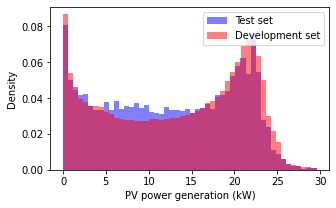

In [34]:
## Check the pv distribution
import matplotlib.pyplot as plt

pv_log_test = np.load(os.path.join(pred_folder,'pv_log_test.npy'))
pv_log_trainval = np.load(os.path.join(pred_folder,'pv_log_trainval.npy'))



plt.figure(figsize=(5,3))
plt.hist(pv_log_test, histtype='stepfilled', color='blue', density=True, bins=50, alpha=0.5,label='Test set')
plt.hist(pv_log_trainval, histtype='stepfilled', color='red', density=True, bins=50, alpha=0.5,label='Development set')
plt.ylabel('Density')
plt.xlabel('PV power generation (kW)')
plt.legend()
plt.savefig('pv_nowcast_density.pdf',bbox_inches='tight')

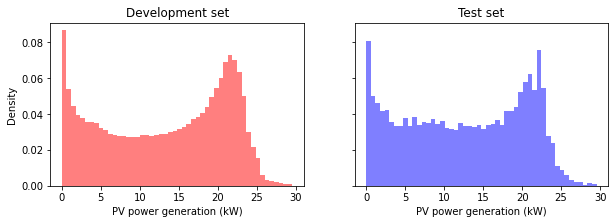

In [35]:
f,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,3))
ax[0].hist(pv_log_trainval, histtype='stepfilled', color='red', density=True, bins=50, alpha=0.5,label='Development set')
ax[0].set_title('Development set')
ax[1].hist(pv_log_test, histtype='stepfilled', color='blue', density=True, bins=50, alpha=0.5,label='Test set')
ax[1].set_title('Test set')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('PV power generation (kW)')
ax[1].set_xlabel('PV power generation (kW)')
#ax[0].legend()
plt.savefig('pv_nowcast_density_sep.pdf',bbox_inches='tight')